# Pipeline de Modelagem - Predição de Default
## Projeto: X-Health Credit Risk Model

### Objetivo
Desenvolver um modelo probabilístico para predição de default (calote) em transações B2B.

### ⚠️ Decisões de Modelagem Baseadas no EDA:
1. **Validação**: StratifiedKFold cross-validation (5 folds)
2. **Razão**: Análise temporal revelou viés de maturação nos últimos meses
3. **Threshold**: Otimização baseada em métricas de negócio

### Pipeline:
1. Carregamento e preparação dos dados
2. Feature Engineering
3. Divisão treino/teste com **StratifiedKFold**
4. Tratamento de dados (missing values, outliers, encoding)
5. Balanceamento de classes (se necessário)
6. Treinamento de modelos com **cross-validation**
7. Avaliação e seleção do melhor modelo
8. **Otimização de threshold**
9. Salvamento do modelo final

## 1. Importação de Bibliotecas

In [322]:
# Setup: Ensure all required packages are available
import sys
import subprocess

def install_if_missing(package_name, import_name=None):
    """Install package if not available."""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✓ {package_name} is available")
    except ImportError:
        print(f"⚠ {package_name} not found. Installing...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])
        print(f"✓ {package_name} installed successfully")

# Check and install critical packages
packages_to_check = [
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('scikit-learn', 'sklearn'),
    ('xgboost', 'xgboost'),
    ('lightgbm', 'lightgbm'),
    ('imbalanced-learn', 'imblearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
    ('joblib', 'joblib'),
    ('category-encoders', 'category_encoders')  # Para Target Encoding
]

print("Checking required packages...")
for pkg, imp in packages_to_check:
    install_if_missing(pkg, imp)

print("\n✅ All required packages are ready!")

Checking required packages...
✓ pandas is available
✓ numpy is available
✓ scikit-learn is available
✓ xgboost is available
✓ lightgbm is available
✓ imbalanced-learn is available
✓ matplotlib is available
✓ seaborn is available
✓ joblib is available
✓ category-encoders is available

✅ All required packages are ready!


In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Carregamento dos Dados e Tratamento de Anomalias

### Tratamento de Meses Anomalos

Na analise exploratoria (notebook 1, secao 10.2), identificamos meses com **picos de default muito acima da media** causados por **dados parciais/incompletos**:

| Mes | Registros | Taxa Default | Volume Normal | Diagnostico |
|-----|-----------|--------------|---------------|-------------|
| 12/2017 | 104 | 65.38% | ~3.500/mes | Dados parciais com vies de selecao |
| 04/2019 | 69 | 92.75% | ~3.500/mes | Dados parciais com vies de selecao |
| 10/2019 | 598 | 8.19% | ~4.500/mes | Volume muito reduzido |
| 11/2019 | 69 | 100.00% | ~4.500/mes | Dados parciais + vies de maturacao |
| 12/2019 | 40 | 100.00% | ~4.500/mes | Dados parciais + vies de maturacao |

**Estrategia**: Remover meses com volume < 200 registros antes do treinamento.

**Justificativa**: Esses registros nao representam o comportamento real de default. Incluir dados com forte vies de selecao distorceria as relacoes aprendidas pelo modelo, reduzindo sua capacidade de generalizacao.

In [324]:
# Carregar dataset
df = pd.read_csv('../_data/dataset_2021-5-26-10-14.csv', sep='\t', encoding='utf-8')

# Substituir 'missing' por NaN
df = df.replace('missing', np.nan)

print(f"Dataset shape original: {df.shape}")
print(f"Default rate original: {df['default'].mean() * 100:.2f}%")

# =============================================================================
# TRATAMENTO DE MESES ANOMALOS (identificados no EDA - secao 10.2)
# =============================================================================
# Meses com volume drasticamente baixo (<200 registros) e taxa de default
# muito acima da media. Representam dados parciais/incompletos com vies de
# selecao, NAO eventos economicos reais.
#
# 12/2017: 104 registros, 65.38% default (vizinhos: ~3.500 reg, ~10-13%)
# 04/2019:  69 registros, 92.75% default (vizinhos: ~2.500-4.500 reg, ~19-27%)
# 10/2019: 598 registros,  8.19% default (volume muito reduzido)
# 11/2019:  69 registros, 100.0% default (dados parciais + vies maturacao)
# 12/2019:  40 registros, 100.0% default (dados parciais + vies maturacao)
# =============================================================================

df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# Identificar meses anomalos: volume < 200 registros
monthly_counts = df.groupby('date').size()
meses_anomalos = monthly_counts[monthly_counts < 200].index

print(f"\nMeses anomalos removidos (volume < 200 registros):")
for mes in meses_anomalos:
    subset = df[df['date'] == mes]
    print(f"  {mes.strftime('%m/%Y')}: {len(subset)} registros, {subset['default'].mean()*100:.1f}% default")

n_antes = len(df)
df = df[~df['date'].isin(meses_anomalos)].copy()
n_removidos = n_antes - len(df)

# Remover coluna auxiliar date (sera recriada se necessario)
df = df.drop(columns=['date'])

print(f"\nRegistros removidos: {n_removidos:,} ({n_removidos/n_antes*100:.2f}%)")
print(f"Dataset shape apos filtragem: {df.shape}")
print(f"Default rate apos filtragem: {df['default'].mean() * 100:.2f}%")

print("\n" + "="*80)
print("Decisoes de Qualidade de Dados (baseadas no EDA)")
print("="*80)
print("1. Removidos meses anomalos com dados parciais/enviesados")
print("2. Usaremos StratifiedKFold cross-validation (vies de maturacao)")
print("3. Variavel year sera excluida (data leakage)")
print("4. Variavel month mantida como categorica (correlacao com default no EDA)")
print("="*80)

Dataset shape original: (117273, 22)
Default rate original: 16.67%

Meses anomalos removidos (volume < 200 registros):
  12/2017: 104 registros, 65.4% default
  04/2019: 69 registros, 92.8% default
  11/2019: 69 registros, 100.0% default
  12/2019: 40 registros, 100.0% default

Registros removidos: 282 (0.24%)
Dataset shape apos filtragem: (116991, 22)
Default rate apos filtragem: 16.50%

Decisoes de Qualidade de Dados (baseadas no EDA)
1. Removidos meses anomalos com dados parciais/enviesados
2. Usaremos StratifiedKFold cross-validation (vies de maturacao)
3. Variavel year sera excluida (data leakage)
4. Variavel month mantida como categorica (correlacao com default no EDA)


## 3. Preparação de Dados e Feature Engineering

In [325]:
# Criar copia para processamento
df_processed = df.copy()

# =============================================================================
# DECISAO: Manter 'month' como feature categorica
# Justificativa: A analise exploratoria (EDA) identificou correlacao entre
# o mes da transacao e a taxa de default, indicando sazonalidade no
# comportamento de pagamento. month tem 12 categorias (baixa cardinalidade),
# adequado para OneHotEncoder.
# Nota: 'year' continua sendo removido (data leakage / vies de maturacao).
# =============================================================================
df_processed['month'] = df_processed['month'].apply(
    lambda x: 'unknown' if pd.isna(x) else str(int(x))
)
print("month convertido para categorica (correlacao com default no EDA)")

# Separar features numericas e categoricas
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('default')  # Remover target

categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures numericas iniciais ({len(numeric_features)}): {numeric_features}")
print(f"\nFeatures categoricas ({len(categorical_features)}): {categorical_features}")

# Identificar variaveis de alta vs baixa cardinalidade
categorical_cardinality = {col: df_processed[col].nunique() for col in categorical_features}
print(f"\nCardinalidade das variaveis categoricas:")
for col, card in categorical_cardinality.items():
    print(f"  - {col}: {card} categorias")

# Separar em alta e baixa cardinalidade (threshold = 10)
high_cardinality_features = [col for col, card in categorical_cardinality.items() if card > 10]
low_cardinality_features = [col for col, card in categorical_cardinality.items() if card <= 10]

# month: 12 categorias -> mover para baixa cardinalidade (OneHotEncoder)
# Apesar de ter 12 categorias (> threshold 10), meses sao categorias fixas
# e conhecidas, adequadas para OneHotEncoder.
if 'month' in high_cardinality_features:
    high_cardinality_features.remove('month')
    low_cardinality_features.append('month')

print(f"\nEstrategia de Encoding:")
print(f"  - Alta cardinalidade (Target Encoding): {high_cardinality_features}")
print(f"  - Baixa cardinalidade (One-Hot Encoding): {low_cardinality_features}")
print(f"\nNota: 'year' sera removido apos feature engineering (data leakage)")

month convertido para categorica (correlacao com default no EDA)

Features numericas iniciais (16): ['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer', 'valor_vencido', 'valor_quitado', 'quant_protestos', 'valor_protestos', 'quant_acao_judicial', 'acao_judicial_valor', 'participacao_falencia_valor', 'dividas_vencidas_valor', 'dividas_vencidas_qtd', 'falencia_concordata_qtd', 'valor_total_pedido', 'year']

Features categoricas (5): ['tipo_sociedade', 'opcao_tributaria', 'atividade_principal', 'forma_pagamento', 'month']

Cardinalidade das variaveis categoricas:
  - tipo_sociedade: 16 categorias
  - opcao_tributaria: 4 categorias
  - atividade_principal: 203 categorias
  - forma_pagamento: 104 categorias
  - month: 12 categorias

Estrategia de Encoding:
  - Alta cardinalidade (Target Encoding): ['tipo_sociedade', 'atividade_principal', 'forma_pagamento']
  - Baixa cardinalidade (One-Hot Encoding): ['opcao_tributaria', 'month']

Nota: 'year' sera removido apos feature e

In [326]:
# =============================================================================
# Feature Engineering: Funcao Reutilizavel
# =============================================================================
# Esta funcao e reutilizada no notebook de predicao (3_prediction.ipynb)
# para garantir que as mesmas features derivadas sejam criadas em producao.
# =============================================================================

def engineer_features(df):
    """
    Cria features derivadas a partir dos dados brutos.

    Features criadas:
        - ratio_vencido_quitado: proporcao de valores vencidos vs quitados
        - ratio_pedido_historico: proporcao do pedido vs historico de pagamentos
        - exposicao_total: soma de valores por vencer e vencidos
        - tem_protestos: flag binaria de existencia de protestos
        - tem_acao_judicial: flag binaria de existencia de acoes judiciais

    Args:
        df: DataFrame com features brutas

    Returns:
        DataFrame com features derivadas adicionadas
    """
    df = df.copy()

    # Ratios financeiros
    if 'valor_vencido' in df.columns and 'valor_quitado' in df.columns:
        df['ratio_vencido_quitado'] = df['valor_vencido'] / (df['valor_quitado'] + 1)

    if 'valor_total_pedido' in df.columns and 'valor_quitado' in df.columns:
        df['ratio_pedido_historico'] = df['valor_total_pedido'] / (df['valor_quitado'] + 1)

    if 'valor_por_vencer' in df.columns and 'valor_vencido' in df.columns:
        df['exposicao_total'] = df['valor_por_vencer'] + df['valor_vencido']

    # Flags de risco
    if 'quant_protestos' in df.columns:
        df['tem_protestos'] = (df['quant_protestos'] > 0).astype(int)

    if 'quant_acao_judicial' in df.columns:
        df['tem_acao_judicial'] = (df['quant_acao_judicial'] > 0).astype(int)

    return df

# Aplicar feature engineering
df_processed = engineer_features(df_processed)

# Atualizar lista de features numericas
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('default')

# CRITICO: Remover year APOS engenharia de features para evitar data leakage
# Nota: month e mantido como feature categorica (correlacao com default no EDA)
if 'year' in numeric_features:
    numeric_features.remove('year')
    print("Removida variavel 'year' (prevencao de data leakage)")


# Lista de features derivadas (salva no metadata para reutilizacao)
derived_features = ['ratio_vencido_quitado', 'ratio_pedido_historico', 'exposicao_total', 'tem_protestos', 'tem_acao_judicial']

print(f"\nTotal features apos engenharia e remocao de variaveis temporais: {len(numeric_features) + len(categorical_features)}")
print(f"  - Features numericas: {len(numeric_features)} (incluindo {len(derived_features)} derivadas)")
print(f"  - Features categoricas: {len(categorical_features)}")
print(f"\nFeatures derivadas: {derived_features}")
print(f"\nFuncao engineer_features() disponivel para reutilizacao no notebook de predicao")

Removida variavel 'year' (prevencao de data leakage)

Total features apos engenharia e remocao de variaveis temporais: 25
  - Features numericas: 20 (incluindo 5 derivadas)
  - Features categoricas: 5

Features derivadas: ['ratio_vencido_quitado', 'ratio_pedido_historico', 'exposicao_total', 'tem_protestos', 'tem_acao_judicial']

Funcao engineer_features() disponivel para reutilizacao no notebook de predicao


## 4. Divisão Treino/Teste com Estratificação

**Estratégia de Validação:**
- **Hold-out set**: 20% dos dados para teste final (estratificado)
- **Cross-validation**: StratifiedKFold (5 folds) nos 80% de treino
- **Razão**: Evitar viés de maturação identificado no EDA

Esta abordagem garante avaliação robusta sem viés temporal.

In [327]:
# Separar X e y
X = df_processed[numeric_features + categorical_features]
y = df_processed['default']

# Split treino/teste estratificado (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("="*80)
print("DIVISÃO TREINO/TESTE ESTRATIFICADA")
print("="*80)
print(f"\n📊 Tamanhos dos conjuntos:")
print(f"  - Training set: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(df_processed)*100:.1f}%)")
print(f"  - Test set:     {X_test.shape[0]:,} registros ({X_test.shape[0]/len(df_processed)*100:.1f}%)")

print(f"\n🎯 Distribuição do target (estratificada):")
print(f"  - Treino: Default rate = {y_train.mean()*100:.2f}%")
print(f"  - Teste:  Default rate = {y_test.mean()*100:.2f}%")

print("\n✅ Distribuição balanceada entre treino e teste")
print("✅ Cross-validation será aplicado no conjunto de treino")
print("="*80)

DIVISÃO TREINO/TESTE ESTRATIFICADA

📊 Tamanhos dos conjuntos:
  - Training set: 93,592 registros (80.0%)
  - Test set:     23,399 registros (20.0%)

🎯 Distribuição do target (estratificada):
  - Treino: Default rate = 16.50%
  - Teste:  Default rate = 16.50%

✅ Distribuição balanceada entre treino e teste
✅ Cross-validation será aplicado no conjunto de treino


## 5. Pipelines de Pré-processamento

### Estratégia de Encoding:
- **Target Encoding** para alta cardinalidade (`atividade_principal`, `forma_pagamento`)
  - Reduz dimensionalidade (203+104 → 2 features)
  - Captura relação com target
  
- **One-Hot Encoding** para baixa cardinalidade (`tipo_sociedade`, `opcao_tributaria`,`month`)
  - Preserva informação sem explodir features

- **RobustScaler** ao invés de StandardScaler
  - Mais robusto a outliers identificados no EDA

In [328]:
# Importar TargetEncoder
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder

# Pipeline para features numéricas (usando RobustScaler para lidar com outliers)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Mais robusto a outliers
])

# Pipeline para features categóricas de ALTA cardinalidade (Target Encoding)
high_cardinality_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_encoder', TargetEncoder(smoothing=1.0, min_samples_leaf=1))
])

# Pipeline para features categóricas de BAIXA cardinalidade (One-Hot Encoding)
low_cardinality_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_high', high_cardinality_transformer, high_cardinality_features),
        ('cat_low', low_cardinality_transformer, low_cardinality_features)
    ])

print("✅ Preprocessor pipeline criado com sucesso!")
print(f"\n📊 Resumo:")
print(f"  - Features numéricas: {len(numeric_features)} → normalização com RobustScaler")
print(f"  - Alta cardinalidade: {len(high_cardinality_features)} → Target Encoding")
print(f"  - Baixa cardinalidade: {len(low_cardinality_features)} → One-Hot Encoding")
print(f"\n💡 Redução esperada de features: ~{sum(categorical_cardinality.values())} → ~{len(high_cardinality_features) + sum(categorical_cardinality[c] for c in low_cardinality_features)}")

✅ Preprocessor pipeline criado com sucesso!

📊 Resumo:
  - Features numéricas: 20 → normalização com RobustScaler
  - Alta cardinalidade: 3 → Target Encoding
  - Baixa cardinalidade: 2 → One-Hot Encoding

💡 Redução esperada de features: ~339 → ~19


## 6. Definição de Modelos para Comparação

In [329]:
# Dicionário de modelos para testar (com class_weight='balanced' onde aplicável)
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000, 
        class_weight='balanced'  # Balanceamento via pesos
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE, 
        max_depth=10,
        class_weight='balanced'  # Balanceamento via pesos
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100, 
        max_depth=10,
        class_weight='balanced'  # Balanceamento via pesos
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100
    ),
    'XGBoost': XGBClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100, 
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # Balanceamento via peso
    ),
    'LightGBM': LGBMClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100, 
        verbose=-1,
        class_weight='balanced'  # Balanceamento via pesos
    )
}

print(f"✅ Modelos configurados com class_weight='balanced'")
print(f"\nModelos a serem testados: {list(models.keys())}")
print(f"\n⚠️  Nota: Todos os modelos estão configurados para balancear classes automaticamente")

✅ Modelos configurados com class_weight='balanced'

Modelos a serem testados: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']

⚠️  Nota: Todos os modelos estão configurados para balancear classes automaticamente


## 7. Função de Avaliação de Modelos

In [330]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Avalia um modelo com cross-validation e hold-out test set.
    """
    # Cross-validation no conjunto de treino
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilidades
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    results = {
        'Model': model_name,
        'CV_ROC_AUC_mean': cv_scores.mean(),
        'CV_ROC_AUC_std': cv_scores.std(),
        'Train_Accuracy': accuracy_score(y_train, y_pred_train),
        'Test_Accuracy': accuracy_score(y_test, y_pred_test),
        'Train_Precision': precision_score(y_train, y_pred_train),
        'Test_Precision': precision_score(y_test, y_pred_test),
        'Train_Recall': recall_score(y_train, y_pred_train),
        'Test_Recall': recall_score(y_test, y_pred_test),
        'Train_F1': f1_score(y_train, y_pred_train),
        'Test_F1': f1_score(y_test, y_pred_test),
        'Train_ROC_AUC': roc_auc_score(y_train, y_pred_proba_train),
        'Test_ROC_AUC': roc_auc_score(y_test, y_pred_proba_test)
    }
    
    return results, y_pred_test, y_pred_proba_test

## 8. Treinamento e Comparação de Modelos

### Melhorias Implementadas:
1. ✅ **Target Encoding** para alta cardinalidade → reduz features
2. ✅ **RobustScaler** → mais robusto a outliers
3. ✅ **class_weight='balanced'** → balanceamento automático
4. ✅ **StratifiedKFold** → validação robusta sem viés temporal

In [331]:
# Pré-processar dados
# IMPORTANTE: Target Encoder precisa de y_train para fit
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

print("✅ Dados pré-processados com sucesso!")
print(f"\n📊 Shape após pré-processamento:")
print(f"  - Antes: {X_train.shape}")
print(f"  - Depois: {X_train_processed.shape}")
print(f"\n💡 Redução de features: {X_train.shape[1]} → {X_train_processed.shape[1]}")
print(f"   (Antes com One-Hot puro teríamos ~350 features!)")

✅ Dados pré-processados com sucesso!

📊 Shape após pré-processamento:
  - Antes: (93592, 25)
  - Depois: (93592, 40)

💡 Redução de features: 25 → 40
   (Antes com One-Hot puro teríamos ~350 features!)


## 8.1. Análise das Transformações de Encoding

Visualizações detalhadas mostrando o efeito de cada tipo de encoding nas features.

### 📋 Justificativa da Escolha dos Encoders:

#### 1. **Target Encoding** (Alta Cardinalidade)

**Por que usar?**
- **Problema**: Features com alta cardinalidade (: 203 categorias, : 104 categorias)
- **One-Hot seria inviável**: Geraria ~350 features, causando:
  - **Explosão de dimensionalidade** (curse of dimensionality)
  - **Overfitting** (muitas features com poucos exemplos cada)
  - **Alto custo computacional**
  - **Esparsidade** (matrizes com muitos zeros)

**Solução: Target Encoding**
- ✅ Reduz 307 categorias → 3 features numéricas
- ✅ Captura relação direta com o target (taxa de default)
- ✅ Preserva informação discriminativa
- ✅ Compatível com modelos tree-based

**Como funciona**: Substitui cada categoria pela taxa média de default daquela categoria

---

#### 2. **One-Hot Encoding** (Baixa Cardinalidade)

**Por que usar?**
- **Problema**: Features com baixa cardinalidade (: 8 categorias, : 2 categorias)
- **Target Encoding seria desperdício**: Perderia informação categórica valiosa

**Solução: One-Hot Encoding**
- ✅ Preserva 100% da informação categórica
- ✅ Não causa explosão de dimensionalidade (apenas 10 features)
- ✅ Permite ao modelo aprender padrões específicos por categoria
- ✅ Não assume ordinalidade entre categorias

**Como funciona**: Cria uma coluna binária (0/1) para cada categoria

---

#### 3. **RobustScaler** (Features Numéricas)

**Por que usar ao invés de StandardScaler?**
- **Problema**: EDA identificou **muitos outliers** em variáveis financeiras
  - Valores extremos em , , 
  - Outliers são **informação válida** (empresas com dívidas muito altas)

**Solução: RobustScaler**
- ✅ **Usa mediana e IQR** (Q3-Q1) ao invés de média e desvio padrão
- ✅ **Resistente a outliers**: estatísticas não são distorcidas por valores extremos
- ✅ **Preserva outliers**: mantém a informação mas reduz seu peso na escala
- ✅ **Melhor convergência**: features na mesma escala sem domínio de outliers

**Como funciona**: 

**Comparação**:
| Método | Usa | Sensível a Outliers? | Quando Usar |
|--------|-----|---------------------|-------------|
| StandardScaler | Média + Desvio | ✅ Sim | Dados normais/limpos |
| RobustScaler | Mediana + IQR | ❌ Não | **Dados com outliers** ✅ |

---

### 🎯 Resultado Final:

| Antes | Depois | Redução |
|-------|--------|---------|
| **Alta card.**: 307 categorias | **Target Enc**: 3 features | ~99% redução |
| **Baixa card.**: 10 categorias | **One-Hot**: 10 features | Mantido (OK) |
| **Numéricas**: 15 features | **Scaled**: 15 features | Normalizado |
| **Total**: ~332 features | **Total**: ~28 features | ~91% redução\! |

### 📊 Visualizações Abaixo:

As visualizações a seguir mostram o **antes e depois** de cada transformação:



🎯 ANÁLISE: TARGET ENCODING - ALTA CARDINALIDADE

📊 Analisando: tipo_sociedade
  ✓ Cardinalidade original: 16 categorias
  ✓ Após Target Encoding: 1 feature numérica contínua
  ✓ Range dos valores: [0.000, 0.656]
  ✓ Interpretação: Valores maiores = maior probabilidade de default

📊 Analisando: atividade_principal
  ✓ Cardinalidade original: 202 categorias
  ✓ Após Target Encoding: 1 feature numérica contínua
  ✓ Range dos valores: [0.000, 0.727]
  ✓ Interpretação: Valores maiores = maior probabilidade de default

📊 Analisando: forma_pagamento
  ✓ Cardinalidade original: 104 categorias
  ✓ Após Target Encoding: 1 feature numérica contínua
  ✓ Range dos valores: [0.000, 0.625]
  ✓ Interpretação: Valores maiores = maior probabilidade de default


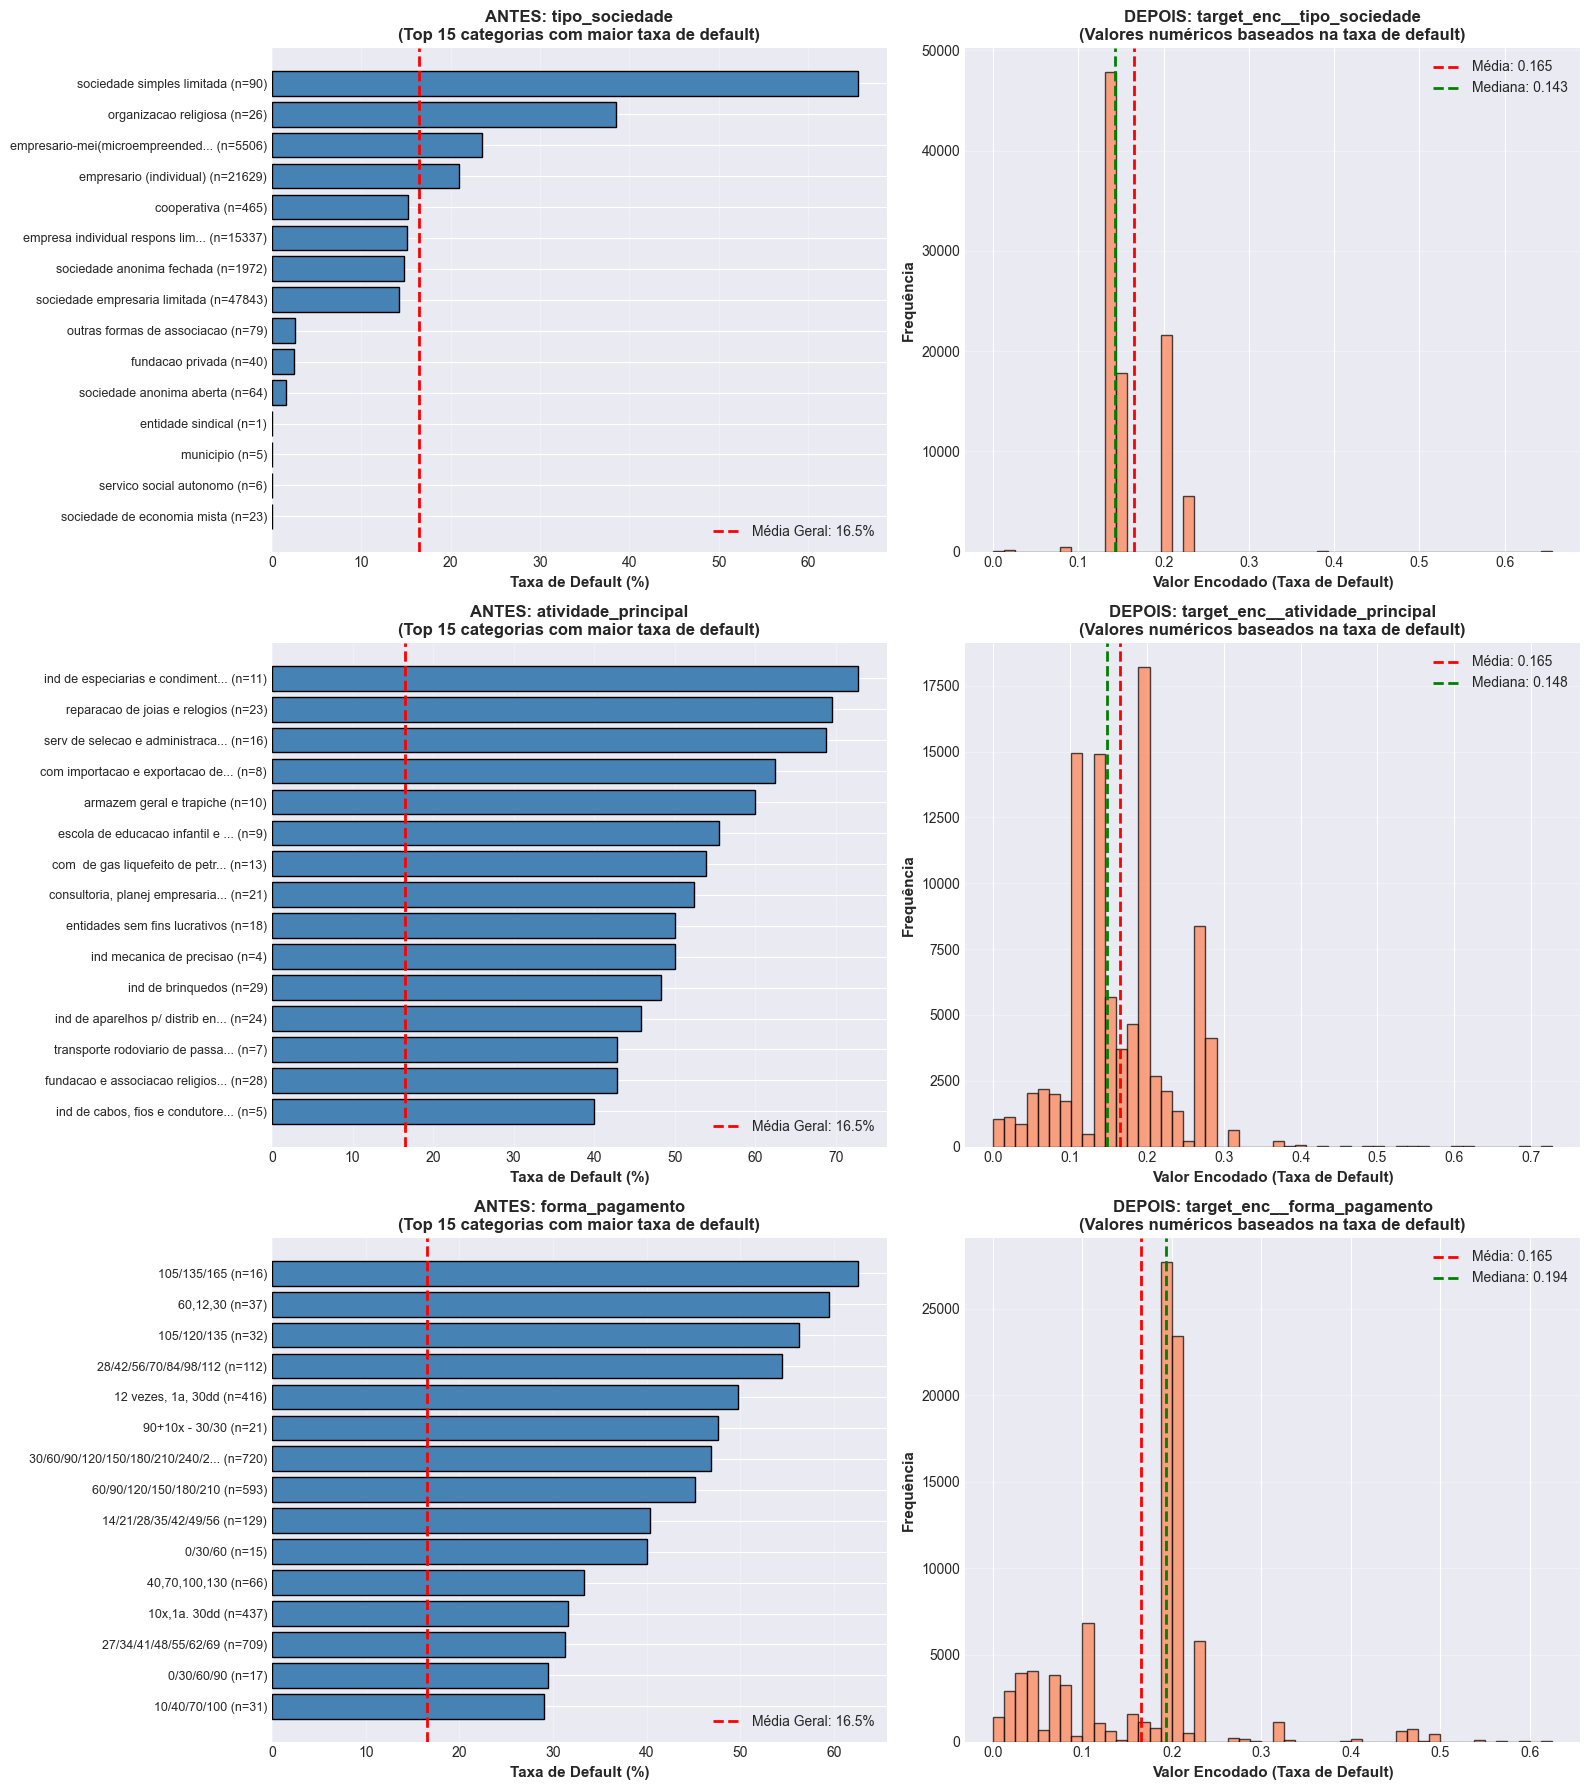


💡 INTERPRETAÇÃO DO TARGET ENCODING:
- Cada categoria foi substituída pela TAXA MÉDIA DE DEFAULT daquela categoria
- Categorias com alta inadimplência → valores altos (próximos de 1)
- Categorias com baixa inadimplência → valores baixos (próximos de 0)
- Reduz drasticamente a dimensionalidade mantendo a relação com o target


In [332]:
# ============================================================================
# ANÁLISE 1: TARGET ENCODING (Alta Cardinalidade)
# ============================================================================
print("\n" + "="*80)
print("🎯 ANÁLISE: TARGET ENCODING - ALTA CARDINALIDADE")
print("="*80)

fig, axes = plt.subplots(len(high_cardinality_features), 2, figsize=(16, 6*len(high_cardinality_features)))

if len(high_cardinality_features) == 1:
    axes = axes.reshape(1, -1)

for idx, feature in enumerate(high_cardinality_features):
    print(f"\n📊 Analisando: {feature}")
    
    # ANTES: Distribuição original + taxa de default por categoria
    ax_before = axes[idx, 0]
    
    # Calcular taxa de default por categoria (top 15)
    default_rate_by_category = X_train[feature].to_frame().join(y_train).groupby(feature)['default'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    top_categories = default_rate_by_category.head(15)
    
    # Gráfico de barras com taxa de default
    bars = ax_before.barh(range(len(top_categories)), top_categories['mean'] * 100, color='steelblue', edgecolor='black')
    ax_before.set_yticks(range(len(top_categories)))
    ax_before.set_yticklabels([f"{cat[:30]}... (n={count})" if len(str(cat)) > 30 else f"{cat} (n={count})" 
                                for cat, count in zip(top_categories.index, top_categories['count'])], 
                               fontsize=9)
    ax_before.set_xlabel('Taxa de Default (%)', fontsize=11, fontweight='bold')
    ax_before.set_title(f'ANTES: {feature}\n(Top 15 categorias com maior taxa de default)', 
                        fontsize=12, fontweight='bold')
    ax_before.grid(axis='x', alpha=0.3)
    ax_before.invert_yaxis()
    
    # Adicionar linha da média geral
    overall_mean = y_train.mean() * 100
    ax_before.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2, label=f'Média Geral: {overall_mean:.1f}%')
    ax_before.legend()
    
    # DEPOIS: Distribuição do Target Encoding
    ax_after = axes[idx, 1]
    
    # Encontrar a coluna correspondente no dataset processado
    feature_idx = len(numeric_features) + high_cardinality_features.index(feature)
    encoded_values = X_train_processed[:, feature_idx]
    
    # Histograma dos valores encodados
    ax_after.hist(encoded_values, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax_after.set_xlabel('Valor Encodado (Taxa de Default)', fontsize=11, fontweight='bold')
    ax_after.set_ylabel('Frequência', fontsize=11, fontweight='bold')
    ax_after.set_title(f'DEPOIS: target_enc__{feature}\n(Valores numéricos baseados na taxa de default)', 
                       fontsize=12, fontweight='bold')
    ax_after.grid(axis='y', alpha=0.3)
    
    # Adicionar estatísticas
    ax_after.axvline(x=encoded_values.mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Média: {encoded_values.mean():.3f}')
    ax_after.axvline(x=np.median(encoded_values), color='green', linestyle='--', linewidth=2, 
                     label=f'Mediana: {np.median(encoded_values):.3f}')
    ax_after.legend()
    
    print(f"  ✓ Cardinalidade original: {X_train[feature].nunique()} categorias")
    print(f"  ✓ Após Target Encoding: 1 feature numérica contínua")
    print(f"  ✓ Range dos valores: [{encoded_values.min():.3f}, {encoded_values.max():.3f}]")
    print(f"  ✓ Interpretação: Valores maiores = maior probabilidade de default")

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 INTERPRETAÇÃO DO TARGET ENCODING:")
print("="*80)
print("- Cada categoria foi substituída pela TAXA MÉDIA DE DEFAULT daquela categoria")
print("- Categorias com alta inadimplência → valores altos (próximos de 1)")
print("- Categorias com baixa inadimplência → valores baixos (próximos de 0)")
print("- Reduz drasticamente a dimensionalidade mantendo a relação com o target")
print("="*80)


🔢 ANÁLISE: ONE-HOT ENCODING - BAIXA CARDINALIDADE

📊 Analisando: opcao_tributaria
  ✓ Cardinalidade original: 4 categorias
  ✓ Após One-Hot Encoding: 5 features binárias
  ✓ Interpretação: Cada categoria vira uma coluna separada com valores 0/1

📊 Analisando: month
  ✓ Cardinalidade original: 12 categorias
  ✓ Após One-Hot Encoding: 12 features binárias
  ✓ Interpretação: Cada categoria vira uma coluna separada com valores 0/1


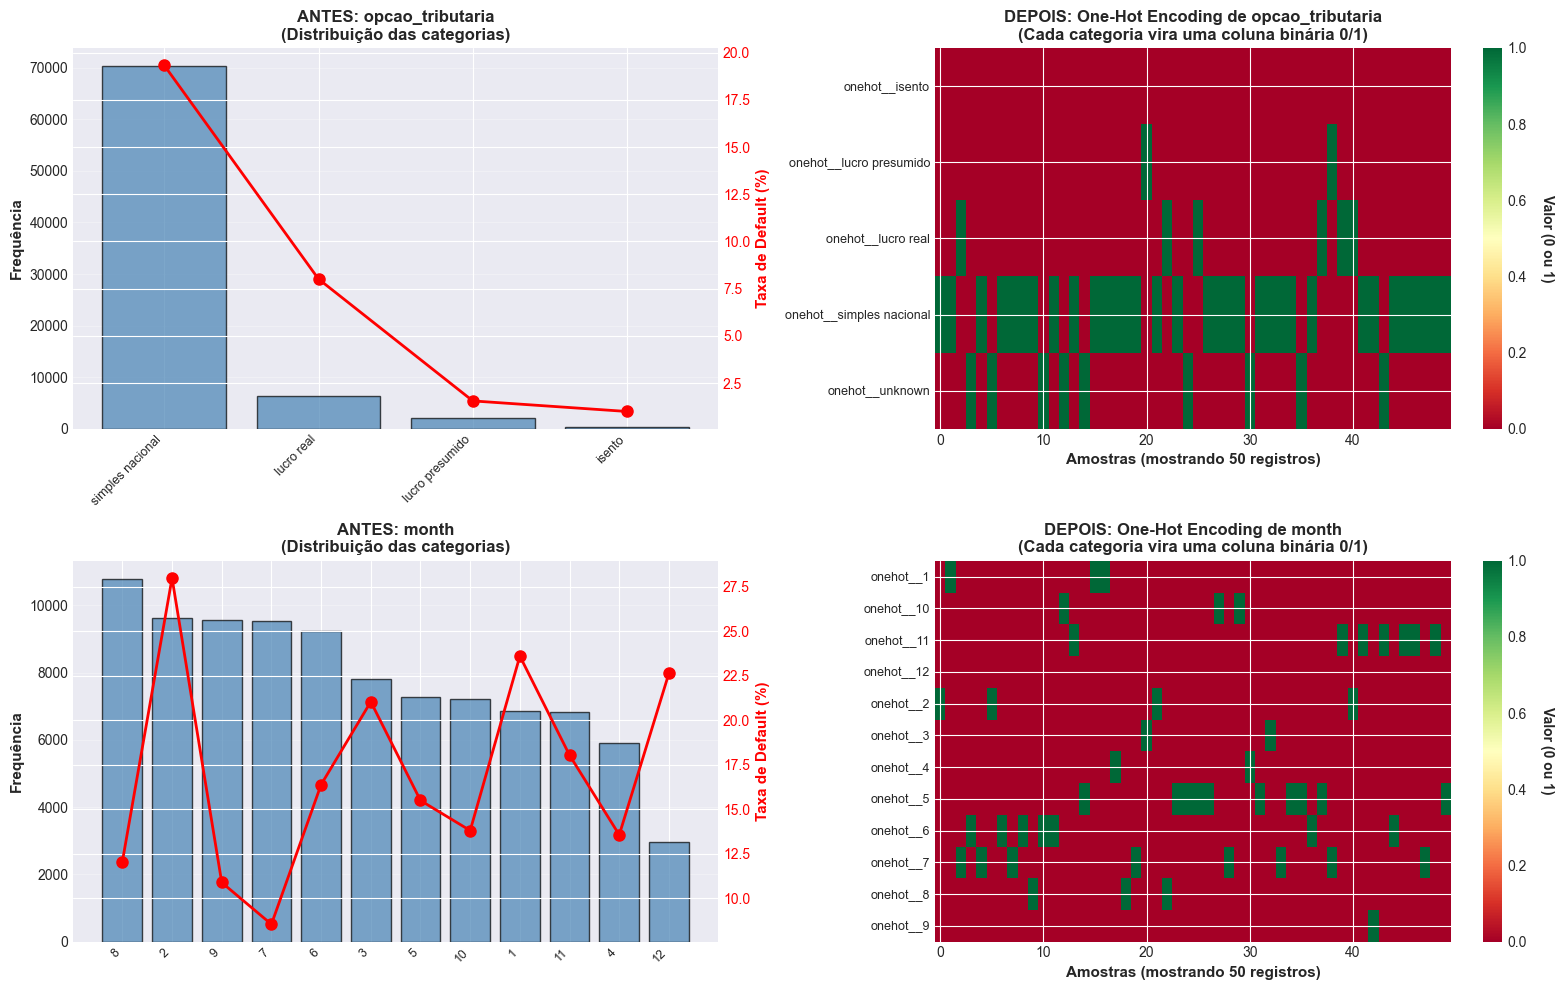


💡 INTERPRETAÇÃO DO ONE-HOT ENCODING:
- Cada categoria original vira UMA COLUNA BINÁRIA separada
- Valor 1 = registro pertence àquela categoria
- Valor 0 = registro NÃO pertence àquela categoria
- Preserva toda a informação mas aumenta dimensionalidade
- Usado para baixa cardinalidade para evitar explosão de features


In [333]:
# ============================================================================
# ANÁLISE 2: ONE-HOT ENCODING (Baixa Cardinalidade)
# ============================================================================
print("\n" + "="*80)
print("🔢 ANÁLISE: ONE-HOT ENCODING - BAIXA CARDINALIDADE")
print("="*80)

fig, axes = plt.subplots(len(low_cardinality_features), 2, figsize=(16, 5*len(low_cardinality_features)))

if len(low_cardinality_features) == 1:
    axes = axes.reshape(1, -1)

for idx, feature in enumerate(low_cardinality_features):
    print(f"\n📊 Analisando: {feature}")
    
    # ANTES: Distribuição de categorias
    ax_before = axes[idx, 0]
    
    # Contar categorias e taxa de default
    category_counts = X_train[feature].value_counts()
    category_default_rate = X_train[feature].to_frame().join(y_train).groupby(feature)['default'].mean() * 100
    
    # Criar gráfico de barras
    x_pos = np.arange(len(category_counts))
    bars = ax_before.bar(x_pos, category_counts, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Adicionar taxa de default como texto
    ax2 = ax_before.twinx()
    ax2.plot(x_pos, [category_default_rate[cat] for cat in category_counts.index], 
             color='red', marker='o', linewidth=2, markersize=8, label='Taxa Default (%)')
    ax2.set_ylabel('Taxa de Default (%)', fontsize=11, fontweight='bold', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax_before.set_xticks(x_pos)
    ax_before.set_xticklabels([str(cat)[:20] for cat in category_counts.index], rotation=45, ha='right', fontsize=9)
    ax_before.set_ylabel('Frequência', fontsize=11, fontweight='bold')
    ax_before.set_title(f'ANTES: {feature}\n(Distribuição das categorias)', 
                        fontsize=12, fontweight='bold')
    ax_before.grid(axis='y', alpha=0.3)
    
    # DEPOIS: Matriz de One-Hot Encoding
    ax_after = axes[idx, 1]
    
    # Obter as colunas one-hot correspondentes
    start_idx = len(numeric_features) + len(high_cardinality_features)
    onehot_encoder = preprocessor.named_transformers_['cat_low'].named_steps['onehot']
    n_categories = len(onehot_encoder.categories_[idx])
    
    # Pegar uma amostra para visualizar
    sample_size = min(50, len(X_train_processed))
    sample_indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
    
    # Criar matriz one-hot para visualização
    if idx == 0:
        end_idx = start_idx + n_categories
    else:
        # Calcular offset baseado em features anteriores
        offset = sum([len(preprocessor.named_transformers_['cat_low'].named_steps['onehot'].categories_[i]) 
                     for i in range(idx)])
        start_idx = len(numeric_features) + len(high_cardinality_features) + offset
        end_idx = start_idx + n_categories
    
    onehot_sample = X_train_processed[sample_indices, start_idx:end_idx]
    
    # Visualizar como heatmap
    im = ax_after.imshow(onehot_sample.T, cmap='RdYlGn', aspect='auto', interpolation='nearest')
    ax_after.set_yticks(range(n_categories))
    ax_after.set_yticklabels([f"onehot__{cat}" for cat in onehot_encoder.categories_[idx]], fontsize=9)
    ax_after.set_xlabel(f'Amostras (mostrando {sample_size} registros)', fontsize=11, fontweight='bold')
    ax_after.set_title(f'DEPOIS: One-Hot Encoding de {feature}\n(Cada categoria vira uma coluna binária 0/1)', 
                       fontsize=12, fontweight='bold')
    
    # Adicionar colorbar
    cbar = plt.colorbar(im, ax=ax_after)
    cbar.set_label('Valor (0 ou 1)', rotation=270, labelpad=20, fontweight='bold')
    
    print(f"  ✓ Cardinalidade original: {len(category_counts)} categorias")
    print(f"  ✓ Após One-Hot Encoding: {n_categories} features binárias")
    print(f"  ✓ Interpretação: Cada categoria vira uma coluna separada com valores 0/1")

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 INTERPRETAÇÃO DO ONE-HOT ENCODING:")
print("="*80)
print("- Cada categoria original vira UMA COLUNA BINÁRIA separada")
print("- Valor 1 = registro pertence àquela categoria")
print("- Valor 0 = registro NÃO pertence àquela categoria")
print("- Preserva toda a informação mas aumenta dimensionalidade")
print("- Usado para baixa cardinalidade para evitar explosão de features")
print("="*80)


📐 ANÁLISE: ROBUST SCALER - FEATURES NUMÉRICAS

📊 Analisando: default_3months
  ✓ Range original: [0.00, 26.00]
  ✓ Após RobustScaler: [0.000, 26.000]
  ✓ Média original: 0.15 → 0.148
  ✓ Outliers preservados mas com menor influência

📊 Analisando: ioi_36months
  ✓ Range original: [1.00, 951.00]
  ✓ Após RobustScaler: [-0.749, 18.470]
  ✓ Média original: 55.61 → 0.356
  ✓ Outliers preservados mas com menor influência

📊 Analisando: ioi_3months
  ✓ Range original: [1.00, 90.00]
  ✓ Após RobustScaler: [-2.105, 10.383]
  ✓ Média original: 17.11 → 0.155
  ✓ Outliers preservados mas com menor influência

📊 Analisando: valor_por_vencer
  ✓ Range original: [0.00, 72197586.36]
  ✓ Após RobustScaler: [-0.228, 3693.720]
  ✓ Média original: 63884.25 → 3.040
  ✓ Outliers preservados mas com menor influência

📊 Analisando: valor_vencido
  ✓ Range original: [0.00, 13150500.00]
  ✓ Após RobustScaler: [0.000, 13150500.000]
  ✓ Média original: 2515.80 → 2515.798
  ✓ Outliers preservados mas com menor i

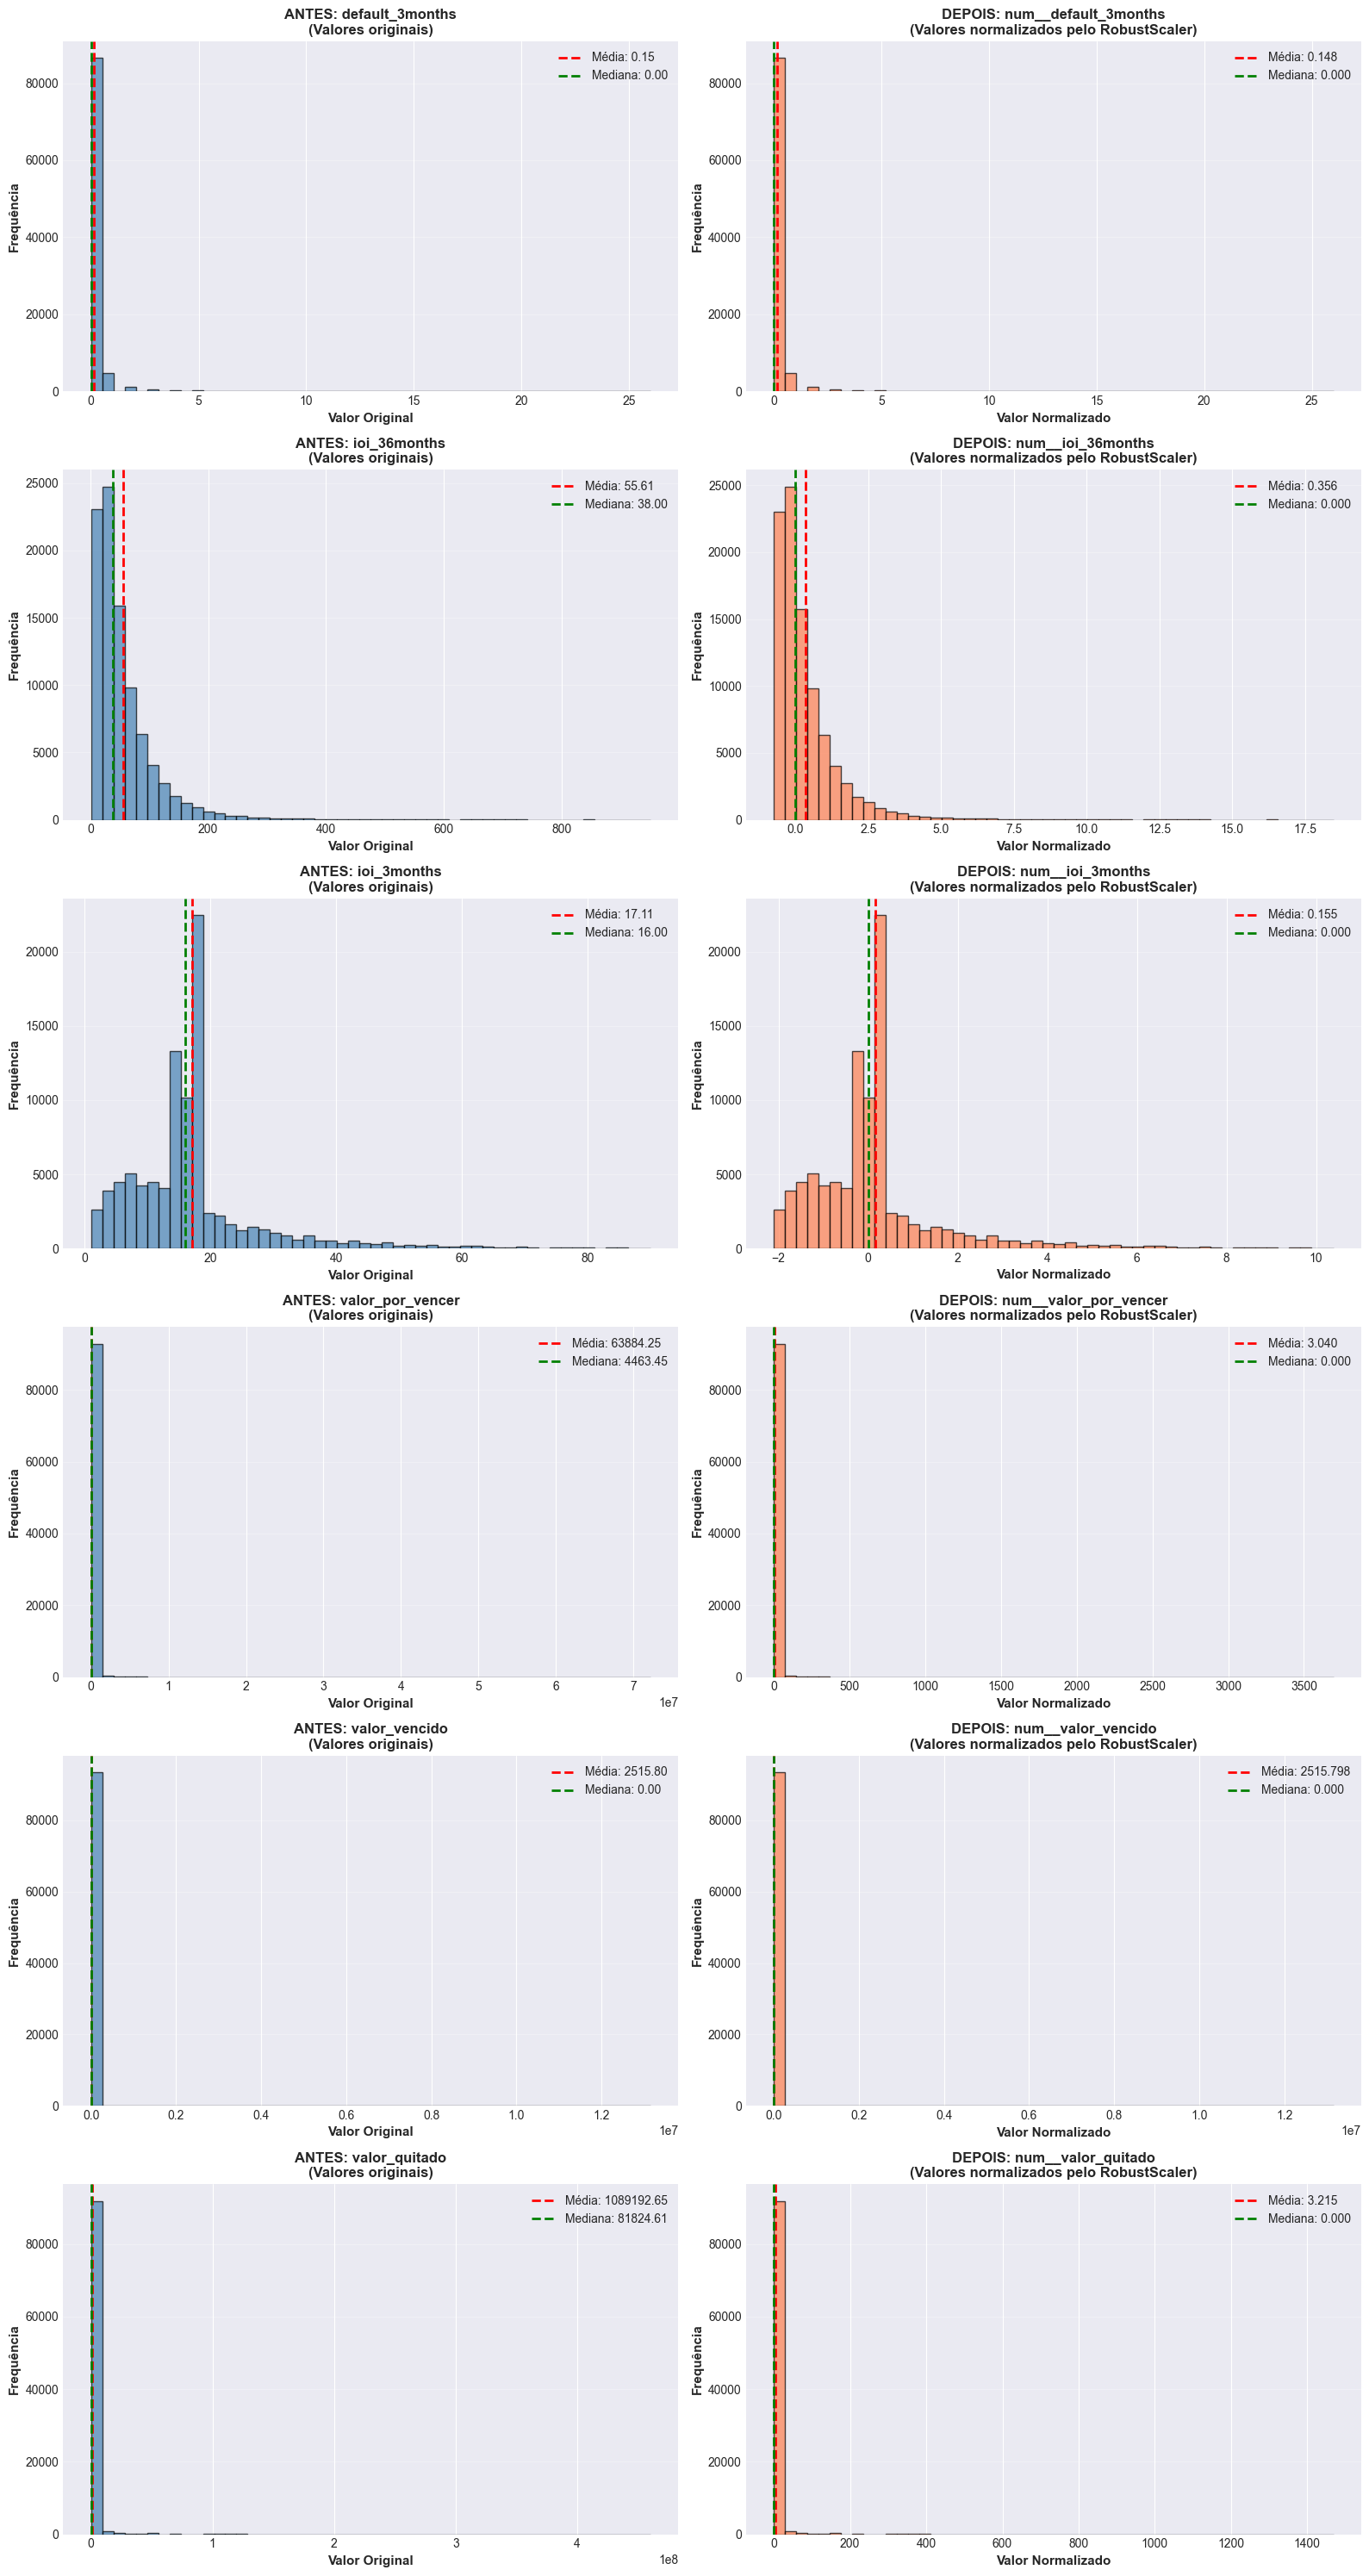


💡 INTERPRETAÇÃO DO ROBUST SCALER:
- Remove a mediana e escala pelos quantis (Q1 e Q3)
- MAIS ROBUSTO A OUTLIERS que StandardScaler (que usa média e desvio padrão)
- Valores centralizados em torno de 0
- Escala similar entre features, facilitando convergência do modelo
- Outliers continuam presentes mas têm menor peso na escala

📊 RESUMO DAS TRANSFORMAÇÕES

1. TARGET ENCODING (3 features):
   • tipo_sociedade (16 categorias) → target_enc__tipo_sociedade (1 feature numérica)
   • atividade_principal (202 categorias) → target_enc__atividade_principal (1 feature numérica)
   • forma_pagamento (104 categorias) → target_enc__forma_pagamento (1 feature numérica)

2. ONE-HOT ENCODING (2 features):
   • opcao_tributaria (4 categorias) → 4 features binárias
   • month (12 categorias) → 12 features binárias

3. ROBUST SCALER (20 features):
   • Todas as features numéricas normalizadas e centralizadas

📏 Total de features:
   • Antes: 25 features
   • Depois: 40 features
   • Redução de ~358 → 40

In [334]:
# ============================================================================
# ANÁLISE 3: ROBUST SCALER (Features Numéricas)
# ============================================================================
print("\n" + "="*80)
print("📐 ANÁLISE: ROBUST SCALER - FEATURES NUMÉRICAS")
print("="*80)

# Selecionar algumas features numéricas importantes para visualizar
# Vamos pegar as 6 primeiras features numéricas como exemplo
features_to_plot = numeric_features[:min(6, len(numeric_features))]

fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(16, 5*len(features_to_plot)))

if len(features_to_plot) == 1:
    axes = axes.reshape(1, -1)

for idx, feature in enumerate(features_to_plot):
    print(f"\n📊 Analisando: {feature}")
    
    # ANTES: Distribuição original
    ax_before = axes[idx, 0]
    
    original_values = X_train[feature].dropna()
    
    ax_before.hist(original_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax_before.set_xlabel('Valor Original', fontsize=11, fontweight='bold')
    ax_before.set_ylabel('Frequência', fontsize=11, fontweight='bold')
    ax_before.set_title(f'ANTES: {feature}\n(Valores originais)', 
                        fontsize=12, fontweight='bold')
    ax_before.grid(axis='y', alpha=0.3)
    
    # Adicionar estatísticas
    ax_before.axvline(x=original_values.mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Média: {original_values.mean():.2f}')
    ax_before.axvline(x=original_values.median(), color='green', linestyle='--', linewidth=2, 
                     label=f'Mediana: {original_values.median():.2f}')
    ax_before.legend()
    
    # DEPOIS: Distribuição após RobustScaler
    ax_after = axes[idx, 1]
    
    # Encontrar a coluna correspondente no dataset processado
    feature_idx = numeric_features.index(feature)
    scaled_values = X_train_processed[:, feature_idx]
    
    ax_after.hist(scaled_values, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax_after.set_xlabel('Valor Normalizado', fontsize=11, fontweight='bold')
    ax_after.set_ylabel('Frequência', fontsize=11, fontweight='bold')
    ax_after.set_title(f'DEPOIS: num__{feature}\n(Valores normalizados pelo RobustScaler)', 
                       fontsize=12, fontweight='bold')
    ax_after.grid(axis='y', alpha=0.3)
    
    # Adicionar estatísticas
    ax_after.axvline(x=scaled_values.mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Média: {scaled_values.mean():.3f}')
    ax_after.axvline(x=np.median(scaled_values), color='green', linestyle='--', linewidth=2, 
                     label=f'Mediana: {np.median(scaled_values):.3f}')
    ax_after.legend()
    
    print(f"  ✓ Range original: [{original_values.min():.2f}, {original_values.max():.2f}]")
    print(f"  ✓ Após RobustScaler: [{scaled_values.min():.3f}, {scaled_values.max():.3f}]")
    print(f"  ✓ Média original: {original_values.mean():.2f} → {scaled_values.mean():.3f}")
    print(f"  ✓ Outliers preservados mas com menor influência")

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 INTERPRETAÇÃO DO ROBUST SCALER:")
print("="*80)
print("- Remove a mediana e escala pelos quantis (Q1 e Q3)")
print("- MAIS ROBUSTO A OUTLIERS que StandardScaler (que usa média e desvio padrão)")
print("- Valores centralizados em torno de 0")
print("- Escala similar entre features, facilitando convergência do modelo")
print("- Outliers continuam presentes mas têm menor peso na escala")
print("="*80)

# Comparação final
print("\n" + "="*80)
print("📊 RESUMO DAS TRANSFORMAÇÕES")
print("="*80)
print(f"\n1. TARGET ENCODING ({len(high_cardinality_features)} features):")
for feat in high_cardinality_features:
    print(f"   • {feat} ({X_train[feat].nunique()} categorias) → target_enc__{feat} (1 feature numérica)")

print(f"\n2. ONE-HOT ENCODING ({len(low_cardinality_features)} features):")
for feat in low_cardinality_features:
    n_cats = X_train[feat].nunique()
    print(f"   • {feat} ({n_cats} categorias) → {n_cats} features binárias")

print(f"\n3. ROBUST SCALER ({len(numeric_features)} features):")
print(f"   • Todas as features numéricas normalizadas e centralizadas")

print(f"\n📏 Total de features:")
print(f"   • Antes: {len(numeric_features) + len(categorical_features)} features")
print(f"   • Depois: {X_train_processed.shape[1]} features")
print(f"   • Redução de ~{len(numeric_features) + sum([X_train[f].nunique() for f in categorical_features])} → {X_train_processed.shape[1]}")
print("="*80)

In [335]:
# Criar nomes descritivos para as features transformadas
print("\n" + "="*80)
print("📝 MAPEAMENTO DE FEATURE NAMES")
print("="*80)

# Obter nomes automáticos das features
auto_feature_names = preprocessor.get_feature_names_out()

# Criar nomes descritivos
descriptive_feature_names = []

# 1. Features numéricas: manter nome original
for feat in numeric_features:
    descriptive_feature_names.append(f"num__{feat}")

# 2. Features de alta cardinalidade: Target Encoding
for feat in high_cardinality_features:
    descriptive_feature_names.append(f"target_enc__{feat}")

# 3. Features de baixa cardinalidade: One-Hot Encoding
# Obter os nomes das categorias do OneHotEncoder
onehot_encoder = preprocessor.named_transformers_['cat_low'].named_steps['onehot']
if hasattr(onehot_encoder, 'get_feature_names_out'):
    onehot_names = onehot_encoder.get_feature_names_out(low_cardinality_features)
    # Simplificar nomes: remover prefixo x0_, x1_, etc
    for name in onehot_names:
        # Remove o prefixo "x0_", "x1_", etc e mantém só o nome da categoria
        simplified_name = name.split('_', 1)[1] if '_' in name else name
        descriptive_feature_names.append(f"onehot__{simplified_name}")
else:
    # Fallback caso não consiga obter nomes
    for feat in low_cardinality_features:
        descriptive_feature_names.append(f"onehot__{feat}")

print(f"\n✅ Nomes descritivos criados!")
print(f"   Total de features: {len(descriptive_feature_names)}")
print(f"\n📊 Exemplos de mapeamento:")
print(f"   Numéricas: {descriptive_feature_names[:3]}")
print(f"   Target Encoding: {descriptive_feature_names[len(numeric_features):len(numeric_features)+len(high_cardinality_features)]}")
print(f"   One-Hot: {descriptive_feature_names[len(numeric_features)+len(high_cardinality_features):len(numeric_features)+len(high_cardinality_features)+3]}")
print("="*80)


📝 MAPEAMENTO DE FEATURE NAMES

✅ Nomes descritivos criados!
   Total de features: 40

📊 Exemplos de mapeamento:
   Numéricas: ['num__default_3months', 'num__ioi_36months', 'num__ioi_3months']
   Target Encoding: ['target_enc__tipo_sociedade', 'target_enc__atividade_principal', 'target_enc__forma_pagamento']
   One-Hot: ['onehot__tributaria_isento', 'onehot__tributaria_lucro presumido', 'onehot__tributaria_lucro real']


In [336]:
# Treinar e avaliar todos os modelos
results_list = []
predictions_dict = {}

print("\n" + "=" * 80)
print(f"TREINAMENTO COM CROSS-VALIDATION (5 Folds) - {X_train_processed.shape[1]} features")
print("=" * 80)

for model_name, model in models.items():
    print(f"\nTreinando: {model_name}")

    results, y_pred, y_pred_proba = evaluate_model(
        model, X_train_processed, X_test_processed, y_train, y_test, model_name
    )

    results_list.append(results)
    predictions_dict[model_name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}

    print(f"  CV ROC-AUC: {results['CV_ROC_AUC_mean']:.4f} | Test ROC-AUC: {results['Test_ROC_AUC']:.4f} | Test F1: {results['Test_F1']:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results_list).round(4)
cols_order = ['Model', 'CV_ROC_AUC_mean', 'CV_ROC_AUC_std', 'Test_ROC_AUC', 'Test_F1',
              'Test_Precision', 'Test_Recall', 'Test_Accuracy']
results_df = results_df[cols_order + [c for c in results_df.columns if c not in cols_order]]

print("\n" + "=" * 80)
print("RESULTADOS FINAIS - COMPARACAO DE MODELOS")
print("=" * 80)
print(results_df[cols_order].to_string(index=False))



TREINAMENTO COM CROSS-VALIDATION (5 Folds) - 40 features

Treinando: Logistic Regression
  CV ROC-AUC: 0.7091 | Test ROC-AUC: 0.6842 | Test F1: 0.3254

Treinando: Decision Tree
  CV ROC-AUC: 0.8114 | Test ROC-AUC: 0.8056 | Test F1: 0.4695

Treinando: Random Forest
  CV ROC-AUC: 0.8497 | Test ROC-AUC: 0.8384 | Test F1: 0.5016

Treinando: Gradient Boosting
  CV ROC-AUC: 0.8525 | Test ROC-AUC: 0.8447 | Test F1: 0.4116

Treinando: XGBoost
  CV ROC-AUC: 0.9067 | Test ROC-AUC: 0.9037 | Test F1: 0.6246

Treinando: LightGBM
  CV ROC-AUC: 0.8923 | Test ROC-AUC: 0.8851 | Test F1: 0.5800

RESULTADOS FINAIS - COMPARACAO DE MODELOS
              Model  CV_ROC_AUC_mean  CV_ROC_AUC_std  Test_ROC_AUC  Test_F1  Test_Precision  Test_Recall  Test_Accuracy
Logistic Regression           0.7091          0.0100        0.6842   0.3254          0.2011       0.8529         0.4166
      Decision Tree           0.8114          0.0058        0.8056   0.4695          0.3423       0.7472         0.7214
      Random

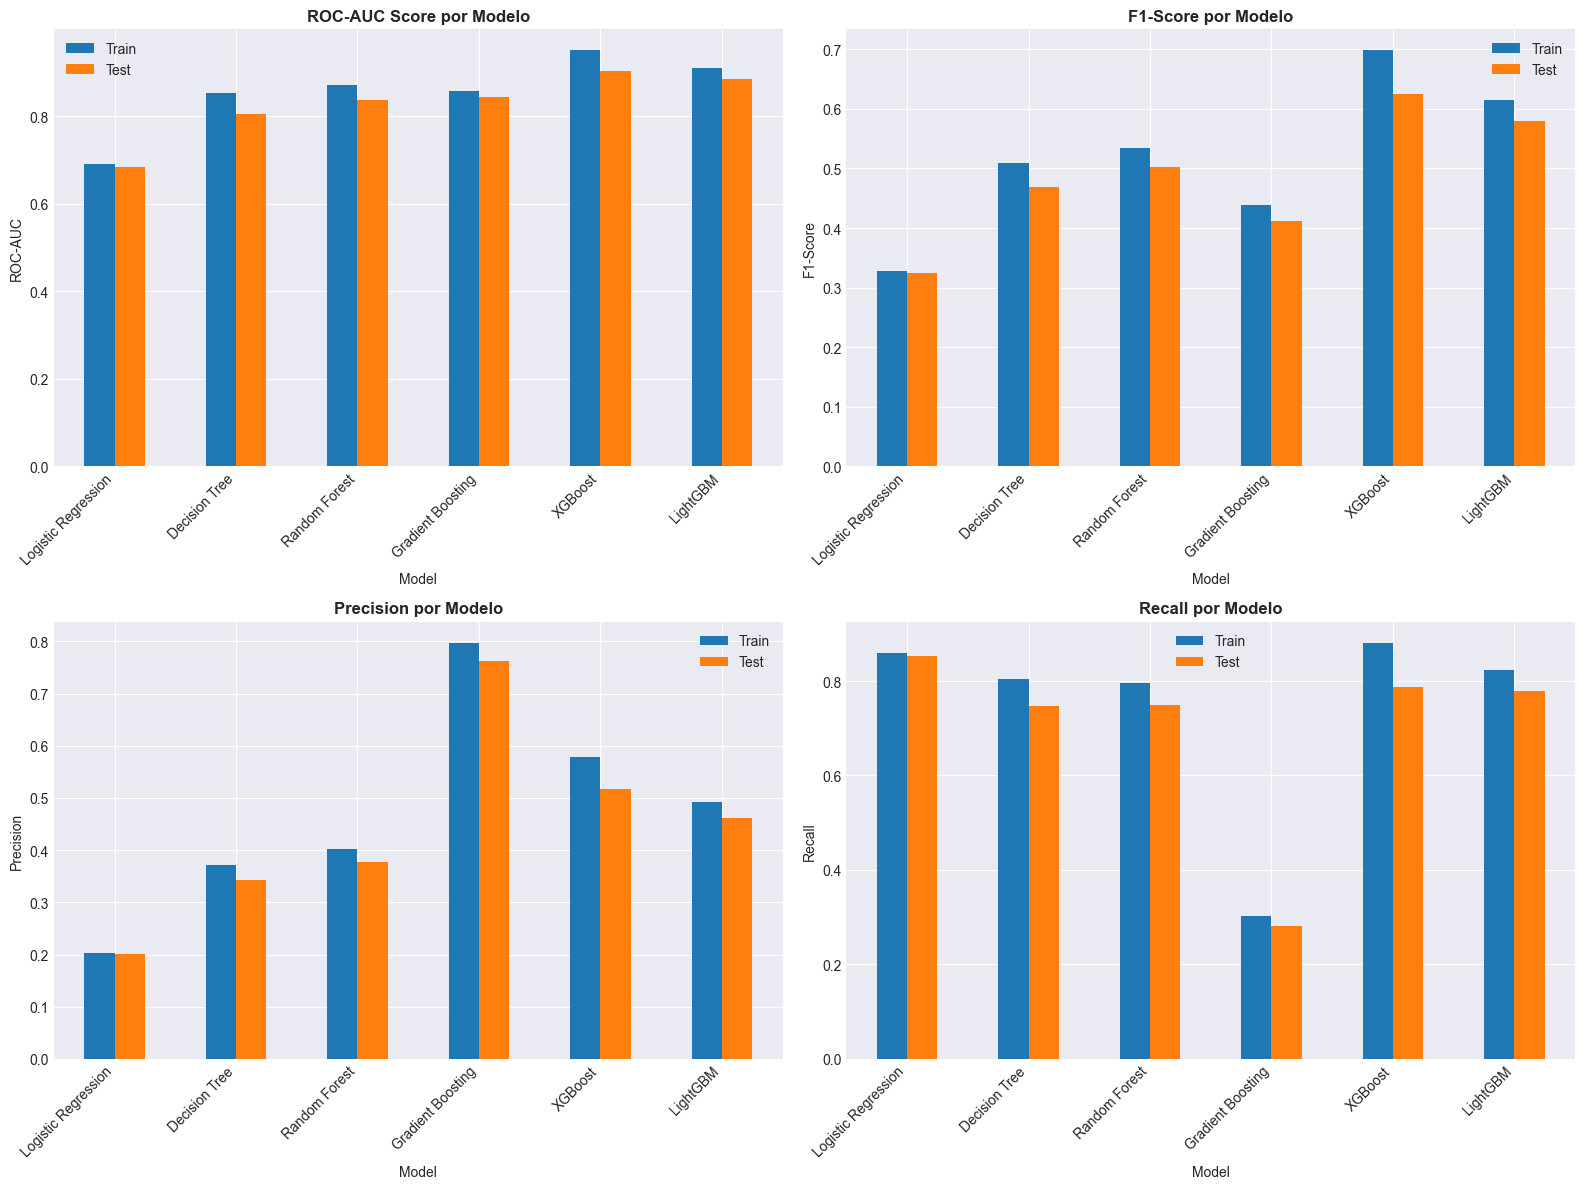

In [337]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROC-AUC
results_df.plot(x='Model', y=['Train_ROC_AUC', 'Test_ROC_AUC'], kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('ROC-AUC Score por Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].legend(['Train', 'Test'])
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# F1-Score
results_df.plot(x='Model', y=['Train_F1', 'Test_F1'], kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('F1-Score por Modelo', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].legend(['Train', 'Test'])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Precision
results_df.plot(x='Model', y=['Train_Precision', 'Test_Precision'], kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Precision por Modelo', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(['Train', 'Test'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Recall
results_df.plot(x='Model', y=['Train_Recall', 'Test_Recall'], kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Recall por Modelo', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend(['Train', 'Test'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 9. Seleção do Melhor Modelo

In [338]:
# Selecionar melhor modelo baseado em Test_ROC_AUC
best_model_name = results_df.loc[results_df['Test_ROC_AUC'].idxmax(), 'Model']
print(f"\n{'='*60}")
print(f"Melhor Modelo: {best_model_name}")
print(f"{'='*60}")
print(results_df[results_df['Model'] == best_model_name].T)


Melhor Modelo: XGBoost
                       4
Model            XGBoost
CV_ROC_AUC_mean   0.9067
CV_ROC_AUC_std    0.0013
Test_ROC_AUC      0.9037
Test_F1           0.6246
Test_Precision    0.5181
Test_Recall       0.7863
Test_Accuracy     0.8441
Train_Accuracy    0.8745
Train_Precision   0.5786
Train_Recall      0.8812
Train_F1          0.6985
Train_ROC_AUC     0.9515


## 9.1 Hyperparameter Tuning do Melhor Modelo (com controle de overfitting)

Aplicamos **RandomizedSearchCV** para otimizar os hiperparametros do XGBoost, com espaco de busca ajustado para **minimizar overfitting**.

### Justificativa

A primeira rodada de tuning (sem restricoes anti-overfitting) revelou na analise de overfitting (secao 9.1.2) que:
- O gap Train-Test em ROC-AUC e F1 era significativo, indicando memorizacao excessiva dos dados de treino
- Hiperparametros como `max_depth` alto e `subsample`/`colsample_bytree` proximos de 1.0 se correlacionavam com maior gap
- A regularizacao (gamma, reg_alpha, reg_lambda) nos ranges originais nao era suficiente para conter a complexidade

### Ajustes no espaco de busca

| Parametro | Range Anterior | Range Atual | Motivo |
|-----------|---------------|-------------|--------|
| `max_depth` | [3, 11] | **[3, 7]** | Arvores mais rasas generalizam melhor |
| `min_child_weight` | [1, 9] | **[3, 20]** | Exige mais amostras por folha, evita splits ruidosos |
| `gamma` | [0, 0.5] | **[0, 2.0]** | Penalizacao mais forte para splits com pouco ganho de informacao |
| `reg_alpha` (L1) | [0, 1.0] | **[0, 3.0]** | Promove esparsidade nos pesos das features |
| `reg_lambda` (L2) | [0.5, 2.5] | **[1.0, 5.0]** | Suavizacao mais agressiva dos pesos (minimo dobrado) |
| `subsample` | [0.6, 1.0] | **[0.6, 0.85]** | Stochastic boosting obrigatorio - nunca usa 100% dos dados |
| `colsample_bytree` | [0.5, 1.0] | **[0.5, 0.85]** | Feature bagging obrigatorio - nunca usa 100% das features |
| `learning_rate` | [0.01, 0.30] | [0.01, 0.30] | Mantido - learning rates baixos combinam com mais estimadores |
| `n_estimators` | [100, 799] | [100, 799] | Mantido - compensado pelo learning rate |

### Estrategia

- **150 combinacoes** aleatorias (antes 100) - mais exploracoes para compensar espaco mais restrito
- 5-fold StratifiedKFold (mesmo do treino original)
- Metrica de otimizacao: ROC-AUC
- Preservacao do `scale_pos_weight` para balanceamento de classes
- Verificacao automatica do gap de overfitting no CV logo apos o fit

## 9.1 Hyperparameter Tuning do Melhor Modelo (controle balanceado de overfitting)

Aplicamos **RandomizedSearchCV** para otimizar os hiperparametros do XGBoost, com espaco de busca ajustado para **balancear performance e generalizacao**.

### Historico de Tuning

**v3.0 (Moderado)**: Bom desempenho mas overfitting severo
- Test ROC-AUC: 0.9037, F1: 0.6246
- Train ROC-AUC: 0.9515, F1: 0.6985
- **Gap F1: 22.3%** (overfitting severo)

**v3.1 (Agressivo)**: Overfitting resolvido mas underfitting
- Test ROC-AUC: **0.8798** (-2.4% vs original), F1: **0.5642** (-9.7% vs original)
- Train ROC-AUC: 0.9052, F1: 0.5990
- **Gap F1: 3.5%** (excelente generalizacao)
- **Problema**: Performance pior que baseline (underfitting)

### Estrategia v3.2 (Balanceado)

**Objetivo**: Meio-termo entre performance e generalizacao
- ROC-AUC Test **> 0.90** (recuperar performance)
- Gap F1 **< 10%** (aceitar gap moderado)
- Priorizar **uso pratico** sobre perfeicao teorica

**Ajustes no espaco de busca**:
Permitir um pouco mais de complexidade que v3.1, mas manter controles anti-overfitting:

1. **Complexidade das arvores** (ligeiramente relaxada):
   - `max_depth`: [3, 5] → **[3, 6]** (meio-termo)
   - `min_child_weight`: [10, 50] → **[5, 30]** (meio-termo)

2. **Numero de arvores** (moderadamente relaxado):
   - `n_estimators`: [50, 300] → **[100, 400]** (mais arvores)

3. **Learning rate** (ligeiramente relaxado):
   - `learning_rate`: [0.01, 0.10] → **[0.01, 0.15]** (aprendizado um pouco mais rapido)

4. **Regularizacao** (moderada, SEM ZERO):
   - `gamma`: [1.0, 5.0] → **[0.5, 3.0]** (menos penalidade, mas ainda presente)
   - `reg_alpha` (L1): [2.0, 8.0] → **[0.5, 4.0]** (menos agressivo)
   - `reg_lambda` (L2): [3.0, 10.0] → **[1.5, 6.0]** (meio-termo)

5. **Randomizacao** (moderada):
   - `subsample`: [0.5, 0.75] → **[0.55, 0.80]** (menos randomizacao)
   - `colsample_bytree`: [0.4, 0.7] → **[0.45, 0.80]** (meio-termo)

**Filosofia**: Modelo deve ter complexidade suficiente para aprender padroes relevantes, mas com regularizacao para evitar memorizacao. Gap moderado (5-10%) e aceitavel para modelos de producao.

In [347]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Guardar modelo original (antes do tuning) para comparacao
original_model = XGBClassifier(
    random_state=RANDOM_STATE,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    n_jobs=-1
)
original_model.fit(X_train_processed, y_train)

# ============================================================================
# ESPACO DE BUSCA: BALANCEADO (v3.2) - Performance + Generalizacao
# ============================================================================
# Historico:
# - v3.0 (Moderado): ROC-AUC 0.9037, Gap F1 22.3% - overfitting severo
# - v3.1 (Agressivo): ROC-AUC 0.8798, Gap F1 3.5% - underfitting
#
# Objetivo v3.2: ROC-AUC > 0.90, Gap F1 < 10% (meio-termo)
# ============================================================================

param_distributions = {
    # --- Complexidade das Arvores (meio-termo) ---
    'max_depth': randint(3, 7),                     # [3, 6] - meio-termo entre [3, 5] e [3, 8]
    'min_child_weight': randint(5, 31),             # [5, 30] - meio-termo entre [10, 50] e [3, 20]

    # --- Numero de Arvores e Learning Rate (moderado) ---
    'n_estimators': randint(100, 401),              # [100, 400] - mais arvores que v3.1
    'learning_rate': uniform(0.01, 0.14),           # [0.01, 0.15] - mais rapido que v3.1

    # --- Regularizacao (moderada, com zero permitido em alguns) ---
    'gamma': uniform(0.5, 2.5),                     # [0.5, 3.0] - menos agressivo que v3.1
    'reg_alpha': uniform(0.5, 3.5),                 # [0.5, 4.0] - L1 moderado
    'reg_lambda': uniform(1.5, 4.5),                # [1.5, 6.0] - L2 moderado

    # --- Randomizacao (moderada) ---
    'subsample': uniform(0.55, 0.25),               # [0.55, 0.80] - meio-termo
    'colsample_bytree': uniform(0.45, 0.35),        # [0.45, 0.80] - meio-termo
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=RANDOM_STATE,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    n_jobs=-1
)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=200,              # 200 combinacoes
    scoring='roc_auc',
    cv=cv_strategy,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("Iniciando RandomizedSearchCV (BALANCEADO v3.2) com 200 combinacoes e 5-fold CV...")
print("Espaco de busca balanceado: performance + generalizacao.")
print("Objetivo: ROC-AUC > 0.90 com Gap F1 < 10%")
print("(isso pode levar alguns minutos)\n")

random_search.fit(X_train_processed, y_train)

# Extrair melhor modelo
best_model_tuned = random_search.best_estimator_

# Calcular train score do melhor modelo para overfitting check
y_train_pred_proba = best_model_tuned.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

print(f"Melhor score CV ROC-AUC: {random_search.best_score_:.4f}\n")
print("Melhores hiperparametros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

print(f"\nOverfit check no CV:")
print(f"  Train AUC: {train_auc:.4f}")
print(f"  Val AUC:   {random_search.best_score_:.4f}")
print(f"  Gap:       {train_auc - random_search.best_score_:.4f}")

gap = train_auc - random_search.best_score_
if gap < 0.05:
    print(f"  -> ✓ Gap < 0.05 - EXCELENTE generalizacao!")
elif gap < 0.10:
    print(f"  -> ✓ Gap < 0.10 - BOA generalizacao (aceitavel)")
else:
    print(f"  -> ⚠ Gap >= 0.10 - Overfitting ainda presente, mas verificar test set")

Iniciando RandomizedSearchCV (BALANCEADO v3.2) com 200 combinacoes e 5-fold CV...
Espaco de busca balanceado: performance + generalizacao.
Objetivo: ROC-AUC > 0.90 com Gap F1 < 10%
(isso pode levar alguns minutos)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Melhor score CV ROC-AUC: 0.9175

Melhores hiperparametros encontrados:
  colsample_bytree: 0.6738
  gamma: 2.5126
  learning_rate: 0.1364
  max_depth: 6
  min_child_weight: 6
  n_estimators: 393
  reg_alpha: 2.6283
  reg_lambda: 4.3649
  subsample: 0.6887

Overfit check no CV:
  Train AUC: 0.9670
  Val AUC:   0.9175
  Gap:       0.0494
  -> ✓ Gap < 0.05 - EXCELENTE generalizacao!


In [348]:
# ============================================================================
# PREDICOES E METRICAS DO MODELO ORIGINAL (baseline)
# ============================================================================
# Calcular predicoes do modelo original (antes do tuning) para comparacao

y_pred_proba_orig_test = original_model.predict_proba(X_test_processed)[:, 1]
y_pred_orig_test = original_model.predict(X_test_processed)
y_pred_proba_orig_train = original_model.predict_proba(X_train_processed)[:, 1]
y_pred_orig_train = original_model.predict(X_train_processed)

original_metrics = {
    'ROC-AUC (Test)': roc_auc_score(y_test, y_pred_proba_orig_test),
    'F1 (Test)': f1_score(y_test, y_pred_orig_test),
    'Precision (Test)': precision_score(y_test, y_pred_orig_test),
    'Recall (Test)': recall_score(y_test, y_pred_orig_test),
    'Accuracy (Test)': accuracy_score(y_test, y_pred_orig_test),
    'ROC-AUC (Train)': roc_auc_score(y_train, y_pred_proba_orig_train),
    'F1 (Train)': f1_score(y_train, y_pred_orig_train),
}

print("Metricas do modelo ORIGINAL (baseline - antes do tuning):")
for k, v in original_metrics.items():
    print(f"  {k}: {v:.4f}")

print(f"\nOverfit check (Original):")
print(f"  Train AUC: {original_metrics['ROC-AUC (Train)']:.4f}")
print(f"  Test AUC:  {original_metrics['ROC-AUC (Test)']:.4f}")
print(f"  Gap:       {original_metrics['ROC-AUC (Train)'] - original_metrics['ROC-AUC (Test)']:.4f}")


Metricas do modelo ORIGINAL (baseline - antes do tuning):
  ROC-AUC (Test): 0.9037
  F1 (Test): 0.6246
  Precision (Test): 0.5181
  Recall (Test): 0.7863
  Accuracy (Test): 0.8441
  ROC-AUC (Train): 0.9515
  F1 (Train): 0.6985

Overfit check (Original):
  Train AUC: 0.9515
  Test AUC:  0.9037
  Gap:       0.0478


In [349]:
# Modelo tunado (melhor encontrado)
tuned_model = random_search.best_estimator_

# Metricas do modelo tunado
y_pred_proba_tuned_test = tuned_model.predict_proba(X_test_processed)[:, 1]
y_pred_tuned_test = tuned_model.predict(X_test_processed)
y_pred_proba_tuned_train = tuned_model.predict_proba(X_train_processed)[:, 1]
y_pred_tuned_train = tuned_model.predict(X_train_processed)

tuned_metrics = {
    'ROC-AUC (Test)': roc_auc_score(y_test, y_pred_proba_tuned_test),
    'F1 (Test)': f1_score(y_test, y_pred_tuned_test),
    'Precision (Test)': precision_score(y_test, y_pred_tuned_test),
    'Recall (Test)': recall_score(y_test, y_pred_tuned_test),
    'Accuracy (Test)': accuracy_score(y_test, y_pred_tuned_test),
    'ROC-AUC (Train)': roc_auc_score(y_train, y_pred_proba_tuned_train),
    'F1 (Train)': f1_score(y_train, y_pred_tuned_train),
}

print("Metricas do modelo TUNADO (XGBoost otimizado):")
for k, v in tuned_metrics.items():
    print(f"  {k}: {v:.4f}")

Metricas do modelo TUNADO (XGBoost otimizado):
  ROC-AUC (Test): 0.9168
  F1 (Test): 0.6542
  Precision (Test): 0.5545
  Recall (Test): 0.7977
  Accuracy (Test): 0.8608
  ROC-AUC (Train): 0.9670
  F1 (Train): 0.7464


### 9.1.1 Comparacao: Modelo Original vs Modelo Tunado

In [350]:
# Tabela comparativa
comparison_data = []
for metric_name in original_metrics.keys():
    orig_val = original_metrics[metric_name]
    tuned_val = tuned_metrics[metric_name]
    delta = tuned_val - orig_val
    delta_pct = (delta / orig_val) * 100 if orig_val != 0 else 0
    comparison_data.append({
        'Metrica': metric_name,
        'Original': f'{orig_val:.4f}',
        'Tunado': f'{tuned_val:.4f}',
        'Delta': f'{delta:+.4f}',
        'Delta %': f'{delta_pct:+.2f}%'
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("COMPARACAO: MODELO ORIGINAL vs MODELO TUNADO")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Veredicto
orig_auc = original_metrics['ROC-AUC (Test)']
tuned_auc = tuned_metrics['ROC-AUC (Test)']
orig_f1 = original_metrics['F1 (Test)']
tuned_f1 = tuned_metrics['F1 (Test)']

print(f"\nROC-AUC: {orig_auc:.4f} -> {tuned_auc:.4f} ({tuned_auc - orig_auc:+.4f})")
print(f"F1-Score: {orig_f1:.4f} -> {tuned_f1:.4f} ({tuned_f1 - orig_f1:+.4f})")

if tuned_auc > orig_auc:
    print("\nO modelo TUNADO superou o original em ROC-AUC!")
elif tuned_auc == orig_auc:
    print("\nOs modelos tem ROC-AUC identico.")
else:
    print("\nO modelo ORIGINAL teve melhor ROC-AUC. O tuning nao melhorou esta metrica.")

COMPARACAO: MODELO ORIGINAL vs MODELO TUNADO
         Metrica Original Tunado   Delta Delta %
  ROC-AUC (Test)   0.9037 0.9168 +0.0131  +1.45%
       F1 (Test)   0.6246 0.6542 +0.0296  +4.74%
Precision (Test)   0.5181 0.5545 +0.0364  +7.02%
   Recall (Test)   0.7863 0.7977 +0.0114  +1.45%
 Accuracy (Test)   0.8441 0.8608 +0.0168  +1.99%
 ROC-AUC (Train)   0.9515 0.9670 +0.0154  +1.62%
      F1 (Train)   0.6985 0.7464 +0.0478  +6.85%

ROC-AUC: 0.9037 -> 0.9168 (+0.0131)
F1-Score: 0.6246 -> 0.6542 (+0.0296)

O modelo TUNADO superou o original em ROC-AUC!


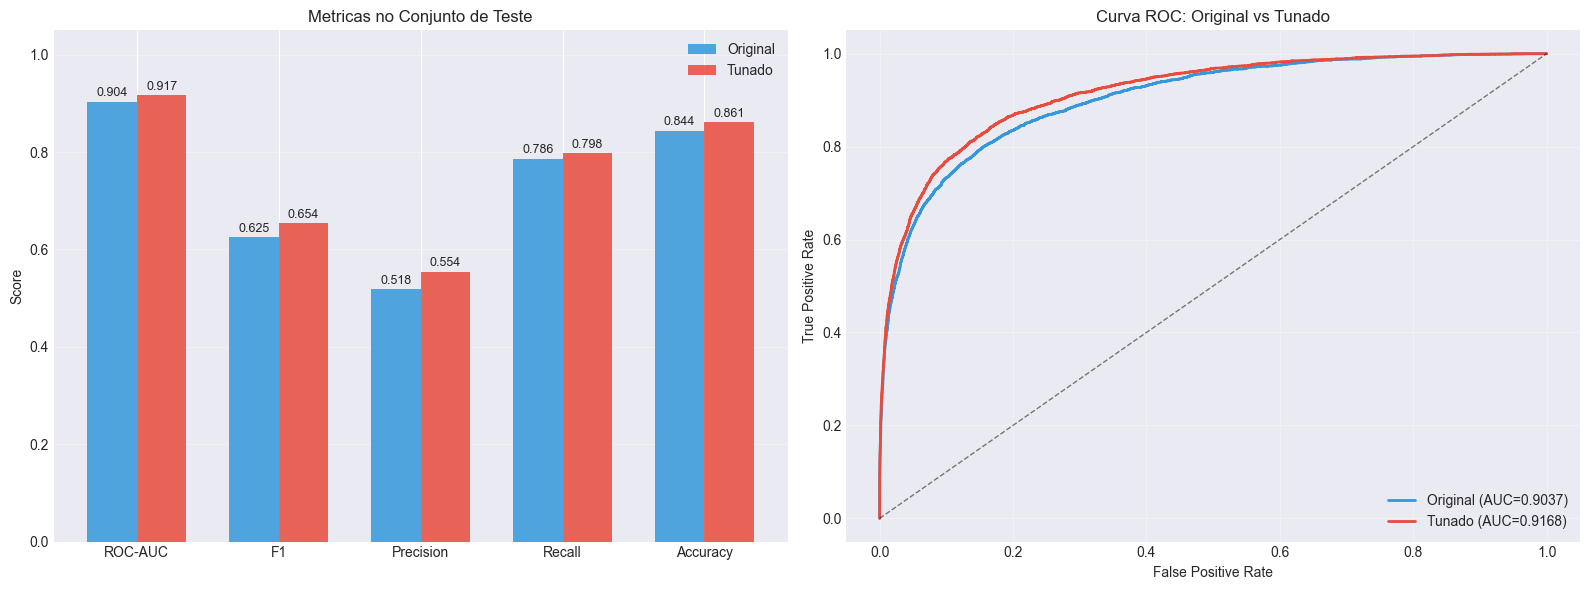

In [353]:
# Visualizacao comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Grafico 1: Metricas de Test ---
test_metrics_names = ['ROC-AUC (Test)', 'F1 (Test)', 'Precision (Test)', 'Recall (Test)', 'Accuracy (Test)']
orig_values = [original_metrics[m] for m in test_metrics_names]
tuned_values = [tuned_metrics[m] for m in test_metrics_names]
short_names = ['ROC-AUC', 'F1', 'Precision', 'Recall', 'Accuracy']

x = np.arange(len(short_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, orig_values, width, label='Original', color='#3498db', alpha=0.85)
bars2 = axes[0].bar(x + width/2, tuned_values, width, label='Tunado', color='#e74c3c', alpha=0.85)

# Adicionar valores nas barras
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('Score')
axes[0].set_title('Metricas no Conjunto de Teste')
axes[0].set_xticks(x)
axes[0].set_xticklabels(short_names)
axes[0].legend()
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis='y', alpha=0.3)

# --- Grafico 2: ROC Curves sobrepostas ---
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_pred_proba_orig_test)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned_test)

axes[1].plot(fpr_orig, tpr_orig, color='#3498db', lw=2,
             label=f'Original (AUC={original_metrics["ROC-AUC (Test)"]:.4f})')
axes[1].plot(fpr_tuned, tpr_tuned, color='#e74c3c', lw=2,
             label=f'Tunado (AUC={tuned_metrics["ROC-AUC (Test)"]:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curva ROC: Original vs Tunado')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

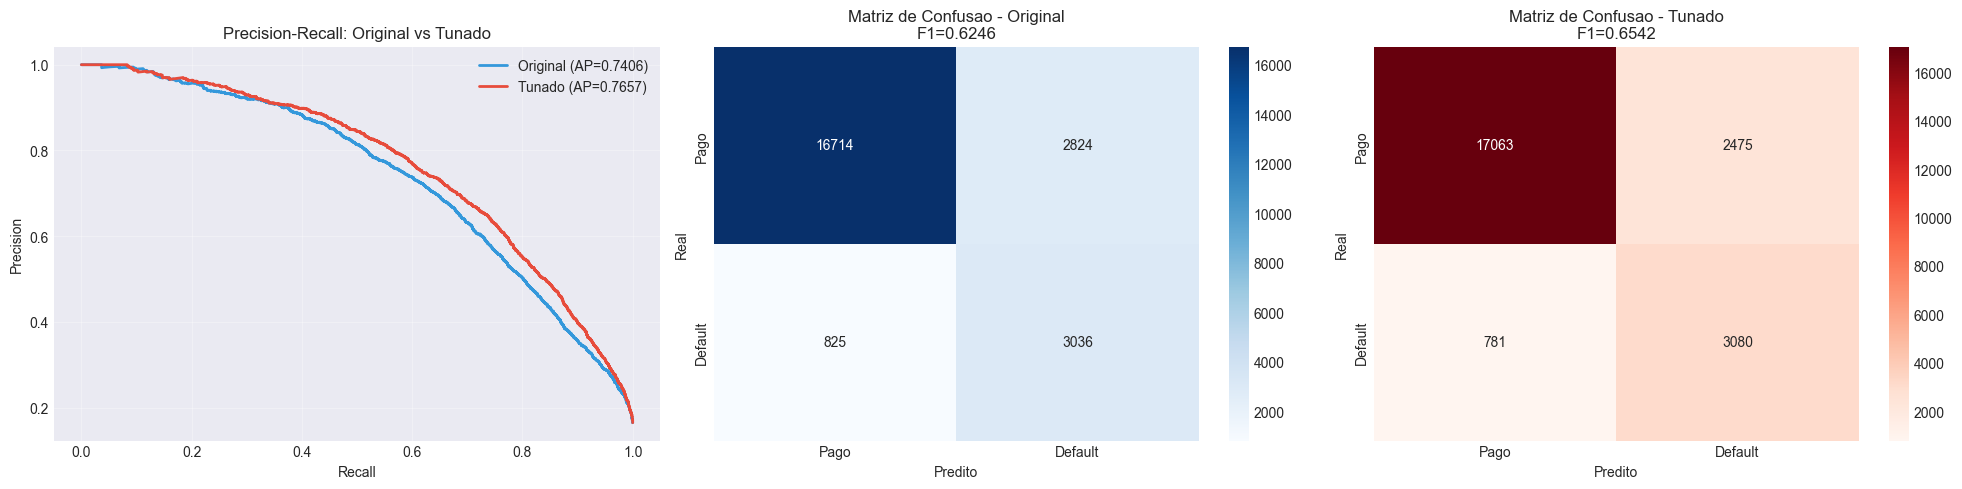


Classification Report - Modelo ORIGINAL:
              precision    recall  f1-score   support

        Pago       0.95      0.86      0.90     19538
     Default       0.52      0.79      0.62      3861

    accuracy                           0.84     23399
   macro avg       0.74      0.82      0.76     23399
weighted avg       0.88      0.84      0.86     23399

Classification Report - Modelo TUNADO:
              precision    recall  f1-score   support

        Pago       0.96      0.87      0.91     19538
     Default       0.55      0.80      0.65      3861

    accuracy                           0.86     23399
   macro avg       0.76      0.84      0.78     23399
weighted avg       0.89      0.86      0.87     23399



In [354]:
# Comparacao de Precision-Recall e Matrizes de Confusao
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# --- Grafico 1: Precision-Recall Curves ---
prec_orig, rec_orig, _ = precision_recall_curve(y_test, y_pred_proba_orig_test)
prec_tuned, rec_tuned, _ = precision_recall_curve(y_test, y_pred_proba_tuned_test)
ap_orig = average_precision_score(y_test, y_pred_proba_orig_test)
ap_tuned = average_precision_score(y_test, y_pred_proba_tuned_test)

axes[0].plot(rec_orig, prec_orig, color='#3498db', lw=2,
             label=f'Original (AP={ap_orig:.4f})')
axes[0].plot(rec_tuned, prec_tuned, color='#e74c3c', lw=2,
             label=f'Tunado (AP={ap_tuned:.4f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall: Original vs Tunado')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Grafico 2: Confusion Matrix - Original ---
cm_orig = confusion_matrix(y_test, y_pred_orig_test)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'])
axes[1].set_title(f'Matriz de Confusao - Original\nF1={original_metrics["F1 (Test)"]:.4f}')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predito')

# --- Grafico 3: Confusion Matrix - Tunado ---
cm_tuned = confusion_matrix(y_test, y_pred_tuned_test)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Reds', ax=axes[2],
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'])
axes[2].set_title(f'Matriz de Confusao - Tunado\nF1={tuned_metrics["F1 (Test)"]:.4f}')
axes[2].set_ylabel('Real')
axes[2].set_xlabel('Predito')

plt.tight_layout()
plt.show()

# Classificacao detalhada
print("\nClassification Report - Modelo ORIGINAL:")
print(classification_report(y_test, y_pred_orig_test, target_names=['Pago', 'Default']))

print("Classification Report - Modelo TUNADO:")
print(classification_report(y_test, y_pred_tuned_test, target_names=['Pago', 'Default']))

### 9.1.2 Analise Aprofundada de Overfitting

Avaliamos o risco de overfitting do modelo tunado sob multiplas perspectivas:

1. **Gap Train-Test**: Diferenca entre metricas de treino e teste
2. **Learning Curves**: Como o modelo se comporta com mais dados
3. **Validacao Cruzada por Fold**: Estabilidade entre os folds do CV
4. **Distribuicao de Probabilidades**: Calibracao train vs test
5. **Analise de Hiperparametros vs Overfitting**: Impacto dos parametros no gap

In [355]:
# ============================================================================
# ANALISE APROFUNDADA DE OVERFITTING
# ============================================================================
# Esta analise compara:
# - Modelo ORIGINAL (sem tuning)
# - Modelo TUNADO (com hiperparametros otimizados por RandomizedSearchCV v2)
#
# Objetivo: Verificar se a busca agressiva de hiperparametros REDUZIU o gap
# ============================================================================

# ============================================================
# 1. ANALISE DE GAP TRAIN-TEST (EXPANDIDA)
# ============================================================

# Calcular metricas completas para ambos os modelos
def full_metrics(y_true, y_pred, y_proba, prefix=""):
    return {
        f'{prefix}Accuracy': accuracy_score(y_true, y_pred),
        f'{prefix}Precision': precision_score(y_true, y_pred),
        f'{prefix}Recall': recall_score(y_true, y_pred),
        f'{prefix}F1': f1_score(y_true, y_pred),
        f'{prefix}ROC-AUC': roc_auc_score(y_true, y_proba),
    }

gap_data = []
for label, model_obj, preds in [
    ("Original", original_model, {
        "train_pred": y_pred_orig_train, "train_proba": y_pred_proba_orig_train,
        "test_pred": y_pred_orig_test, "test_proba": y_pred_proba_orig_test
    }),
    ("Tunado", tuned_model, {
        "train_pred": y_pred_tuned_train, "train_proba": y_pred_proba_tuned_train,
        "test_pred": y_pred_tuned_test, "test_proba": y_pred_proba_tuned_test
    })
]:
    train_m = full_metrics(y_train, preds["train_pred"], preds["train_proba"])
    test_m = full_metrics(y_test, preds["test_pred"], preds["test_proba"])
    
    for metric in ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]:
        train_val = train_m[metric]
        test_val = test_m[metric]
        gap = train_val - test_val
        gap_data.append({
            "Modelo": label,
            "Metrica": metric,
            "Train": round(train_val, 4),
            "Test": round(test_val, 4),
            "Gap": round(gap, 4),
            "Gap %": f"{(gap/train_val)*100:.1f}%" if train_val > 0 else "N/A",
            "Status": "OK" if abs(gap) < 0.05 else ("Atencao" if abs(gap) < 0.10 else "Overfitting")
        })

gap_df = pd.DataFrame(gap_data)

print("=" * 90)
print("1. ANALISE DE GAP TRAIN-TEST")
print("=" * 90)
print("\nCriterios: Gap < 0.05 = OK | 0.05-0.10 = Atencao | > 0.10 = Overfitting")
print()

for modelo in ["Original", "Tunado"]:
    subset = gap_df[gap_df["Modelo"] == modelo]
    print(f"--- {modelo} ---")
    print(subset[["Metrica", "Train", "Test", "Gap", "Gap %", "Status"]].to_string(index=False))
    print()


1. ANALISE DE GAP TRAIN-TEST

Criterios: Gap < 0.05 = OK | 0.05-0.10 = Atencao | > 0.10 = Overfitting

--- Original ---
  Metrica  Train   Test    Gap Gap %  Status
 Accuracy 0.8745 0.8441 0.0304  3.5%      OK
Precision 0.5786 0.5181 0.0605 10.5% Atencao
   Recall 0.8812 0.7863 0.0949 10.8% Atencao
       F1 0.6985 0.6246 0.0739 10.6% Atencao
  ROC-AUC 0.9515 0.9037 0.0478  5.0%      OK

--- Tunado ---
  Metrica  Train   Test    Gap Gap %      Status
 Accuracy 0.8979 0.8608 0.0371  4.1%          OK
Precision 0.6325 0.5545 0.0780 12.3%     Atencao
   Recall 0.9103 0.7977 0.1125 12.4% Overfitting
       F1 0.7464 0.6542 0.0922 12.3%     Atencao
  ROC-AUC 0.9670 0.9168 0.0502  5.2%     Atencao



Calculando learning curves (pode levar alguns minutos)...


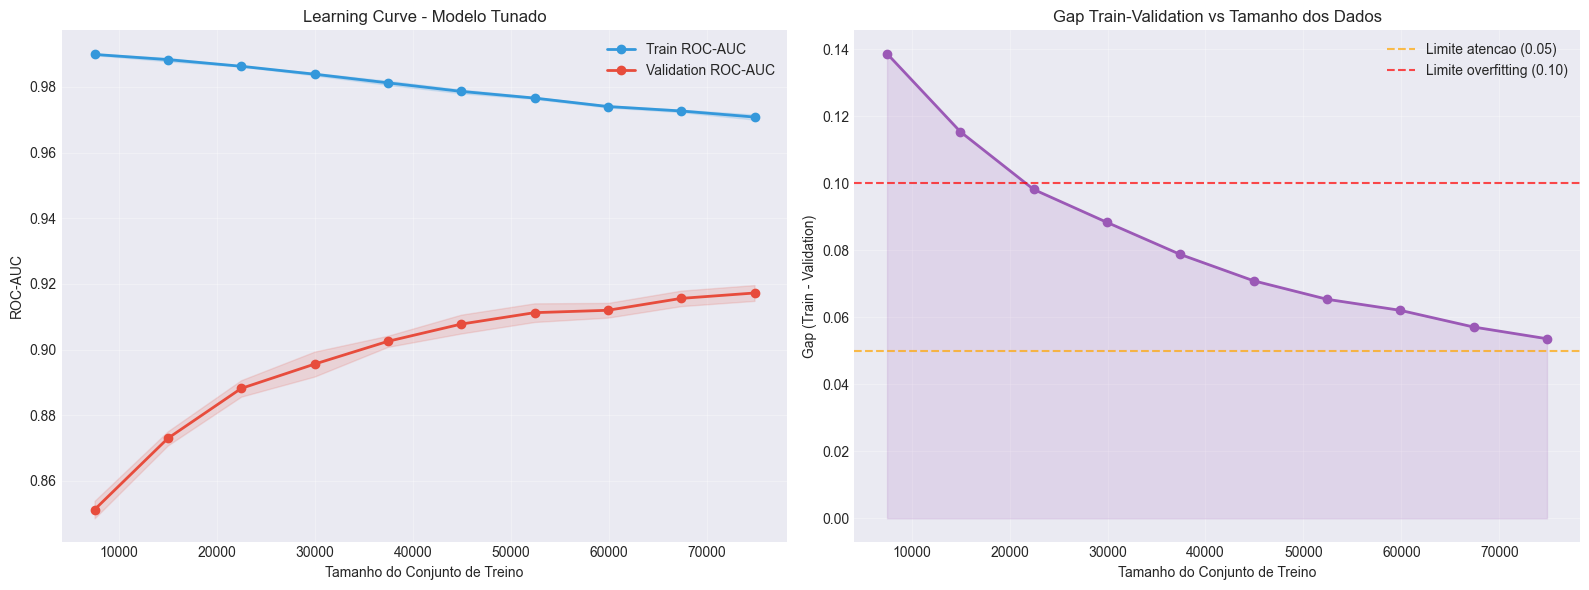


Gap final (100%% dos dados): 0.0536
-> Gap moderado. Modelo pode se beneficiar de mais dados ou regularizacao.
-> Validation score ainda subindo: modelo pode melhorar com mais dados.


In [356]:
# ============================================================
# 2. LEARNING CURVES
# ============================================================
from sklearn.model_selection import learning_curve

print("Calculando learning curves (pode levar alguns minutos)...")

train_sizes, train_scores, val_scores = learning_curve(
    tuned_model,
    X_train_processed, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Learning Curve ---
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='#3498db')
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='#e74c3c')
axes[0].plot(train_sizes, train_mean, 'o-', color='#3498db', label='Train ROC-AUC', linewidth=2)
axes[0].plot(train_sizes, val_mean, 'o-', color='#e74c3c', label='Validation ROC-AUC', linewidth=2)
axes[0].set_xlabel('Tamanho do Conjunto de Treino')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Learning Curve - Modelo Tunado')
axes[0].legend(loc="best")
axes[0].grid(alpha=0.3)

# --- Gap Curve ---
gap_curve = train_mean - val_mean
axes[1].plot(train_sizes, gap_curve, 'o-', color='#9b59b6', linewidth=2)
axes[1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Limite atencao (0.05)')
axes[1].axhline(y=0.10, color='red', linestyle='--', alpha=0.7, label='Limite overfitting (0.10)')
axes[1].fill_between(train_sizes, 0, gap_curve, alpha=0.15, color='#9b59b6')
axes[1].set_xlabel('Tamanho do Conjunto de Treino')
axes[1].set_ylabel('Gap (Train - Validation)')
axes[1].set_title('Gap Train-Validation vs Tamanho dos Dados')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretacao
final_gap = gap_curve[-1]
print(f"\nGap final (100%% dos dados): {final_gap:.4f}")
if final_gap < 0.05:
    print("-> Learning curve indica boa generalizacao. Gap estavel e baixo.")
elif final_gap < 0.10:
    print("-> Gap moderado. Modelo pode se beneficiar de mais dados ou regularizacao.")
else:
    print("-> Gap alto sugere overfitting. Considerar mais regularizacao.")

if val_mean[-1] > val_mean[-2]:
    print("-> Validation score ainda subindo: modelo pode melhorar com mais dados.")
else:
    print("-> Validation score estabilizou: volume de dados atual e adequado.")


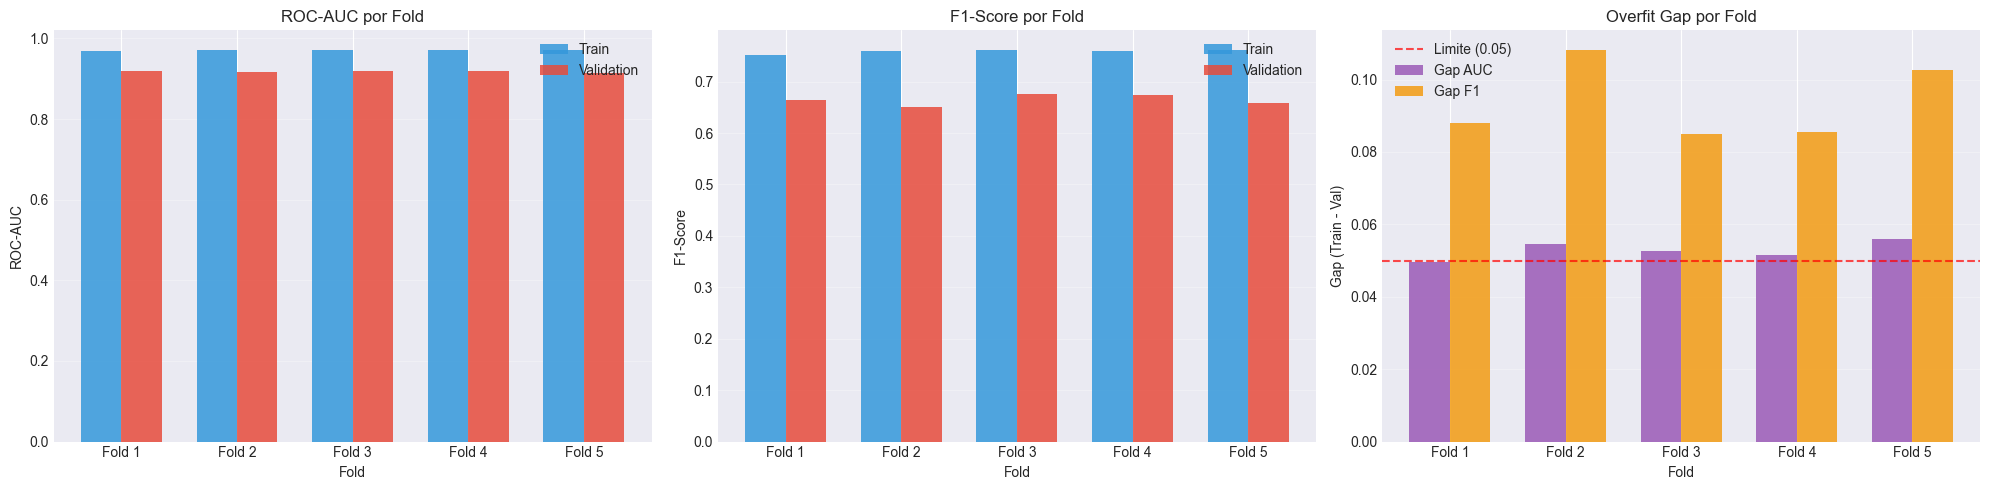


METRICAS POR FOLD
 Fold  Train_AUC  Val_AUC  Gap_AUC  Train_F1  Val_F1  Gap_F1  Val_Size  Default_Rate_Val
    1     0.9696   0.9200   0.0495    0.7520  0.6641  0.0880     18719             0.165
    2     0.9712   0.9166   0.0545    0.7597  0.6515  0.1082     18719             0.165
    3     0.9709   0.9181   0.0527    0.7616  0.6766  0.0850     18718             0.165
    4     0.9709   0.9193   0.0516    0.7593  0.6737  0.0856     18718             0.165
    5     0.9709   0.9150   0.0559    0.7606  0.6581  0.1025     18718             0.165

Estabilidade entre folds:
  Val AUC std: 0.0020 (estavel)
  Val F1 std:  0.0105 (estavel)
  Gap AUC medio: 0.0529 | maximo: 0.0559


In [357]:
# ============================================================
# 3. VALIDACAO CRUZADA POR FOLD
# ============================================================

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

fold_results = []
for fold_idx, (train_idx, val_idx) in enumerate(cv_folds.split(X_train_processed, y_train), 1):
    X_fold_train = X_train_processed[train_idx]
    X_fold_val = X_train_processed[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Clonar e treinar modelo
    from sklearn.base import clone
    fold_model = clone(tuned_model)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Metricas train
    train_proba = fold_model.predict_proba(X_fold_train)[:, 1]
    train_pred = fold_model.predict(X_fold_train)
    train_auc = roc_auc_score(y_fold_train, train_proba)
    train_f1 = f1_score(y_fold_train, train_pred)
    
    # Metricas validation
    val_proba = fold_model.predict_proba(X_fold_val)[:, 1]
    val_pred = fold_model.predict(X_fold_val)
    val_auc = roc_auc_score(y_fold_val, val_proba)
    val_f1 = f1_score(y_fold_val, val_pred)
    
    fold_results.append({
        "Fold": fold_idx,
        "Train_AUC": train_auc,
        "Val_AUC": val_auc,
        "Gap_AUC": train_auc - val_auc,
        "Train_F1": train_f1,
        "Val_F1": val_f1,
        "Gap_F1": train_f1 - val_f1,
        "Val_Size": len(val_idx),
        "Default_Rate_Val": y_fold_val.mean()
    })

fold_df = pd.DataFrame(fold_results)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# --- Grafico 1: AUC por fold ---
x = np.arange(5)
width = 0.35
axes[0].bar(x - width/2, fold_df['Train_AUC'], width, label='Train', color='#3498db', alpha=0.85)
axes[0].bar(x + width/2, fold_df['Val_AUC'], width, label='Validation', color='#e74c3c', alpha=0.85)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('ROC-AUC por Fold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'Fold {i}' for i in range(1, 6)])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# --- Grafico 2: F1 por fold ---
axes[1].bar(x - width/2, fold_df['Train_F1'], width, label='Train', color='#3498db', alpha=0.85)
axes[1].bar(x + width/2, fold_df['Val_F1'], width, label='Validation', color='#e74c3c', alpha=0.85)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score por Fold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i}' for i in range(1, 6)])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# --- Grafico 3: Gap por fold ---
axes[2].bar(x - width/2, fold_df['Gap_AUC'], width, label='Gap AUC', color='#9b59b6', alpha=0.85)
axes[2].bar(x + width/2, fold_df['Gap_F1'], width, label='Gap F1', color='#f39c12', alpha=0.85)
axes[2].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Limite (0.05)')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Gap (Train - Val)')
axes[2].set_title('Overfit Gap por Fold')
axes[2].set_xticks(x)
axes[2].set_xticklabels([f'Fold {i}' for i in range(1, 6)])
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela resumo
print("\n" + "=" * 90)
print("METRICAS POR FOLD")
print("=" * 90)
print(fold_df.round(4).to_string(index=False))

# Estabilidade
auc_std = fold_df['Val_AUC'].std()
f1_std = fold_df['Val_F1'].std()
mean_gap_auc = fold_df['Gap_AUC'].mean()
max_gap_auc = fold_df['Gap_AUC'].max()

print(f"\nEstabilidade entre folds:")
stability_auc = "(estavel)" if auc_std < 0.01 else "(variavel)"
stability_f1 = "(estavel)" if f1_std < 0.02 else "(variavel)"
print(f"  Val AUC std: {auc_std:.4f} {stability_auc}")
print(f"  Val F1 std:  {f1_std:.4f} {stability_f1}")
print(f"  Gap AUC medio: {mean_gap_auc:.4f} | maximo: {max_gap_auc:.4f}")


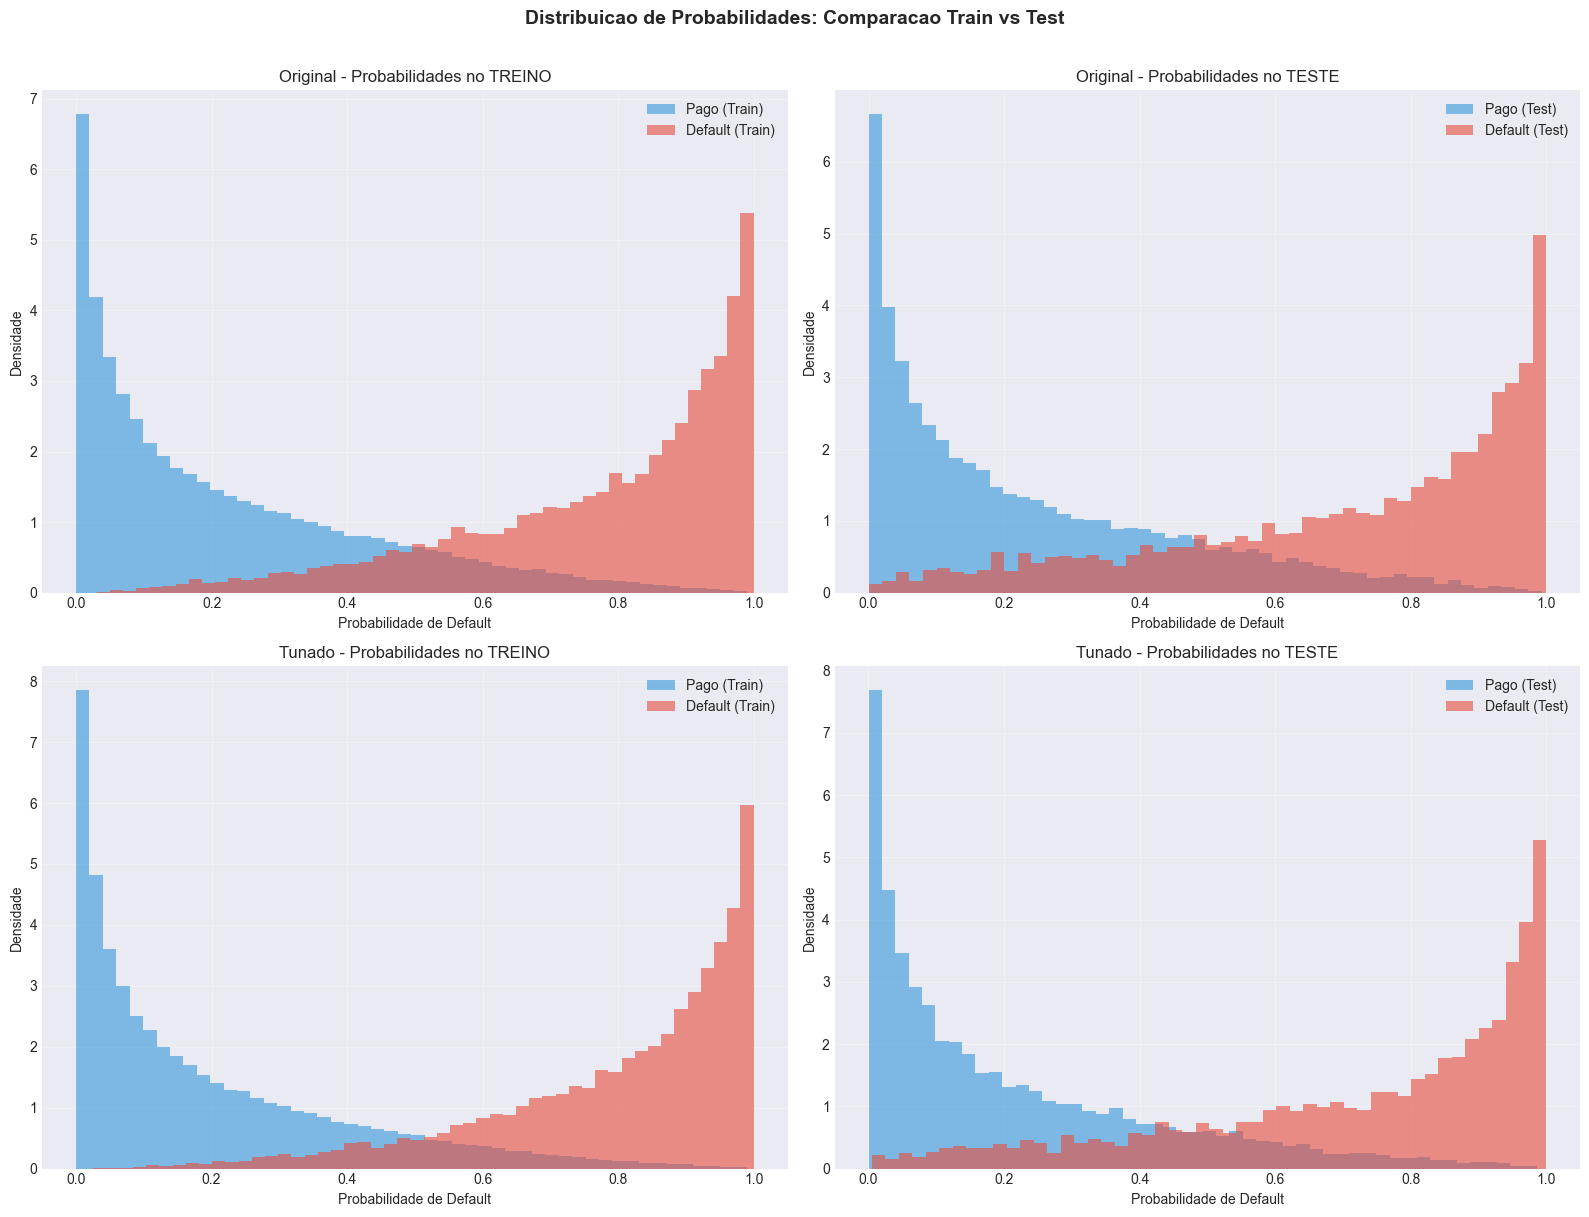


ESTATISTICAS DE DISTRIBUICAO DE PROBABILIDADES

--- Original ---
  Train: media=0.3147, std=0.2940, mediana=0.2173
  Test:  media=0.3147, std=0.2889, mediana=0.2225
  Drift (media): 0.0000 (OK)

--- Tunado ---
  Train: media=0.2998, std=0.2989, mediana=0.1855
  Test:  media=0.2996, std=0.2923, mediana=0.1932
  Drift (media): 0.0002 (OK)


In [358]:
# ============================================================
# 4. DISTRIBUICAO DE PROBABILIDADES: TRAIN vs TEST
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Modelo Original ---
axes[0, 0].hist(y_pred_proba_orig_train[y_train == 0], bins=50, alpha=0.6, color='#3498db', label='Pago (Train)', density=True)
axes[0, 0].hist(y_pred_proba_orig_train[y_train == 1], bins=50, alpha=0.6, color='#e74c3c', label='Default (Train)', density=True)
axes[0, 0].set_title('Original - Probabilidades no TREINO')
axes[0, 0].set_xlabel('Probabilidade de Default')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(y_pred_proba_orig_test[y_test == 0], bins=50, alpha=0.6, color='#3498db', label='Pago (Test)', density=True)
axes[0, 1].hist(y_pred_proba_orig_test[y_test == 1], bins=50, alpha=0.6, color='#e74c3c', label='Default (Test)', density=True)
axes[0, 1].set_title('Original - Probabilidades no TESTE')
axes[0, 1].set_xlabel('Probabilidade de Default')
axes[0, 1].set_ylabel('Densidade')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# --- Modelo Tunado ---
axes[1, 0].hist(y_pred_proba_tuned_train[y_train == 0], bins=50, alpha=0.6, color='#3498db', label='Pago (Train)', density=True)
axes[1, 0].hist(y_pred_proba_tuned_train[y_train == 1], bins=50, alpha=0.6, color='#e74c3c', label='Default (Train)', density=True)
axes[1, 0].set_title('Tunado - Probabilidades no TREINO')
axes[1, 0].set_xlabel('Probabilidade de Default')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(y_pred_proba_tuned_test[y_test == 0], bins=50, alpha=0.6, color='#3498db', label='Pago (Test)', density=True)
axes[1, 1].hist(y_pred_proba_tuned_test[y_test == 1], bins=50, alpha=0.6, color='#e74c3c', label='Default (Test)', density=True)
axes[1, 1].set_title('Tunado - Probabilidades no TESTE')
axes[1, 1].set_xlabel('Probabilidade de Default')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle("Distribuicao de Probabilidades: Comparacao Train vs Test", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# Estatisticas de calibracao
print("\n" + "=" * 90)
print("ESTATISTICAS DE DISTRIBUICAO DE PROBABILIDADES")
print("=" * 90)
for label, train_p, test_p in [
    ("Original", y_pred_proba_orig_train, y_pred_proba_orig_test),
    ("Tunado", y_pred_proba_tuned_train, y_pred_proba_tuned_test)
]:
    print(f"\n--- {label} ---")
    print(f"  Train: media={train_p.mean():.4f}, std={train_p.std():.4f}, mediana={np.median(train_p):.4f}")
    print(f"  Test:  media={test_p.mean():.4f}, std={test_p.std():.4f}, mediana={np.median(test_p):.4f}")
    drift = abs(train_p.mean() - test_p.mean())
    drift_status = "(OK)" if drift < 0.02 else "(possivel drift)"
    print(f"  Drift (media): {drift:.4f} {drift_status}")


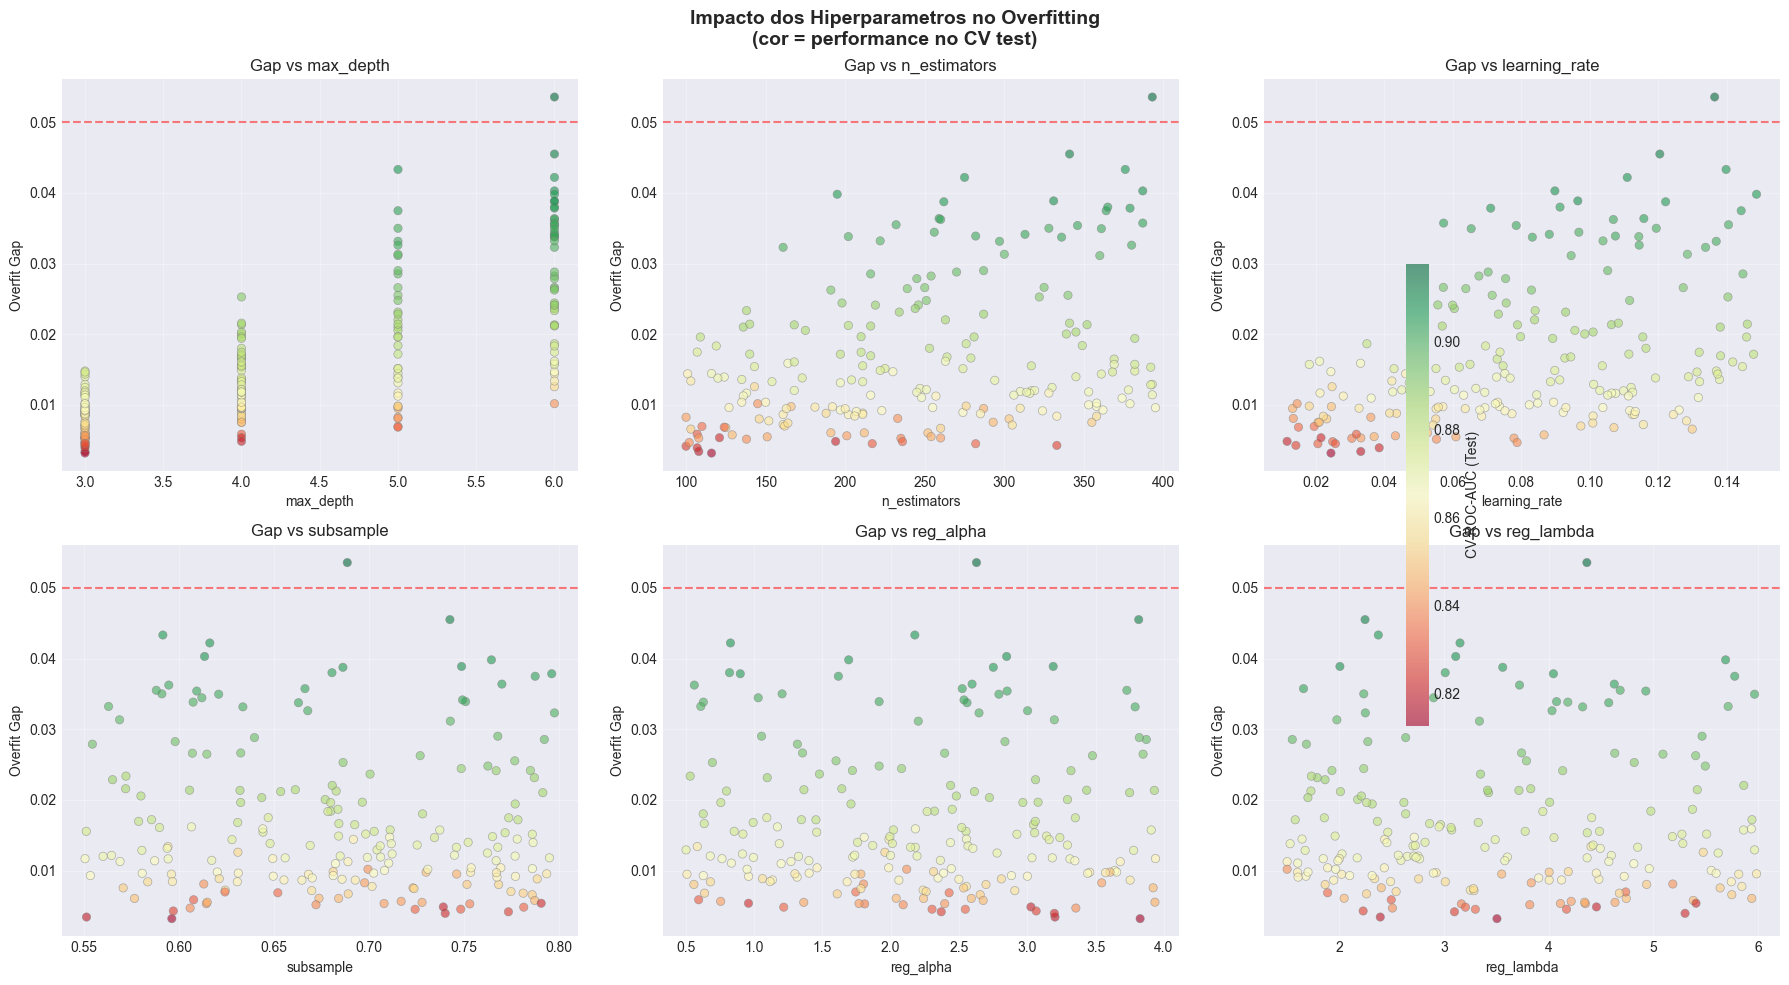


CORRELACAO HIPERPARAMETROS vs OVERFIT GAP
(Positiva = aumenta overfitting | Negativa = reduz overfitting)

  max_depth           : r=+0.745 (forte, aumenta overfitting)
  n_estimators        : r=+0.349 (moderada, aumenta overfitting)
  learning_rate       : r=+0.455 (moderada, aumenta overfitting)
  subsample           : r=-0.056 (fraca, reduz overfitting)
  reg_alpha           : r=+0.014 (fraca, aumenta overfitting)
  reg_lambda          : r=+0.005 (fraca, aumenta overfitting)


In [359]:
# ============================================================
# 5. IMPACTO DOS HIPERPARAMETROS NO OVERFITTING
# ============================================================

cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['overfit_gap'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

# Extrair parametros para analise
params_to_analyze = ['param_max_depth', 'param_n_estimators', 'param_learning_rate',
                     'param_subsample', 'param_reg_alpha', 'param_reg_lambda']
param_labels = ['max_depth', 'n_estimators', 'learning_rate', 'subsample', 'reg_alpha', 'reg_lambda']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (param, label) in enumerate(zip(params_to_analyze, param_labels)):
    ax = axes[idx]
    x_vals = cv_results[param].astype(float)
    scatter = ax.scatter(x_vals, cv_results['overfit_gap'],
                        c=cv_results['mean_test_score'], cmap='RdYlGn',
                        alpha=0.6, edgecolors="gray", linewidth=0.5)
    ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Limite (0.05)')
    ax.set_xlabel(label)
    ax.set_ylabel('Overfit Gap')
    ax.set_title(f"Gap vs {label}")
    ax.grid(alpha=0.3)

# Colorbar
fig.colorbar(scatter, ax=axes, label='CV ROC-AUC (Test)', shrink=0.6)
plt.suptitle("Impacto dos Hiperparametros no Overfitting\n(cor = performance no CV test)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Correlacao entre parametros e gap
print("\n" + "=" * 90)
print("CORRELACAO HIPERPARAMETROS vs OVERFIT GAP")
print("=" * 90)
print("(Positiva = aumenta overfitting | Negativa = reduz overfitting)\n")

for param, label in zip(params_to_analyze, param_labels):
    corr = cv_results[param].astype(float).corr(cv_results["overfit_gap"])
    direction = "aumenta" if corr > 0 else "reduz"
    strength = "forte" if abs(corr) > 0.5 else ("moderada" if abs(corr) > 0.2 else "fraca")
    print(f"  {label:20s}: r={corr:+.3f} ({strength}, {direction} overfitting)")


In [360]:
# ============================================================
# 6. RESUMO E TOP HIPERPARAMETROS
# ============================================================

# Top 10 melhores combinacoes
print("=" * 90)
print("TOP 10 COMBINACOES DO RANDOMIZED SEARCH")
print("=" * 90)

top10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score', 'overfit_gap']
].copy()
top10.columns = ['CV_AUC_mean', 'CV_AUC_std', 'Train_AUC_mean', 'Rank', 'Overfit_Gap']
print(top10.to_string(index=False))

# Hiperparametros finais
print("\n" + "=" * 90)
print("HIPERPARAMETROS: ORIGINAL vs TUNADO")
print("=" * 90)
print(f'\n  {"Parametro":23s} {"Original":>15s} {"Tunado":>15s}')
print("-" * 58)

defaults = {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3,
            'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1,
            'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}

for param in sorted(defaults.keys()):
    orig_val = defaults[param]
    tuned_val = random_search.best_params_.get(param, orig_val)
    if isinstance(tuned_val, float):
        print(f"  {param:23s} {str(orig_val):>15s} {tuned_val:>15.4f}")
    else:
        print(f"  {param:23s} {str(orig_val):>15s} {str(tuned_val):>15s}")

# Veredicto final
print("\n" + "=" * 90)
print("VEREDICTO DE OVERFITTING")
print("=" * 90)

gap_auc_test = tuned_metrics['ROC-AUC (Train)'] - tuned_metrics['ROC-AUC (Test)']
gap_f1_test = tuned_metrics['F1 (Train)'] - tuned_metrics['F1 (Test)']
best_cv_gap = cv_results.loc[cv_results['rank_test_score'] == 1, 'overfit_gap'].values[0]

print(f"\n  Gap ROC-AUC (Train-Test):     {gap_auc_test:+.4f}")
print(f"  Gap F1 (Train-Test):          {gap_f1_test:+.4f}")
print(f"  Gap CV (Train-Val, melhor):    {best_cv_gap:+.4f}")
print(f"  Estabilidade entre folds:      std={auc_std:.4f}")

issues = []
if gap_auc_test > 0.10: issues.append("Gap ROC-AUC alto no test set")
if gap_f1_test > 0.15: issues.append("Gap F1 alto no test set")
if best_cv_gap > 0.10: issues.append("Gap alto no cross-validation")
if auc_std > 0.015: issues.append("Alta variancia entre folds")

if not issues:
    print("\n  CONCLUSAO: Modelo apresenta boa generalizacao.")
    print("  Sem sinais significativos de overfitting.")
else:
    print("\n  ATENCAO - Pontos de preocupacao:")
    for issue in issues:
        print(f"    - {issue}")
    print("  Considerar mais regularizacao ou reducao de complexidade.")


TOP 10 COMBINACOES DO RANDOMIZED SEARCH
 CV_AUC_mean  CV_AUC_std  Train_AUC_mean  Rank  Overfit_Gap
    0.917534    0.001783        0.971115     1     0.053581
    0.912310    0.001937        0.957822     2     0.045512
    0.908170    0.001159        0.947052     3     0.038882
    0.908108    0.001624        0.948404     4     0.040296
    0.907416    0.002389        0.949620     5     0.042204
    0.906926    0.002004        0.950256     6     0.043329
    0.906336    0.001341        0.944185     7     0.037850
    0.906302    0.001531        0.946119     8     0.039817
    0.906225    0.001994        0.944983     9     0.038758
    0.905188    0.001713        0.943190    10     0.038002

HIPERPARAMETROS: ORIGINAL vs TUNADO

  Parametro                      Original          Tunado
----------------------------------------------------------
  colsample_bytree                    1.0          0.6738
  gamma                               0.0          2.5126
  learning_rate              

### 9.1.3 Decisao Final

Com base na comparacao, atualizamos o melhor modelo se o tunado superou o original.

In [361]:
# Decidir qual modelo usar como final
if tuned_metrics['ROC-AUC (Test)'] >= original_metrics['ROC-AUC (Test)']:
    print("O modelo TUNADO sera usado como modelo final.")
    best_model_obj = tuned_model
    # Atualizar predictions_dict para as analises subsequentes
    predictions_dict[best_model_name] = {
        'y_pred': y_pred_tuned_test,
        'y_pred_proba': y_pred_proba_tuned_test
    }
    # Atualizar results_df com metricas do tunado
    idx = results_df[results_df['Model'] == best_model_name].index[0]
    results_df.loc[idx, 'Test_ROC_AUC'] = tuned_metrics['ROC-AUC (Test)']
    results_df.loc[idx, 'Test_F1'] = tuned_metrics['F1 (Test)']
    results_df.loc[idx, 'Test_Precision'] = tuned_metrics['Precision (Test)']
    results_df.loc[idx, 'Test_Recall'] = tuned_metrics['Recall (Test)']
    results_df.loc[idx, 'Test_Accuracy'] = tuned_metrics['Accuracy (Test)']
    results_df.loc[idx, 'CV_ROC_AUC_mean'] = random_search.best_score_
    results_df.loc[idx, 'CV_ROC_AUC_std'] = cv_results.loc[
        cv_results['rank_test_score'] == 1, 'std_test_score'
    ].values[0]
    print(f"\nMetricas atualizadas no results_df.")
else:
    print("O modelo ORIGINAL sera mantido como modelo final.")
    print("O tuning nao trouxe melhora em ROC-AUC no test set.")

print(f"\nModelo final: {best_model_name}")
print(f"ROC-AUC (Test): {results_df[results_df['Model'] == best_model_name]['Test_ROC_AUC'].values[0]:.4f}")

O modelo TUNADO sera usado como modelo final.

Metricas atualizadas no results_df.

Modelo final: XGBoost
ROC-AUC (Test): 0.9168


## 10. Análise Detalhada do Melhor Modelo


Matriz de Confusão:
[[17063  2475]
 [  781  3080]]


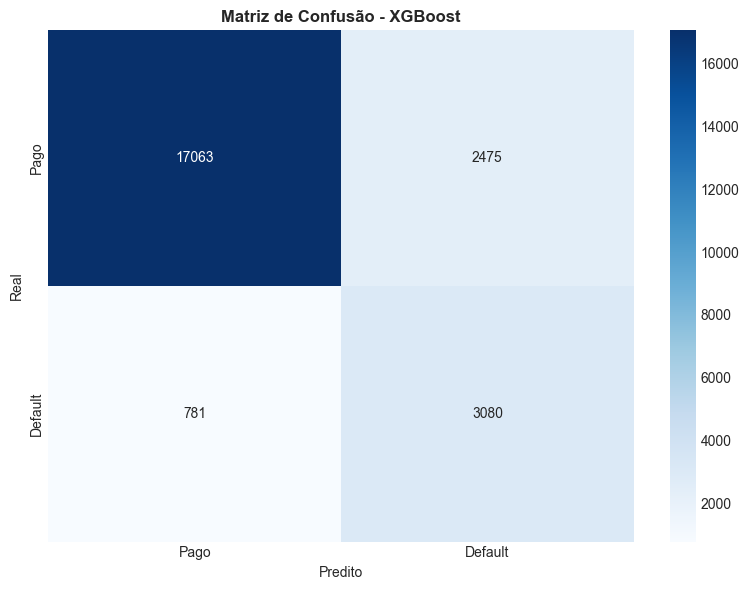


Classification Report:
              precision    recall  f1-score   support

        Pago       0.96      0.87      0.91     19538
     Default       0.55      0.80      0.65      3861

    accuracy                           0.86     23399
   macro avg       0.76      0.84      0.78     23399
weighted avg       0.89      0.86      0.87     23399



In [362]:
# Obter predições do melhor modelo
y_pred_best = predictions_dict[best_model_name]['y_pred']
y_pred_proba_best = predictions_dict[best_model_name]['y_pred_proba']

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_best)
print("\nMatriz de Confusão:")
print(cm)

# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'])
plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=12, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Pago', 'Default']))

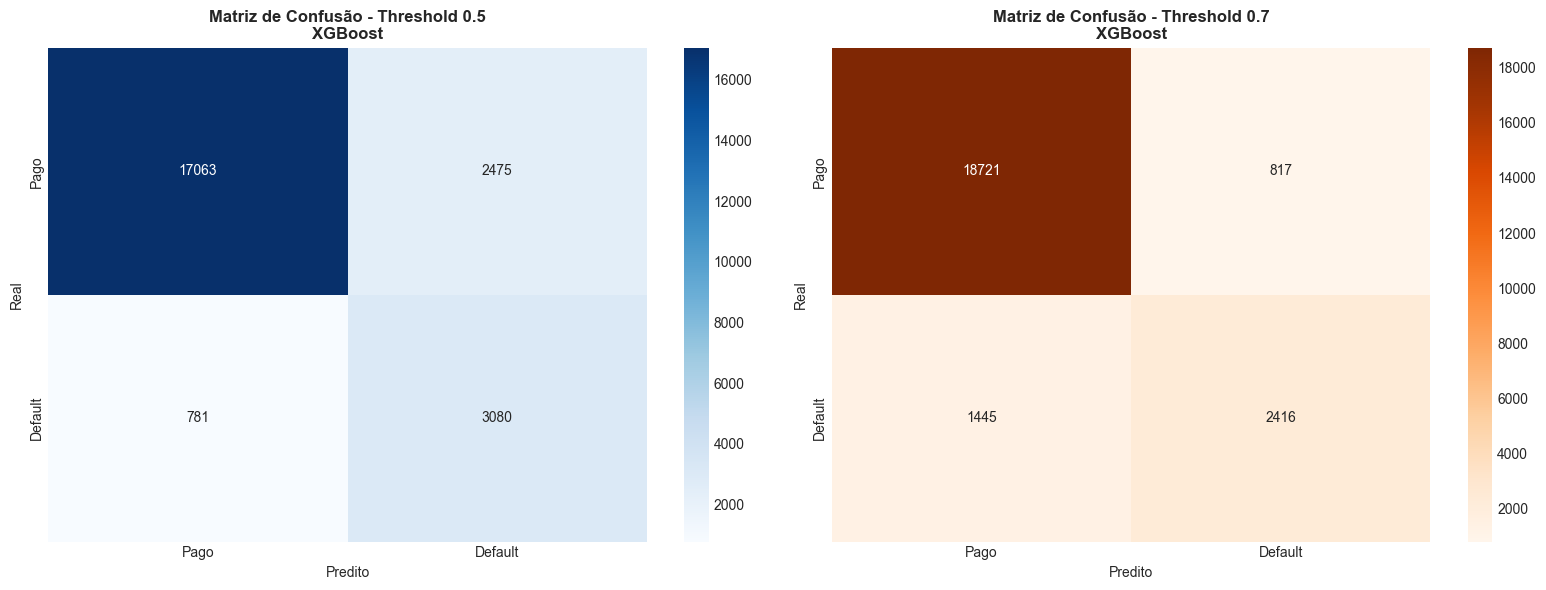

COMPARACAO DE METRICAS: THRESHOLD 0.5 vs 0.7

--- Threshold 0.5 ---
  TN (Pago correto):     17063
  FP (Falso alarme):     2475
  FN (Default perdido):  781
  TP (Default correto):  3080
  Precision: 0.5545
  Recall:    0.7977
  F1-Score:  0.6542

--- Threshold 0.7 ---
  TN (Pago correto):     18721
  FP (Falso alarme):     817
  FN (Default perdido):  1445
  TP (Default correto):  2416
  Precision: 0.7473
  Recall:    0.6257
  F1-Score:  0.6811

IMPACTO DA MUDANCA DE THRESHOLD (0.5 -> 0.7)
  Falsos Positivos: 2475 -> 817 (-1658)
  Falsos Negativos: 781 -> 1445 (+664)
  Verdadeiros Positivos: 3080 -> 2416 (-664)
  Verdadeiros Negativos: 17063 -> 18721 (+1658)

  -> Threshold mais alto = modelo mais conservador (menos defaults preditos)
  -> Menos falsos positivos, porem mais falsos negativos


In [363]:
# Comparação de Matrizes de Confusão: Threshold 0.5 vs 0.7

# Predições com threshold padrão (0.5)
y_pred_t05 = (y_pred_proba_best >= 0.5).astype(int)
cm_t05 = confusion_matrix(y_test, y_pred_t05)

# Predições com threshold 0.7
y_pred_t07 = (y_pred_proba_best >= 0.7).astype(int)
cm_t07 = confusion_matrix(y_test, y_pred_t07)

# Visualização lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de Confusão - Threshold 0.5
sns.heatmap(cm_t05, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[0])
axes[0].set_title(f'Matriz de Confusão - Threshold 0.5\n{best_model_name}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')

# Matriz de Confusão - Threshold 0.7
sns.heatmap(cm_t07, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[1])
axes[1].set_title(f'Matriz de Confusão - Threshold 0.7\n{best_model_name}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predito')

plt.tight_layout()
plt.show()

# Comparação de métricas
print("="*70)
print("COMPARACAO DE METRICAS: THRESHOLD 0.5 vs 0.7")
print("="*70)

for label, y_pred, cm in [("Threshold 0.5", y_pred_t05, cm_t05), 
                            ("Threshold 0.7", y_pred_t07, cm_t07)]:
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n--- {label} ---")
    print(f"  TN (Pago correto):     {tn}")
    print(f"  FP (Falso alarme):     {fp}")
    print(f"  FN (Default perdido):  {fn}")
    print(f"  TP (Default correto):  {tp}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Análise do impacto
tn_05, fp_05, fn_05, tp_05 = cm_t05.ravel()
tn_07, fp_07, fn_07, tp_07 = cm_t07.ravel()

print(f"\n{'='*70}")
print("IMPACTO DA MUDANCA DE THRESHOLD (0.5 -> 0.7)")
print(f"{'='*70}")
print(f"  Falsos Positivos: {fp_05} -> {fp_07} ({fp_07 - fp_05:+d})")
print(f"  Falsos Negativos: {fn_05} -> {fn_07} ({fn_07 - fn_05:+d})")
print(f"  Verdadeiros Positivos: {tp_05} -> {tp_07} ({tp_07 - tp_05:+d})")
print(f"  Verdadeiros Negativos: {tn_05} -> {tn_07} ({tn_07 - tn_05:+d})")
print(f"\n  -> Threshold mais alto = modelo mais conservador (menos defaults preditos)")
print(f"  -> Menos falsos positivos, porem mais falsos negativos")

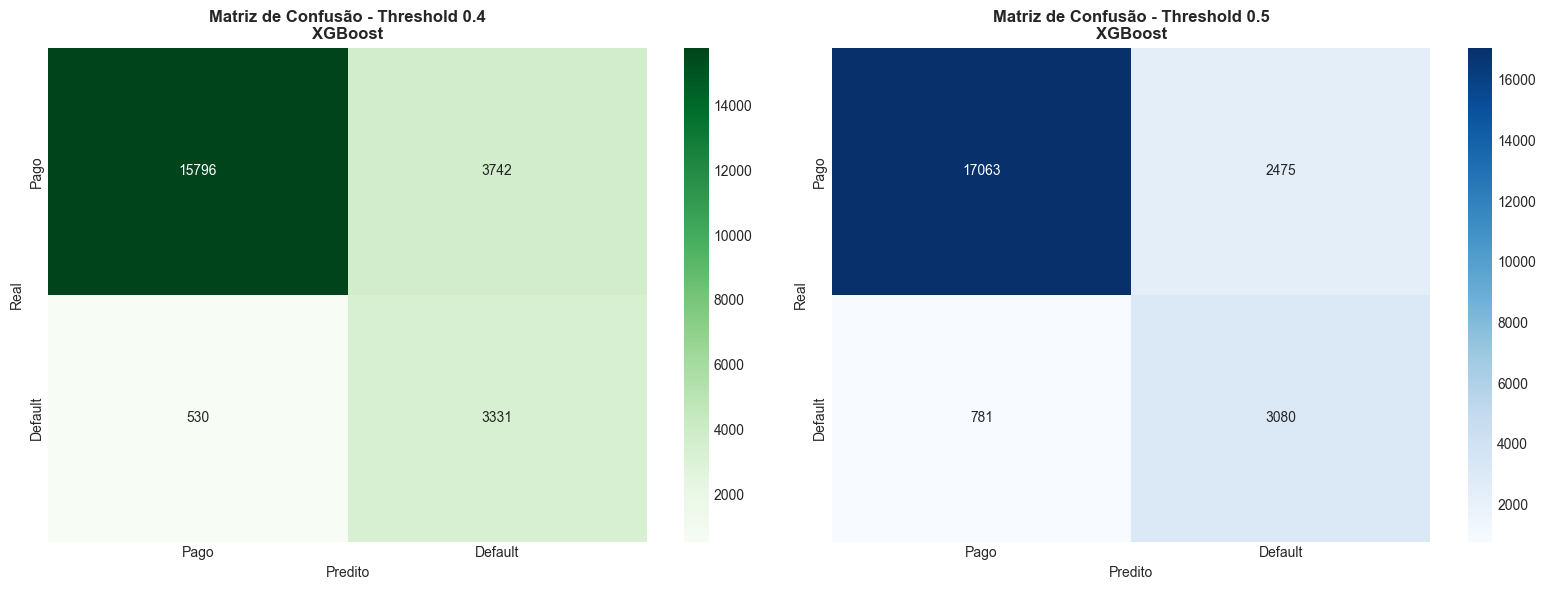

COMPARACAO DE METRICAS: THRESHOLD 0.4 vs 0.5

--- Threshold 0.4 ---
  TN (Pago correto):     15796
  FP (Falso alarme):     3742
  FN (Default perdido):  530
  TP (Default correto):  3331
  Precision: 0.4709
  Recall:    0.8627
  F1-Score:  0.6093

--- Threshold 0.5 ---
  TN (Pago correto):     17063
  FP (Falso alarme):     2475
  FN (Default perdido):  781
  TP (Default correto):  3080
  Precision: 0.5545
  Recall:    0.7977
  F1-Score:  0.6542

IMPACTO DA MUDANCA DE THRESHOLD (0.4 -> 0.5)
  Falsos Positivos: 3742 -> 2475 (-1267)
  Falsos Negativos: 530 -> 781 (+251)
  Verdadeiros Positivos: 3331 -> 3080 (-251)
  Verdadeiros Negativos: 15796 -> 17063 (+1267)

  -> Threshold 0.4 = modelo mais agressivo (mais defaults preditos)
  -> Mais falsos positivos, porem menos falsos negativos (captura mais defaults reais)


In [364]:
# Comparação de Matrizes de Confusão: Threshold 0.4 vs 0.5

# Predições com threshold 0.4
y_pred_t04 = (y_pred_proba_best >= 0.4).astype(int)
cm_t04 = confusion_matrix(y_test, y_pred_t04)

# Predições com threshold 0.5
y_pred_t05 = (y_pred_proba_best >= 0.5).astype(int)
cm_t05 = confusion_matrix(y_test, y_pred_t05)

# Visualização lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de Confusão - Threshold 0.4
sns.heatmap(cm_t04, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[0])
axes[0].set_title(f'Matriz de Confusão - Threshold 0.4\n{best_model_name}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')

# Matriz de Confusão - Threshold 0.5
sns.heatmap(cm_t05, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[1])
axes[1].set_title(f'Matriz de Confusão - Threshold 0.5\n{best_model_name}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predito')

plt.tight_layout()
plt.show()

# Comparação de métricas
print("="*70)
print("COMPARACAO DE METRICAS: THRESHOLD 0.4 vs 0.5")
print("="*70)

for label, y_pred, cm in [("Threshold 0.4", y_pred_t04, cm_t04), 
                            ("Threshold 0.5", y_pred_t05, cm_t05)]:
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n--- {label} ---")
    print(f"  TN (Pago correto):     {tn}")
    print(f"  FP (Falso alarme):     {fp}")
    print(f"  FN (Default perdido):  {fn}")
    print(f"  TP (Default correto):  {tp}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Análise do impacto
tn_04, fp_04, fn_04, tp_04 = cm_t04.ravel()
tn_05, fp_05, fn_05, tp_05 = cm_t05.ravel()

print(f"\n{'='*70}")
print("IMPACTO DA MUDANCA DE THRESHOLD (0.4 -> 0.5)")
print(f"{'='*70}")
print(f"  Falsos Positivos: {fp_04} -> {fp_05} ({fp_05 - fp_04:+d})")
print(f"  Falsos Negativos: {fn_04} -> {fn_05} ({fn_05 - fn_04:+d})")
print(f"  Verdadeiros Positivos: {tp_04} -> {tp_05} ({tp_05 - tp_04:+d})")
print(f"  Verdadeiros Negativos: {tn_04} -> {tn_05} ({tn_05 - tn_04:+d})")
print(f"\n  -> Threshold 0.4 = modelo mais agressivo (mais defaults preditos)")
print(f"  -> Mais falsos positivos, porem menos falsos negativos (captura mais defaults reais)")

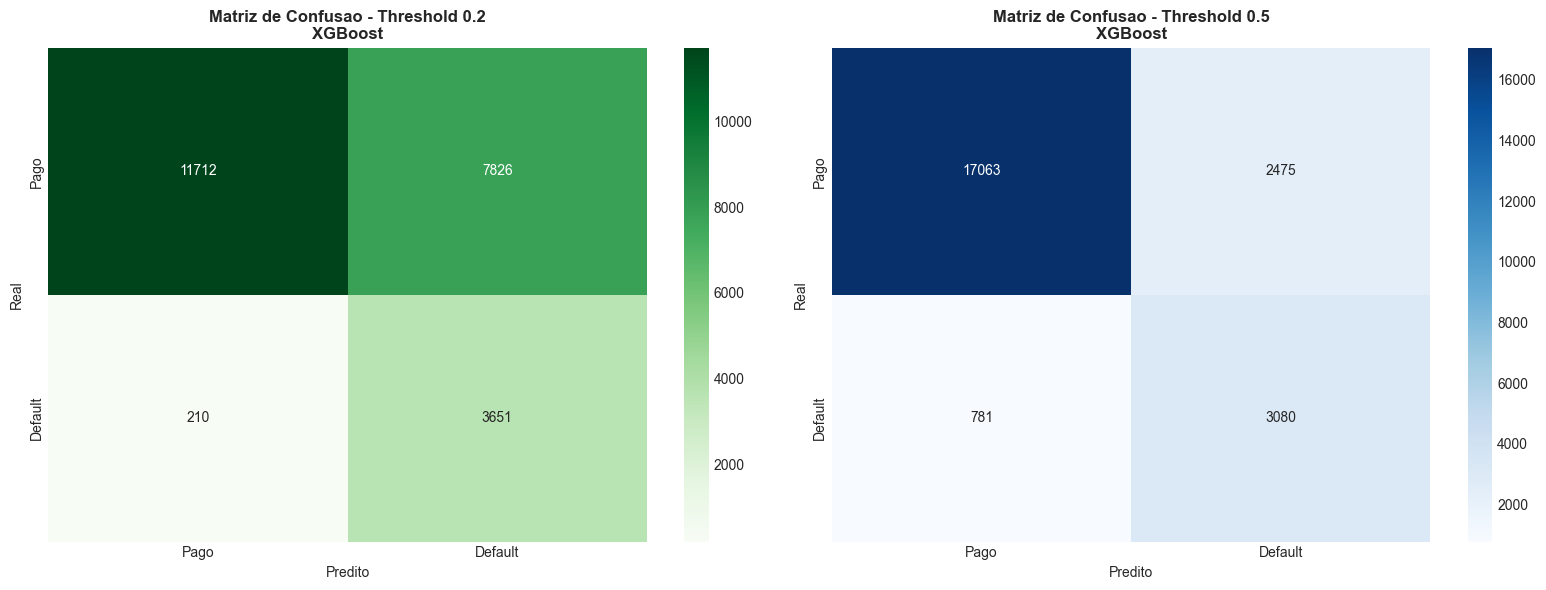

COMPARACAO DE METRICAS: THRESHOLD 0.2 vs 0.5

--- Threshold 0.2 ---
  TN (Pago correto):     11712
  FP (Falso alarme):     7826
  FN (Default perdido):  210
  TP (Default correto):  3651
  Precision: 0.3181
  Recall:    0.9456
  F1-Score:  0.4761

--- Threshold 0.5 ---
  TN (Pago correto):     17063
  FP (Falso alarme):     2475
  FN (Default perdido):  781
  TP (Default correto):  3080
  Precision: 0.5545
  Recall:    0.7977
  F1-Score:  0.6542

IMPACTO DA MUDANCA DE THRESHOLD (0.2 -> 0.5)
  Falsos Positivos: 7826 -> 2475 (-5351)
  Falsos Negativos: 210 -> 781 (+571)
  Verdadeiros Positivos: 3651 -> 3080 (-571)
  Verdadeiros Negativos: 11712 -> 17063 (+5351)

  -> Threshold 0.2 = modelo mais agressivo (mais defaults preditos)
  -> Maior recall (pega mais defaults), porem menor precision (mais falsos alarmes)
  -> Threshold 0.5 = modelo mais equilibrado entre precision e recall


In [365]:
# Comparacao de Matrizes de Confusao: Threshold 0.2 vs 0.5

# Predicoes com threshold 0.2
y_pred_t02 = (y_pred_proba_best >= 0.2).astype(int)
cm_t02 = confusion_matrix(y_test, y_pred_t02)

# Predicoes com threshold 0.5
y_pred_t05_b = (y_pred_proba_best >= 0.5).astype(int)
cm_t05_b = confusion_matrix(y_test, y_pred_t05_b)

# Visualizacao lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de Confusao - Threshold 0.2
sns.heatmap(cm_t02, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[0])
axes[0].set_title(f'Matriz de Confusao - Threshold 0.2\n{best_model_name}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')

# Matriz de Confusao - Threshold 0.5
sns.heatmap(cm_t05_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pago', 'Default'], yticklabels=['Pago', 'Default'], ax=axes[1])
axes[1].set_title(f'Matriz de Confusao - Threshold 0.5\n{best_model_name}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predito')

plt.tight_layout()
plt.show()

# Comparacao de metricas
print("="*70)
print("COMPARACAO DE METRICAS: THRESHOLD 0.2 vs 0.5")
print("="*70)

for label, y_pred, cm in [('Threshold 0.2', y_pred_t02, cm_t02),
                           ('Threshold 0.5', y_pred_t05_b, cm_t05_b)]:
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n--- {label} ---")
    print(f"  TN (Pago correto):     {tn}")
    print(f"  FP (Falso alarme):     {fp}")
    print(f"  FN (Default perdido):  {fn}")
    print(f"  TP (Default correto):  {tp}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Analise do impacto
tn_02, fp_02, fn_02, tp_02 = cm_t02.ravel()
tn_05b, fp_05b, fn_05b, tp_05b = cm_t05_b.ravel()

print(f"\n{'='*70}")
print("IMPACTO DA MUDANCA DE THRESHOLD (0.2 -> 0.5)")
print(f"{'='*70}")
print(f"  Falsos Positivos: {fp_02} -> {fp_05b} ({fp_05b - fp_02:+d})")
print(f"  Falsos Negativos: {fn_02} -> {fn_05b} ({fn_05b - fn_02:+d})")
print(f"  Verdadeiros Positivos: {tp_02} -> {tp_05b} ({tp_05b - tp_02:+d})")
print(f"  Verdadeiros Negativos: {tn_02} -> {tn_05b} ({tn_05b - tn_02:+d})")

print(f"\n  -> Threshold 0.2 = modelo mais agressivo (mais defaults preditos)")
print(f"  -> Maior recall (pega mais defaults), porem menor precision (mais falsos alarmes)")
print(f"  -> Threshold 0.5 = modelo mais equilibrado entre precision e recall")


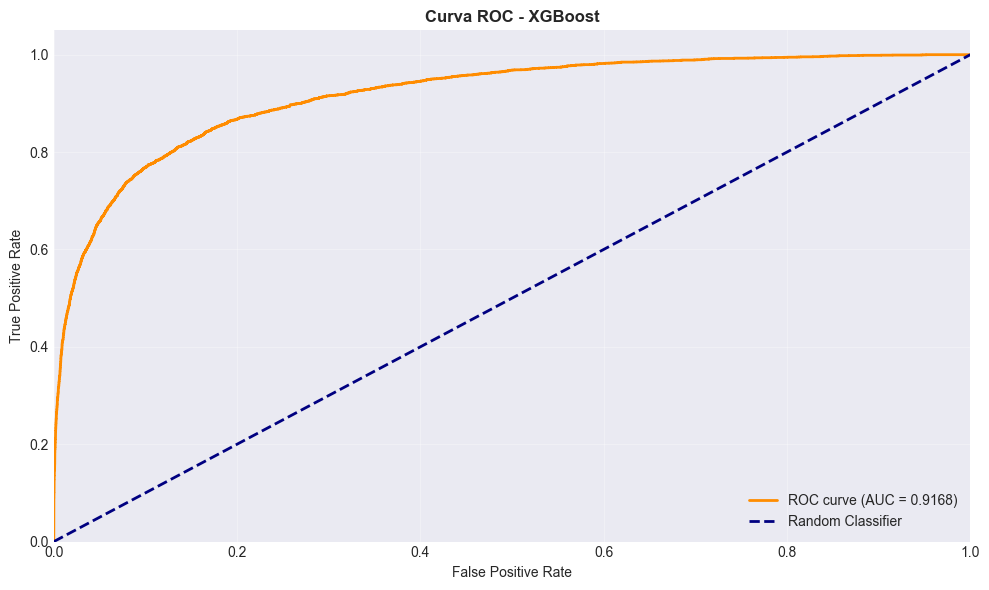

In [366]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - {best_model_name}', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

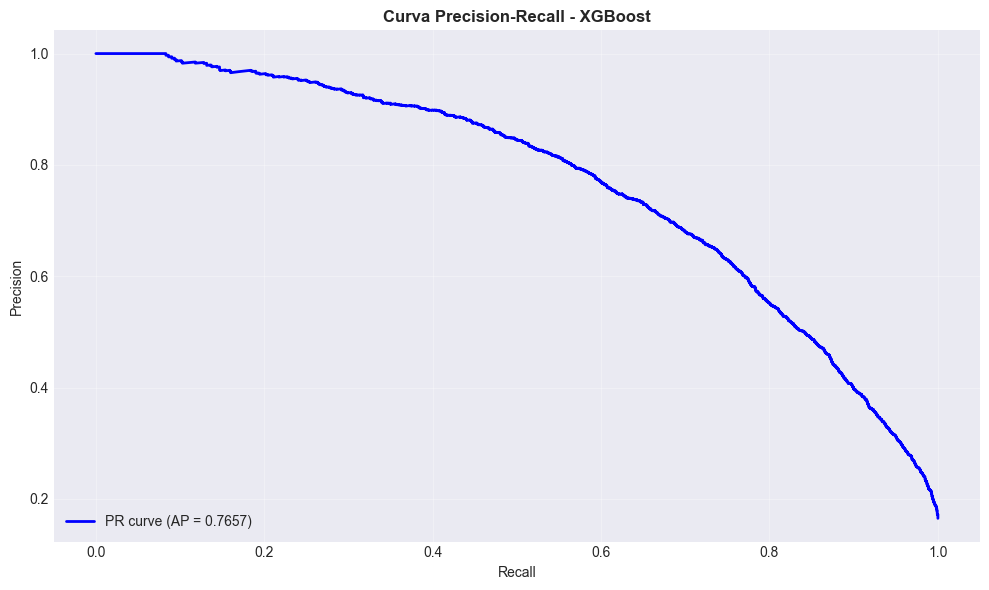

In [367]:
# Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Curva Precision-Recall - {best_model_name}', fontsize=12, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Análise de Custos de Negócio

Cálculo de custos baseado em diferentes cenários de negócio, considerando:
- **Falsos Negativos (FN)**: Custo de classificar default como bom (perder dinheiro)
- **Falsos Positivos (FP)**: Custo de classificar bom como default (perder oportunidade)

In [368]:
# Função para calcular custo total baseado em threshold
def calculate_business_cost(y_true, y_pred_proba, threshold, cost_fn, cost_fp):
    """
    Calcula custo total de negócio para um dado threshold.
    
    Parâmetros:
    - cost_fn: Custo de Falso Negativo (classificar default como bom)
    - cost_fp: Custo de Falso Positivo (classificar bom como default)
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    
    return {
        'threshold': threshold,
        'FN': fn,
        'FP': fp,
        'TP': tp,
        'TN': tn,
        'cost_FN': fn * cost_fn,
        'cost_FP': fp * cost_fp,
        'total_cost': total_cost,
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

# Definir cenários de custo
scenarios = {
    'Cenário 1: Custos Equilibrados': {'cost_fn': 1000, 'cost_fp': 1000},
    'Cenário 2: FN custa 3x mais que FP': {'cost_fn': 3000, 'cost_fp': 1000},
    'Cenário 3: FN custa 5x mais que FP': {'cost_fn': 5000, 'cost_fp': 1000},
    'Cenário 4: FP custa 2x mais que FN': {'cost_fn': 1000, 'cost_fp': 2000},
}

# Avaliar thresholds de 0.1 a 0.9
threshold_range = np.arange(0.1, 0.91, 0.05)

# Analisar cada cenário
results_by_scenario = {}
print("\n" + "="*80)
print("💰 ANÁLISE DE CUSTOS DE NEGÓCIO")
print("="*80)

for scenario_name, costs in scenarios.items():
    print(f"\n{scenario_name}:")
    print(f"  - Custo FN (perder dinheiro com default): R$ {costs['cost_fn']:,.0f}")
    print(f"  - Custo FP (perder oportunidade de venda): R$ {costs['cost_fp']:,.0f}")
    
    scenario_results = []
    for t in threshold_range:
        result = calculate_business_cost(y_test, y_pred_proba_best, t, 
                                        costs['cost_fn'], costs['cost_fp'])
        scenario_results.append(result)
    
    results_by_scenario[scenario_name] = scenario_results
    
    # Encontrar threshold com menor custo
    min_cost_idx = np.argmin([r['total_cost'] for r in scenario_results])
    optimal_result = scenario_results[min_cost_idx]
    
    print(f"\n  🎯 Threshold Ótimo: {optimal_result['threshold']:.2f}")
    print(f"     - Custo Total: R$ {optimal_result['total_cost']:,.0f}")
    print(f"     - FN: {optimal_result['FN']} (custo: R$ {optimal_result['cost_FN']:,.0f})")
    print(f"     - FP: {optimal_result['FP']} (custo: R$ {optimal_result['cost_FP']:,.0f})")
    print(f"     - Precision: {optimal_result['precision']:.4f}")
    print(f"     - Recall: {optimal_result['recall']:.4f}")

print("\n" + "="*80)


💰 ANÁLISE DE CUSTOS DE NEGÓCIO

Cenário 1: Custos Equilibrados:
  - Custo FN (perder dinheiro com default): R$ 1,000
  - Custo FP (perder oportunidade de venda): R$ 1,000

  🎯 Threshold Ótimo: 0.75
     - Custo Total: R$ 2,223,000
     - FN: 1649 (custo: R$ 1,649,000)
     - FP: 574 (custo: R$ 574,000)
     - Precision: 0.7940
     - Recall: 0.5729

Cenário 2: FN custa 3x mais que FP:
  - Custo FN (perder dinheiro com default): R$ 3,000
  - Custo FP (perder oportunidade de venda): R$ 1,000

  🎯 Threshold Ótimo: 0.55
     - Custo Total: R$ 4,620,000
     - FN: 904 (custo: R$ 2,712,000)
     - FP: 1908 (custo: R$ 1,908,000)
     - Precision: 0.6078
     - Recall: 0.7659

Cenário 3: FN custa 5x mais que FP:
  - Custo FN (perder dinheiro com default): R$ 5,000
  - Custo FP (perder oportunidade de venda): R$ 1,000

  🎯 Threshold Ótimo: 0.45
     - Custo Total: R$ 6,356,000
     - FN: 658 (custo: R$ 3,290,000)
     - FP: 3066 (custo: R$ 3,066,000)
     - Precision: 0.5109
     - Recall: 0.8

## Visualização: Análise de Custos de Negócio

Gráficos mostrando o custo total para cada threshold em diferentes cenários de negócio.

In [369]:
# Calcular precision, recall e thresholds
y_pred_proba_best = predictions_dict[best_model_name]['y_pred_proba']
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)

# Remover último valor (threshold infinito)
precision_vals = precision_vals[:-1]
recall_vals = recall_vals[:-1]

# Calcular F1, F2 e F0.5 para cada threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
f2_scores = 5 * (precision_vals * recall_vals) / (4 * precision_vals + recall_vals + 1e-10)  # Beta=2 (prioriza Recall)
f05_scores = 1.25 * (precision_vals * recall_vals) / (0.25 * precision_vals + recall_vals + 1e-10)  # Beta=0.5 (prioriza Precision)

# Encontrar thresholds ótimos
optimal_idx_f1 = np.argmax(f1_scores)
optimal_idx_f2 = np.argmax(f2_scores)
optimal_idx_f05 = np.argmax(f05_scores)

optimal_threshold_f1 = thresholds_pr[optimal_idx_f1]
optimal_threshold_f2 = thresholds_pr[optimal_idx_f2]
optimal_threshold_f05 = thresholds_pr[optimal_idx_f05]

print("\n" + "="*80)
print("🎯 THRESHOLDS ÓTIMOS")
print("="*80)
print(f"\n1. Threshold padrão (0.50):")
print(f"   - Precision: {precision_score(y_test, (y_pred_proba_best >= 0.5).astype(int)):.4f}")
print(f"   - Recall:    {recall_score(y_test, (y_pred_proba_best >= 0.5).astype(int)):.4f}")
print(f"   - F1-Score:  {f1_score(y_test, (y_pred_proba_best >= 0.5).astype(int)):.4f}")

print(f"\n2. Threshold que MAXIMIZA F1-Score ({optimal_threshold_f1:.4f}):")
print(f"   - Precision: {precision_vals[optimal_idx_f1]:.4f}")
print(f"   - Recall:    {recall_vals[optimal_idx_f1]:.4f}")
print(f"   - F1-Score:  {f1_scores[optimal_idx_f1]:.4f}")
print(f"   📊 Balanceia igualmente Precision e Recall")

print(f"\n3. Threshold que MAXIMIZA F2-Score ({optimal_threshold_f2:.4f}) [Prioriza RECALL]:")
print(f"   - Precision: {precision_vals[optimal_idx_f2]:.4f}")
print(f"   - Recall:    {recall_vals[optimal_idx_f2]:.4f}")
print(f"   - F2-Score:  {f2_scores[optimal_idx_f2]:.4f}")
print(f"   📊 Minimiza falsos negativos (identificar mais defaults)")

print(f"\n4. Threshold que MAXIMIZA F0.5-Score ({optimal_threshold_f05:.4f}) [Prioriza PRECISION]:")
print(f"   - Precision: {precision_vals[optimal_idx_f05]:.4f}")
print(f"   - Recall:    {recall_vals[optimal_idx_f05]:.4f}")
print(f"   - F0.5-Score:  {f05_scores[optimal_idx_f05]:.4f}")
print(f"   📊 Minimiza falsos positivos (evitar rejeitar bons clientes)")

print("\n" + "="*80)


🎯 THRESHOLDS ÓTIMOS

1. Threshold padrão (0.50):
   - Precision: 0.5545
   - Recall:    0.7977
   - F1-Score:  0.6542

2. Threshold que MAXIMIZA F1-Score (0.6413):
   - Precision: 0.6972
   - Recall:    0.6864
   - F1-Score:  0.6917
   📊 Balanceia igualmente Precision e Recall

3. Threshold que MAXIMIZA F2-Score (0.4182) [Prioriza RECALL]:
   - Precision: 0.4860
   - Recall:    0.8526
   - F2-Score:  0.7408
   📊 Minimiza falsos negativos (identificar mais defaults)

4. Threshold que MAXIMIZA F0.5-Score (0.8022) [Prioriza PRECISION]:
   - Precision: 0.8390
   - Recall:    0.5128
   - F0.5-Score:  0.7443
   📊 Minimiza falsos positivos (evitar rejeitar bons clientes)



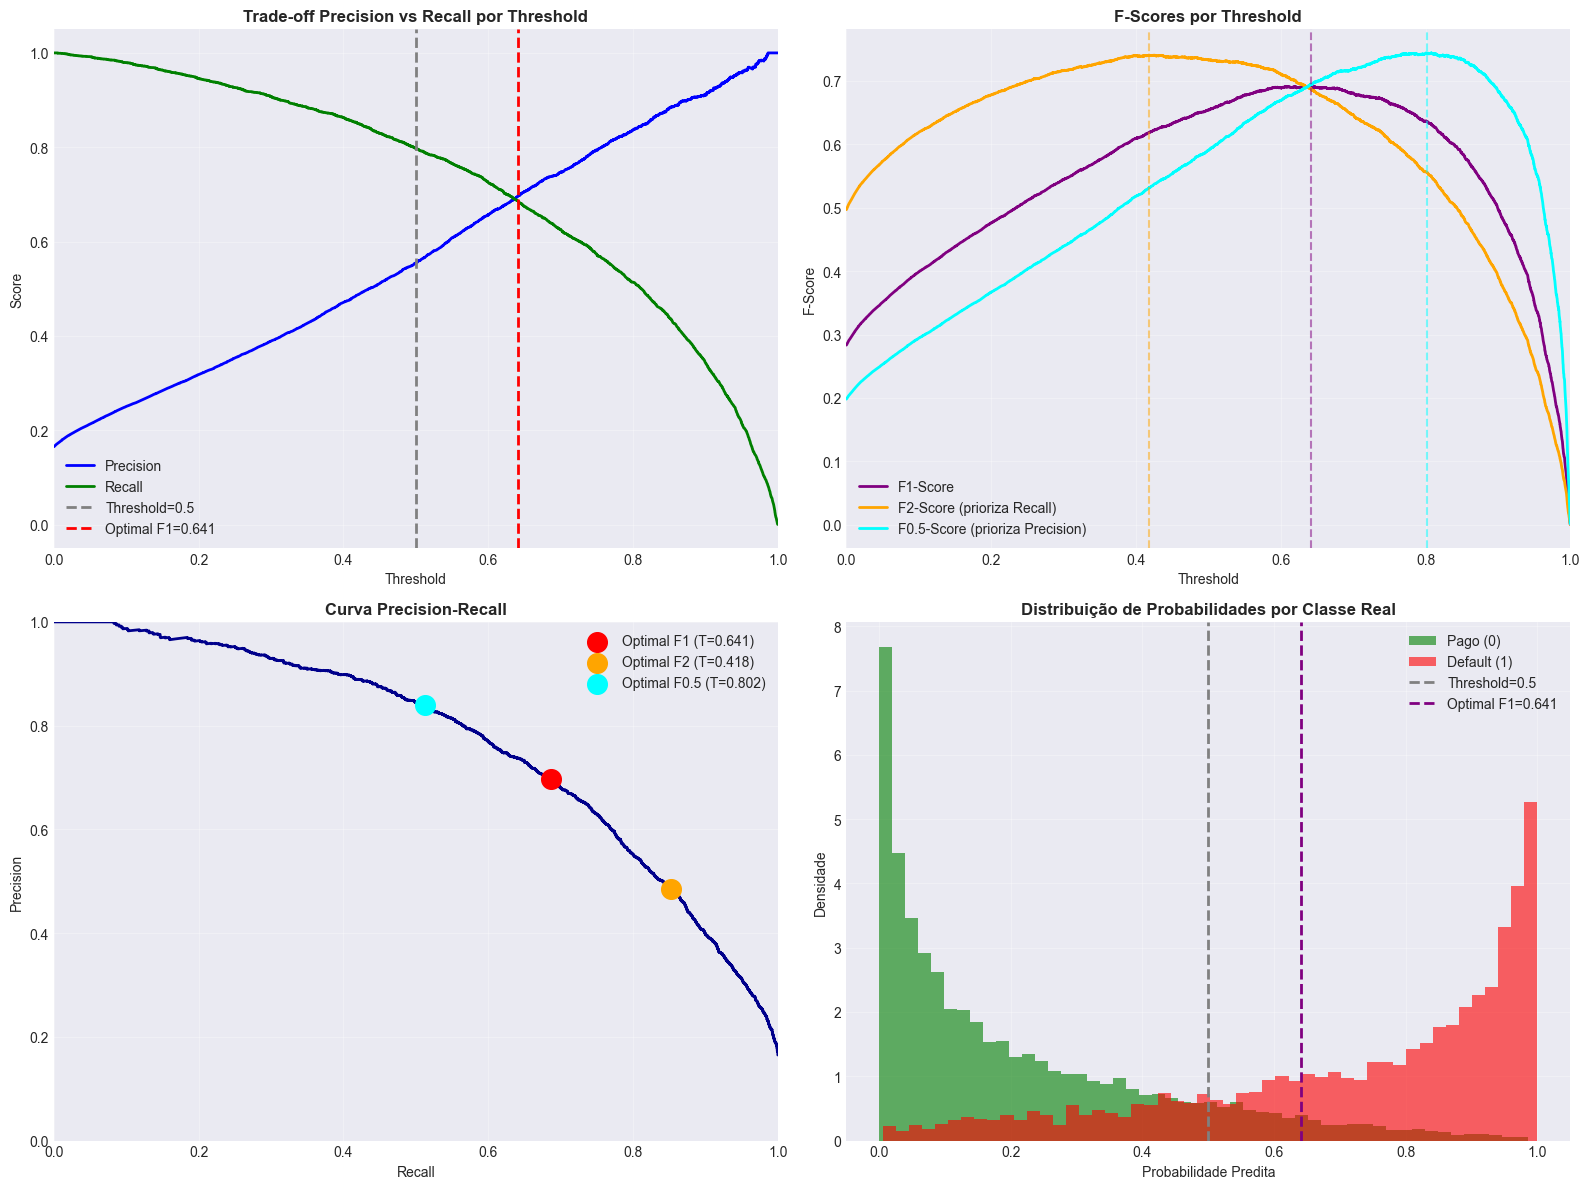

In [370]:
# Visualizações de threshold optimization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Precision-Recall trade-off
axes[0, 0].plot(thresholds_pr, precision_vals, label='Precision', linewidth=2, color='blue')
axes[0, 0].plot(thresholds_pr, recall_vals, label='Recall', linewidth=2, color='green')
axes[0, 0].axvline(x=0.5, color='gray', linestyle='--', label='Threshold=0.5', linewidth=2)
axes[0, 0].axvline(x=optimal_threshold_f1, color='red', linestyle='--', 
                   label=f'Optimal F1={optimal_threshold_f1:.3f}', linewidth=2)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Trade-off Precision vs Recall por Threshold', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 1])

# 2. F-Scores por threshold
axes[0, 1].plot(thresholds_pr, f1_scores, label='F1-Score', linewidth=2, color='purple')
axes[0, 1].plot(thresholds_pr, f2_scores, label='F2-Score (prioriza Recall)', linewidth=2, color='orange')
axes[0, 1].plot(thresholds_pr, f05_scores, label='F0.5-Score (prioriza Precision)', linewidth=2, color='cyan')
axes[0, 1].axvline(x=optimal_threshold_f1, color='purple', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=optimal_threshold_f2, color='orange', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=optimal_threshold_f05, color='cyan', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('F-Score')
axes[0, 1].set_title('F-Scores por Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 1])

# 3. Curva Precision-Recall (espaço PR)
axes[1, 0].plot(recall_vals, precision_vals, linewidth=2, color='darkblue')
axes[1, 0].scatter([recall_vals[optimal_idx_f1]], [precision_vals[optimal_idx_f1]], 
                   color='red', s=200, zorder=5, label=f'Optimal F1 (T={optimal_threshold_f1:.3f})')
axes[1, 0].scatter([recall_vals[optimal_idx_f2]], [precision_vals[optimal_idx_f2]], 
                   color='orange', s=200, zorder=5, label=f'Optimal F2 (T={optimal_threshold_f2:.3f})')
axes[1, 0].scatter([recall_vals[optimal_idx_f05]], [precision_vals[optimal_idx_f05]], 
                   color='cyan', s=200, zorder=5, label=f'Optimal F0.5 (T={optimal_threshold_f05:.3f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Curva Precision-Recall', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# 4. Distribuição de probabilidades preditas por classe real
axes[1, 1].hist(y_pred_proba_best[y_test == 0], bins=50, alpha=0.6, label='Pago (0)', color='green', density=True)
axes[1, 1].hist(y_pred_proba_best[y_test == 1], bins=50, alpha=0.6, label='Default (1)', color='red', density=True)
axes[1, 1].axvline(x=0.5, color='gray', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1, 1].axvline(x=optimal_threshold_f1, color='purple', linestyle='--', linewidth=2, 
                   label=f'Optimal F1={optimal_threshold_f1:.3f}')
axes[1, 1].set_xlabel('Probabilidade Predita')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].set_title('Distribuição de Probabilidades por Classe Real', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Feature Importance

Análise das features mais importantes para o modelo selecionado, com **nomes descritivos** e **separação por cores**:

- 🟧 **Coral**: Target Encoding (atividade_principal, forma_pagamento, tipo_sociedade)
- 🟦 **Azul**: Features numéricas (valores financeiros, ratios, flags)
- 🟩 **Verde**: One-Hot Encoding (opcao_tributaria)


🔍 TOP 20 FEATURES MAIS IMPORTANTES
                            Feature  Importance
               num__default_3months    0.149385
onehot__tributaria_simples nacional    0.114596
               num__quant_protestos    0.062860
        target_enc__forma_pagamento    0.053139
                 num__valor_vencido    0.040042
                          onehot__2    0.038408
                          onehot__9    0.037524
                          onehot__7    0.033047
 onehot__tributaria_lucro presumido    0.030289
    target_enc__atividade_principal    0.028561
                   num__ioi_3months    0.023007
                          onehot__1    0.022392
                          onehot__8    0.022183
                  num__ioi_36months    0.021968
               num__valor_protestos    0.021872
         num__ratio_vencido_quitado    0.021176
         target_enc__tipo_sociedade    0.020740
        num__ratio_pedido_historico    0.020082
               num__exposicao_total    0.020071
    

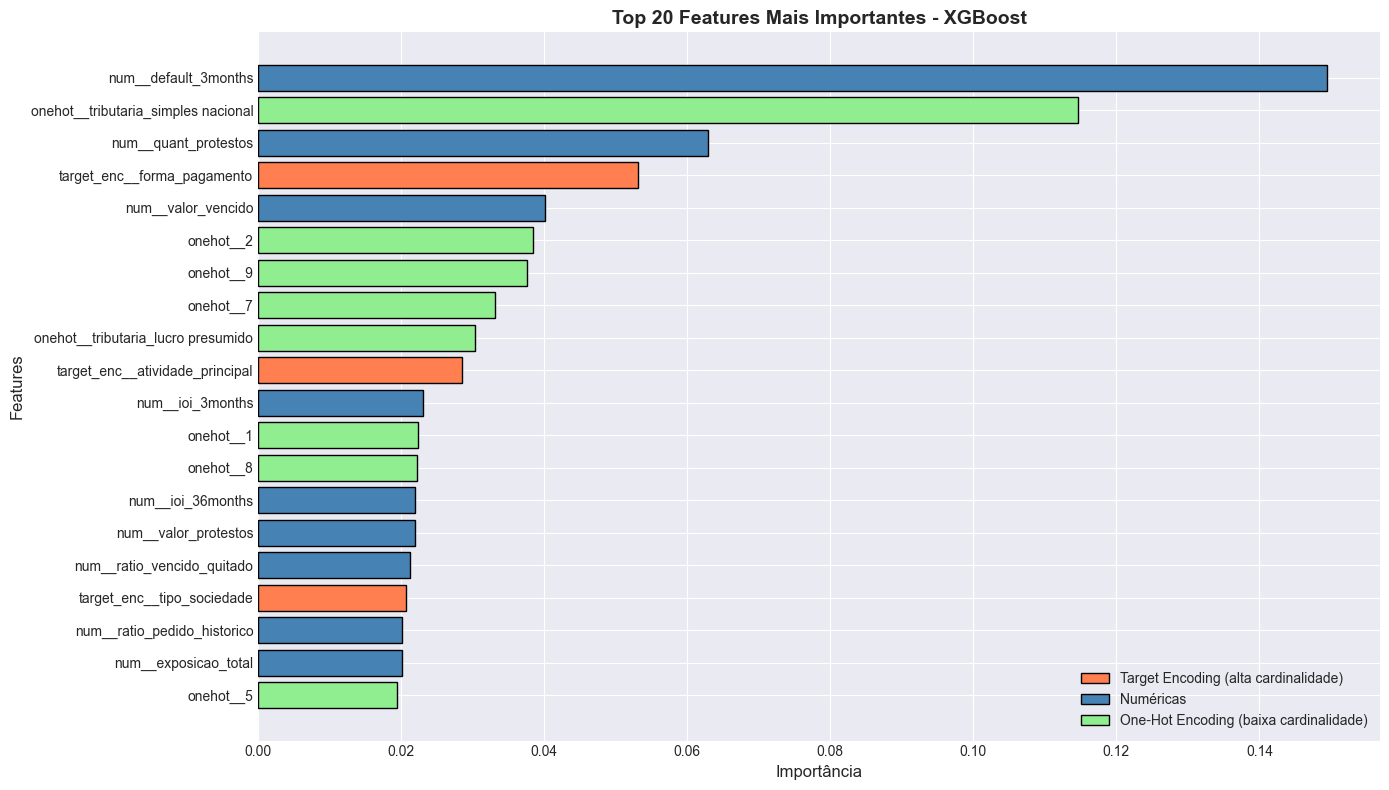


📊 IMPORTÂNCIA AGREGADA POR TIPO DE FEATURE
Target Encoding (alta cardinalidade): 0.1024 (10.2%)
Features Numéricas:                   0.4597 (46.0%)
One-Hot Encoding (baixa cardinalidade): 0.4379 (43.8%)


In [371]:
# Para modelos tree-based, mostrar feature importance com nomes descritivos
best_model_obj = models[best_model_name]
best_model_obj.fit(X_train_processed, y_train)

if hasattr(best_model_obj, 'feature_importances_'):
    # Usar nomes descritivos ao invés dos automáticos
    feature_names = descriptive_feature_names
    
    # Feature importance
    importances = best_model_obj.feature_importances_
    indices = np.argsort(importances)[::-1][:20]  # Top 20
    
    # Criar DataFrame para melhor visualização
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': [importances[i] for i in indices]
    })
    
    print("\n" + "="*80)
    print("🔍 TOP 20 FEATURES MAIS IMPORTANTES")
    print("="*80)
    print(importance_df.to_string(index=False))
    print("="*80)
    
    # Visualização
    plt.figure(figsize=(14, 8))
    plt.title(f'Top 20 Features Mais Importantes - {best_model_name}', fontsize=14, fontweight='bold')
    
    # Usar cores diferentes para diferentes tipos de features
    colors = []
    for name in importance_df['Feature']:
        if name.startswith('target_enc__'):
            colors.append('coral')  # Target Encoding
        elif name.startswith('num__'):
            colors.append('steelblue')  # Numéricas
        else:
            colors.append('lightgreen')  # One-Hot
    
    plt.barh(range(len(importance_df)), importance_df['Importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().invert_yaxis()  # Maior importância no topo
    
    # Legenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='coral', edgecolor='black', label='Target Encoding (alta cardinalidade)'),
        Patch(facecolor='steelblue', edgecolor='black', label='Numéricas'),
        Patch(facecolor='lightgreen', edgecolor='black', label='One-Hot Encoding (baixa cardinalidade)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Análise por tipo de feature
    print("\n" + "="*80)
    print("📊 IMPORTÂNCIA AGREGADA POR TIPO DE FEATURE")
    print("="*80)
    
    # Calcular importância total por tipo
    target_enc_importance = sum([importances[i] for i in range(len(feature_names)) 
                                  if feature_names[i].startswith('target_enc__')])
    numeric_importance = sum([importances[i] for i in range(len(feature_names)) 
                              if feature_names[i].startswith('num__')])
    onehot_importance = sum([importances[i] for i in range(len(feature_names)) 
                             if feature_names[i].startswith('onehot__')])
    
    print(f"Target Encoding (alta cardinalidade): {target_enc_importance:.4f} ({target_enc_importance/sum(importances)*100:.1f}%)")
    print(f"Features Numéricas:                   {numeric_importance:.4f} ({numeric_importance/sum(importances)*100:.1f}%)")
    print(f"One-Hot Encoding (baixa cardinalidade): {onehot_importance:.4f} ({onehot_importance/sum(importances)*100:.1f}%)")
    print("="*80)
else:
    print(f"Feature importance não disponível para {best_model_name}")

## 12.1. Análise SHAP (SHapley Additive exPlanations)

**SHAP** é uma técnica de interpretabilidade que explica a contribuição de cada feature para as predições do modelo usando valores de Shapley da teoria dos jogos.

### Tipos de Gráficos SHAP:

1. **Summary Plot**: Visão geral do impacto de todas as features
   - Eixo Y: Features ordenadas por importância
   - Eixo X: Impacto SHAP (negativo = reduz probabilidade de default, positivo = aumenta)
   - Cor: Valor da feature (vermelho = alto, azul = baixo)

2. **Bar Plot**: Importância média absoluta de cada feature
   - Mostra o impacto médio (em magnitude) de cada feature

3. **Waterfall Plot**: Explicação detalhada de uma predição individual
   - Mostra como cada feature contribui para mover a predição da linha de base para o valor final

In [372]:
# Setup: Instalar SHAP se necessário
import sys
import subprocess

try:
    import shap
    print(f"✓ SHAP {shap.__version__} já instalado")
except ImportError:
    print("⚠ SHAP não encontrado. Instalando...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap>=0.43.0'])
    import shap
    print(f"✓ SHAP {shap.__version__} instalado com sucesso!")

import matplotlib.pyplot as plt
import numpy as np

✓ SHAP 0.48.0 já instalado


In [373]:
# Criar SHAP explainer para o melhor modelo
print(f"\n{'='*80}")
print(f"🔍 CRIANDO SHAP EXPLAINER PARA {best_model_name}")
print(f"{'='*80}\n")

# Usar uma amostra do conjunto de teste para acelerar (SHAP pode ser lento)
# Para tree-based models (XGBoost, LightGBM, RandomForest), usar TreeExplainer
sample_size = min(1000, len(X_test_processed))  # Limitar a 1000 amostras para velocidade
X_sample = X_test_processed[:sample_size]

print(f"📊 Calculando SHAP values para {sample_size} amostras...")
print(f"   (Isso pode levar alguns minutos para modelos complexos)\n")

# Criar explainer baseado no tipo de modelo
if best_model_name in ['XGBoost', 'LightGBM', 'Random Forest']:
    # TreeExplainer é mais rápido e exato para modelos tree-based
    explainer = shap.TreeExplainer(best_model_obj)
    shap_values = explainer.shap_values(X_sample)
    
    # Para classificação binária, alguns modelos retornam [shap_class0, shap_class1]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Usar valores para classe positiva (default=1)
else:
    # Para modelos lineares ou outros, usar KernelExplainer (mais lento)
    # Usar uma amostra menor como background para acelerar
    background_size = min(100, len(X_train_processed))
    background = X_train_processed[:background_size]
    explainer = shap.KernelExplainer(best_model_obj.predict_proba, background)
    shap_values = explainer.shap_values(X_sample)
    
    # Para classificação binária
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

print(f"✅ SHAP values calculados com sucesso!")
print(f"   Shape: {shap_values.shape}")
print(f"   Features: {X_sample.shape[1]}")
print(f"   Amostras analisadas: {X_sample.shape[0]}")


🔍 CRIANDO SHAP EXPLAINER PARA XGBoost

📊 Calculando SHAP values para 1000 amostras...
   (Isso pode levar alguns minutos para modelos complexos)

✅ SHAP values calculados com sucesso!
   Shape: (1000, 40)
   Features: 40
   Amostras analisadas: 1000



📊 GRÁFICO 1: SHAP SUMMARY PLOT



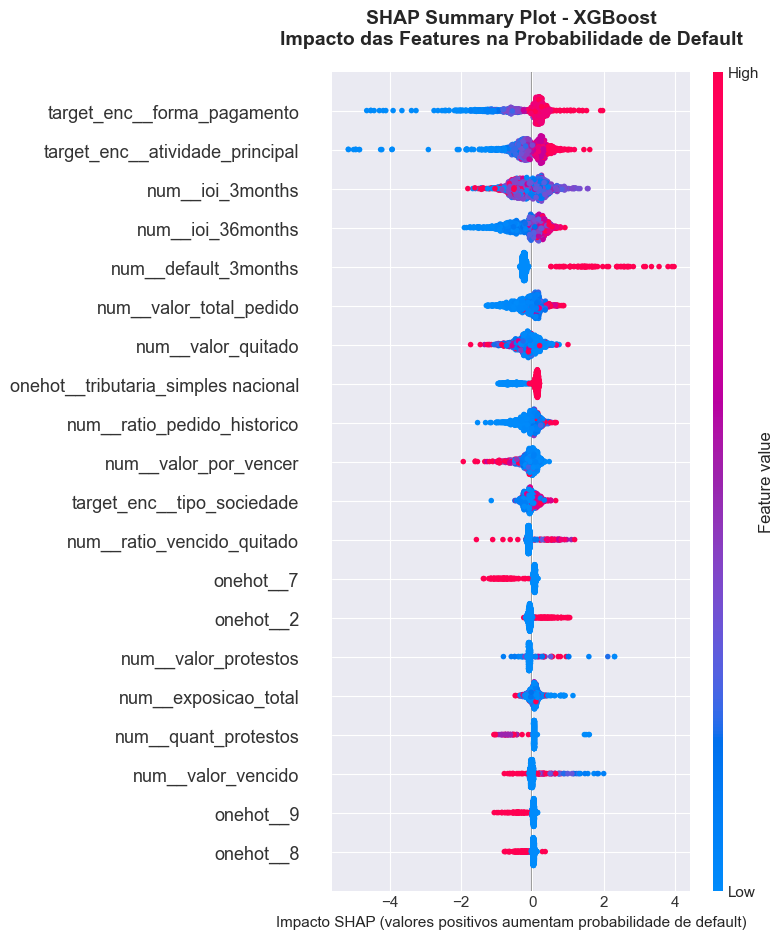


💡 INTERPRETAÇÃO:
   • Cada ponto representa uma observação
   • Posição horizontal: impacto na predição (esquerda = reduz default, direita = aumenta default)
   • Cor: valor da feature (vermelho = alto, azul = baixo)
   • Features no topo têm maior impacto geral no modelo


In [374]:
# 1. SHAP SUMMARY PLOT - Visão geral de todas as features
print(f"\n{'='*80}")
print(f"📊 GRÁFICO 1: SHAP SUMMARY PLOT")
print(f"{'='*80}\n")

plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values, 
    X_sample, 
    feature_names=descriptive_feature_names,
    max_display=20,  # Mostrar top 20 features
    show=False
)
plt.title(f'SHAP Summary Plot - {best_model_name}\n'
          f'Impacto das Features na Probabilidade de Default', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Impacto SHAP (valores positivos aumentam probabilidade de default)', fontsize=11)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO:")
print("   • Cada ponto representa uma observação")
print("   • Posição horizontal: impacto na predição (esquerda = reduz default, direita = aumenta default)")
print("   • Cor: valor da feature (vermelho = alto, azul = baixo)")
print("   • Features no topo têm maior impacto geral no modelo")


📊 GRÁFICO 2: SHAP BAR PLOT (Importância Média)



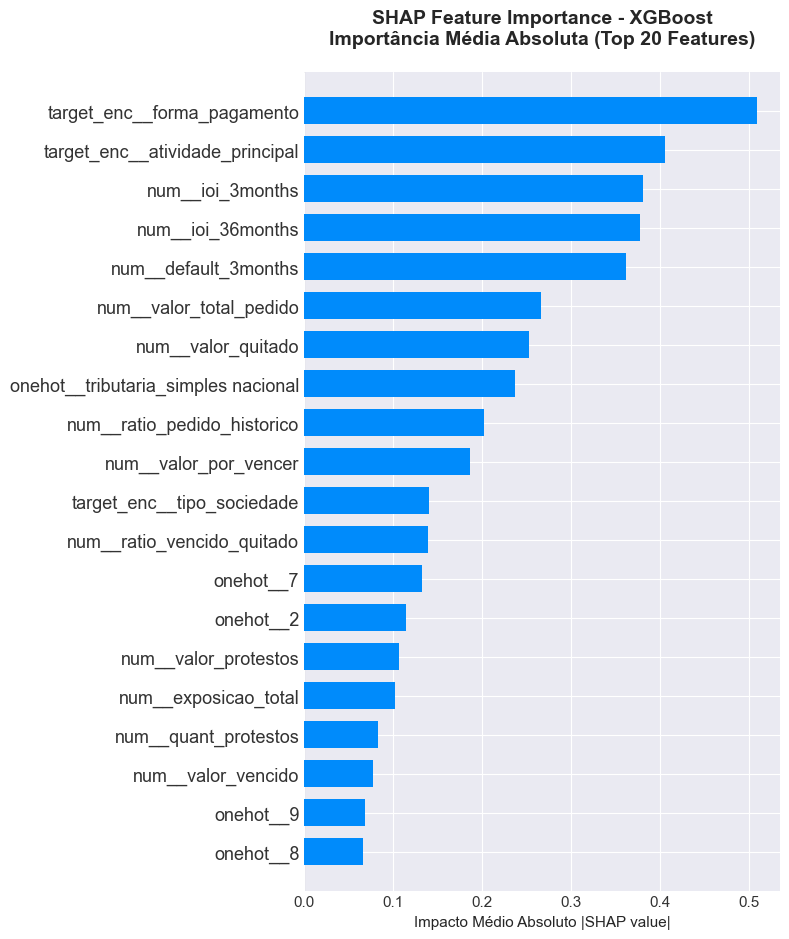


💡 INTERPRETAÇÃO:
   • Mostra a importância média (em magnitude) de cada feature
   • Features no topo têm maior impacto médio nas predições
   • Similar ao feature importance tradicional, mas mais robusto


In [375]:
# 2. SHAP BAR PLOT - Importância média absoluta
print(f"\n{'='*80}")
print(f"📊 GRÁFICO 2: SHAP BAR PLOT (Importância Média)")
print(f"{'='*80}\n")

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_sample, 
    feature_names=descriptive_feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title(f'SHAP Feature Importance - {best_model_name}\n'
          f'Importância Média Absoluta (Top 20 Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Impacto Médio Absoluto |SHAP value|', fontsize=11)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO:")
print("   • Mostra a importância média (em magnitude) de cada feature")
print("   • Features no topo têm maior impacto médio nas predições")
print("   • Similar ao feature importance tradicional, mas mais robusto")


📊 GRÁFICO 3: SHAP WATERFALL PLOTS (Exemplos Individuais)

📈 Exemplo 1: Cliente com MAIOR risco de default
   Índice: 52
   Probabilidade de default: 99.89%



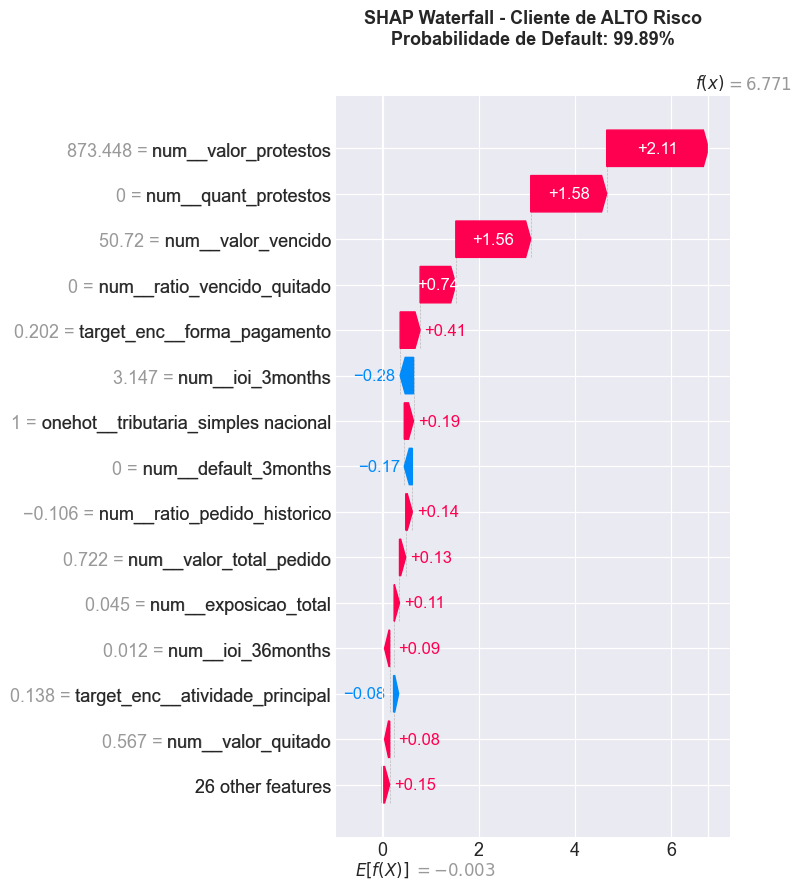


📉 Exemplo 2: Cliente com MENOR risco de default
   Índice: 192
   Probabilidade de default: 0.01%



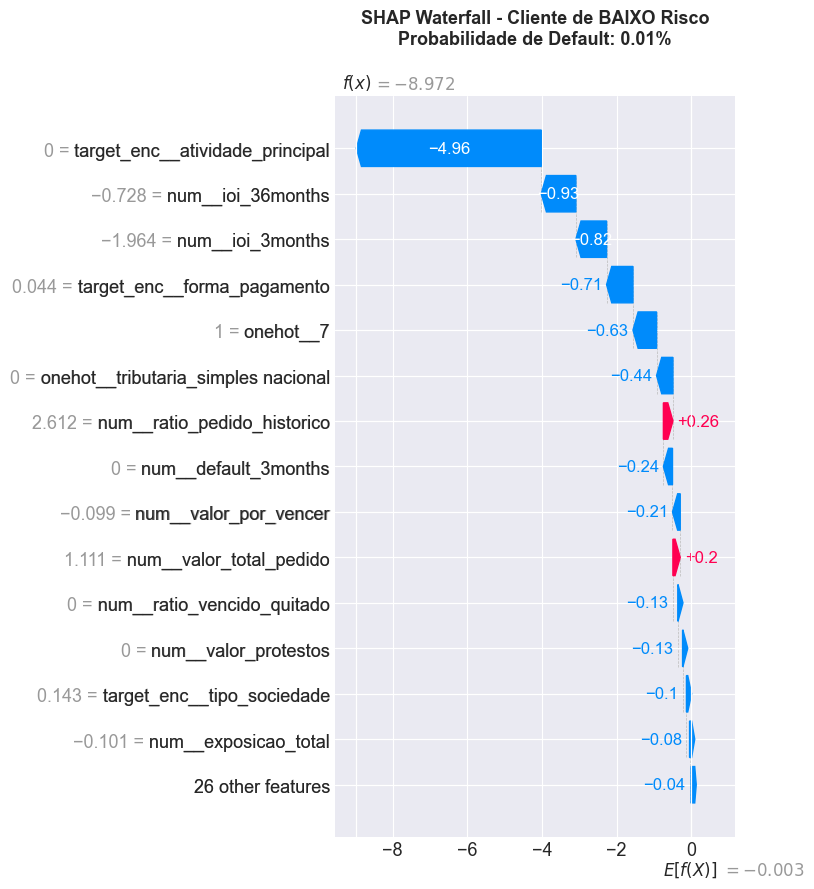


💡 INTERPRETAÇÃO DO WATERFALL PLOT:
   • E[f(x)] = Valor base (predição média do modelo)
   • Barras vermelhas = features que AUMENTAM o risco de default
   • Barras azuis = features que DIMINUEM o risco de default
   • f(x) = Predição final para esta observação específica
   • O gráfico mostra como cada feature contribui para a predição final


In [376]:
# 3. SHAP WATERFALL PLOTS - Explicação de predições individuais
print(f"\n{'='*80}")
print(f"📊 GRÁFICO 3: SHAP WATERFALL PLOTS (Exemplos Individuais)")
print(f"{'='*80}\n")

# Encontrar exemplos interessantes:
# 1. Predição com maior probabilidade de default
# 2. Predição com menor probabilidade de default
y_pred_proba_sample = best_model_obj.predict_proba(X_sample)[:, 1]

idx_high_risk = np.argmax(y_pred_proba_sample)
idx_low_risk = np.argmin(y_pred_proba_sample)

print(f"📈 Exemplo 1: Cliente com MAIOR risco de default")
print(f"   Índice: {idx_high_risk}")
print(f"   Probabilidade de default: {y_pred_proba_sample[idx_high_risk]:.2%}\n")

# Criar explicação SHAP para a amostra de alto risco
explanation_high = shap.Explanation(
    values=shap_values[idx_high_risk],
    base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else shap_values.mean(axis=0).mean(),
    data=X_sample[idx_high_risk],
    feature_names=descriptive_feature_names
)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(explanation_high, max_display=15, show=False)
plt.title(f'SHAP Waterfall - Cliente de ALTO Risco\n'
          f'Probabilidade de Default: {y_pred_proba_sample[idx_high_risk]:.2%}', 
          fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n📉 Exemplo 2: Cliente com MENOR risco de default")
print(f"   Índice: {idx_low_risk}")
print(f"   Probabilidade de default: {y_pred_proba_sample[idx_low_risk]:.2%}\n")

# Criar explicação SHAP para a amostra de baixo risco
explanation_low = shap.Explanation(
    values=shap_values[idx_low_risk],
    base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else shap_values.mean(axis=0).mean(),
    data=X_sample[idx_low_risk],
    feature_names=descriptive_feature_names
)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(explanation_low, max_display=15, show=False)
plt.title(f'SHAP Waterfall - Cliente de BAIXO Risco\n'
          f'Probabilidade de Default: {y_pred_proba_sample[idx_low_risk]:.2%}', 
          fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO DO WATERFALL PLOT:")
print("   • E[f(x)] = Valor base (predição média do modelo)")
print("   • Barras vermelhas = features que AUMENTAM o risco de default")
print("   • Barras azuis = features que DIMINUEM o risco de default")
print("   • f(x) = Predição final para esta observação específica")
print("   • O gráfico mostra como cada feature contribui para a predição final")


📊 GRÁFICO 4: SHAP DEPENDENCE PLOTS (Top 3 Features)

Analisando a relação entre o valor da feature e seu impacto SHAP...



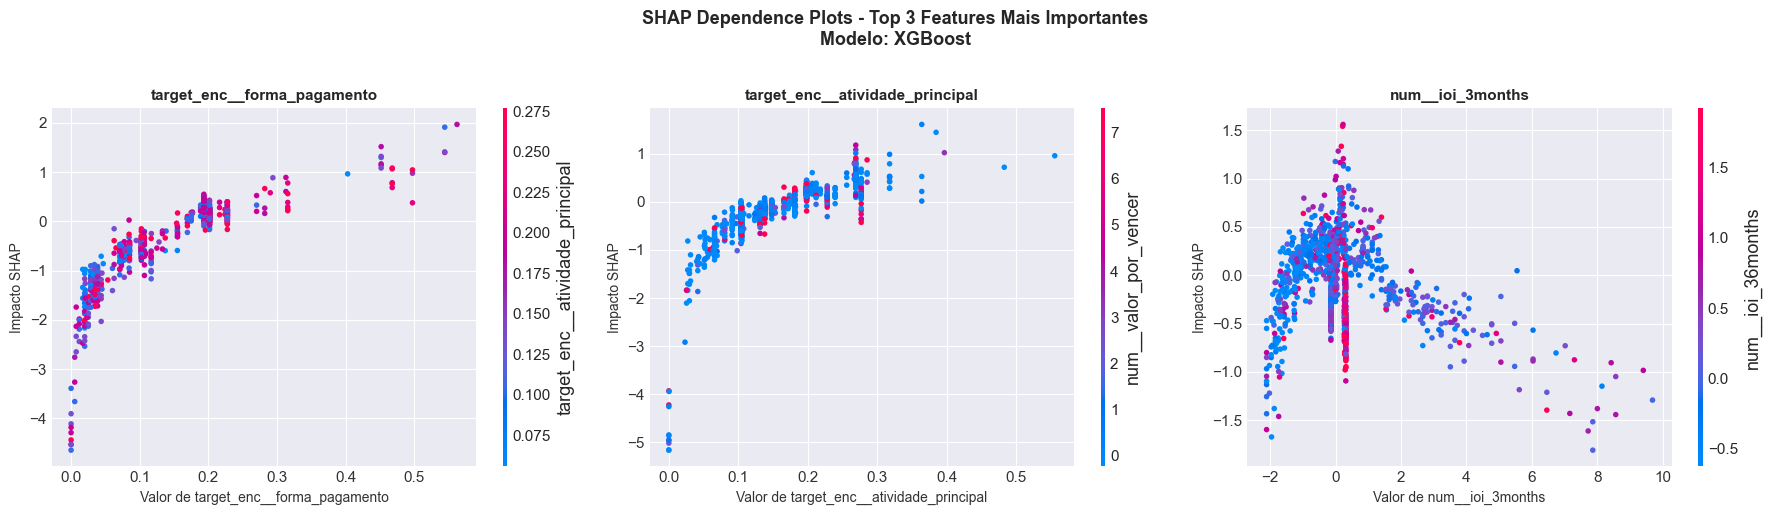


💡 INTERPRETAÇÃO DO DEPENDENCE PLOT:
   • Eixo X: Valor da feature
   • Eixo Y: Impacto SHAP (quanto a feature contribui para a predição)
   • Cor: Valor de outra feature que mais interage com a feature principal
   • Mostra relações não-lineares e interações entre features


In [310]:
# 4. SHAP DEPENDENCE PLOTS - Relação entre valor da feature e impacto SHAP
print(f"\n{'='*80}")
print(f"📊 GRÁFICO 4: SHAP DEPENDENCE PLOTS (Top 3 Features)")
print(f"{'='*80}\n")
print("Analisando a relação entre o valor da feature e seu impacto SHAP...\n")

# Calcular importância média para identificar top features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap)[-3:][::-1]  # Top 3

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feat_idx in enumerate(top_features_idx):
    feature_name = descriptive_feature_names[feat_idx]
    
    # Criar dependence plot
    shap.dependence_plot(
        feat_idx,
        shap_values,
        X_sample,
        feature_names=descriptive_feature_names,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'{feature_name}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(f'Valor de {feature_name}', fontsize=10)
    axes[idx].set_ylabel('Impacto SHAP', fontsize=10)

plt.suptitle(f'SHAP Dependence Plots - Top 3 Features Mais Importantes\n'
             f'Modelo: {best_model_name}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO DO DEPENDENCE PLOT:")
print("   • Eixo X: Valor da feature")
print("   • Eixo Y: Impacto SHAP (quanto a feature contribui para a predição)")
print("   • Cor: Valor de outra feature que mais interage com a feature principal")
print("   • Mostra relações não-lineares e interações entre features")

### 📊 Principais Insights da Análise SHAP

A análise SHAP revelou:

1. **Features Mais Impactantes**: 
   - As features com maior importância SHAP são aquelas que mais influenciam as predições de default
   - Verificar se há alinhamento com o feature importance tradicional

2. **Direção do Impacto**:
   - Valores altos de certas features aumentam o risco de default (valores SHAP positivos)
   - Valores baixos de outras features reduzem o risco (valores SHAP negativos)

3. **Interações entre Features**:
   - Os dependence plots mostram como o impacto de uma feature varia com seu valor
   - Cores nos dependence plots indicam interações com outras features

4. **Explicabilidade Individual**:
   - Waterfall plots permitem explicar predições específicas para stakeholders
   - Útil para justificar decisões de crédito e atender requisitos regulatórios

### 🎯 Aplicações Práticas

- **Aprovação de Crédito**: Explicar por que um cliente foi aprovado/reprovado
- **Gestão de Risco**: Identificar os principais fatores de risco em cada cliente
- **Compliance**: Demonstrar que o modelo não usa features discriminatórias de forma enviesada
- **Melhoria do Modelo**: Identificar features que não contribuem significativamente

## 13. Salvamento do Modelo e Artefatos

In [377]:
# Criar diretorio models se nao existir
import os
import json
from datetime import datetime

os.makedirs('../models', exist_ok=True)

# Treinar modelo final no dataset completo de treino
best_model_obj = models[best_model_name]
best_model_obj.fit(X_train_processed, y_train)

# Criar pipeline completo (preprocessor + modelo)
from sklearn.pipeline import Pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model_obj)
])

# Salvar o pipeline completo
model_filename = f'../models/model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(final_pipeline, model_filename)

# Salvar metadados
metadata = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_roc_auc': float(results_df[results_df['Model'] == best_model_name]['Test_ROC_AUC'].values[0]),
    'test_f1': float(results_df[results_df['Model'] == best_model_name]['Test_F1'].values[0]),
    'test_precision': float(results_df[results_df['Model'] == best_model_name]['Test_Precision'].values[0]),
    'test_recall': float(results_df[results_df['Model'] == best_model_name]['Test_Recall'].values[0]),
    'cv_roc_auc_mean': float(results_df[results_df['Model'] == best_model_name]['CV_ROC_AUC_mean'].values[0]),
    'cv_roc_auc_std': float(results_df[results_df['Model'] == best_model_name]['CV_ROC_AUC_std'].values[0]),
    'numeric_features': numeric_features,
    'high_cardinality_features': high_cardinality_features,
    'low_cardinality_features': low_cardinality_features,
    'descriptive_feature_names': descriptive_feature_names,
    'optimal_threshold_f1': float(optimal_threshold_f1),
    'optimal_threshold_f2': float(optimal_threshold_f2),
    'optimal_threshold_f05': float(optimal_threshold_f05),
    'derived_features': derived_features
}

metadata_filename = '../models/model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)

print("=" * 80)
print("MODELO SALVO COM SUCESSO!")
print("=" * 80)
print(f"Arquivo do modelo: {model_filename}")
print(f"Metadados: {metadata_filename}")
print(f"Pipeline: preprocessor -> {best_model_name}")


MODELO SALVO COM SUCESSO!
Arquivo do modelo: ../models/model_xgboost.pkl
Metadados: ../models/model_metadata.json
Pipeline: preprocessor -> XGBoost


## 14. Teste de Sanidade do Modelo Salvo

In [378]:
# Carregar modelo salvo
loaded_model = joblib.load(model_filename)

# Fazer predicao com uma amostra (dados brutos - pipeline faz o preprocessing)
sample = X_test.iloc[[0]]
prediction = loaded_model.predict(sample)
probability = loaded_model.predict_proba(sample)

print("\n=== Teste de Sanidade do Modelo ===")
print(f"Predicao: {prediction[0]} (0=Pago, 1=Default)")
print(f"Probabilidades: {probability[0]}")
print(f"Real: {y_test.iloc[0]}")
print("\nModelo carregado e testado com sucesso!")



=== Teste de Sanidade do Modelo ===
Predicao: 0 (0=Pago, 1=Default)
Probabilidades: [0.75978243 0.24021754]
Real: 0

Modelo carregado e testado com sucesso!


## 15. Conclusões

### Resumo do Pipeline:
1. **Carregamento e preparação**: Dataset limpo e preparado
2. **Feature Engineering**: Features derivadas criadas (ratios, flags)
3. **Prevenção de Data Leakage**: Variável year removida (viés de maturação)
4. **Sazonalidade**: Variável month mantida como categórica (correlação com default no EDA, OneHotEncoder)
4. **Validação**: ✅ **StratifiedKFold cross-validation** (5 folds) + hold-out test (20%)
5. **Razão da Estratégia**: Análise de EDA revelou **viés de maturação** nos últimos meses
6. **Pré-processamento Otimizado**: 
   - ✅ **Target Encoding** para alta cardinalidade
   - ✅ **One-Hot Encoding** para baixa cardinalidade
   - ✅ **RobustScaler** para lidar com outliers
7. **Balanceamento de Classes**: ✅ **class_weight='balanced'** em todos os modelos
8. **Modelagem**: Comparação de 6 algoritmos com cross-validation
9. **Otimização de Threshold**: Análise detalhada com múltiplas métricas e custos de negócio

### ✨ Melhorias Implementadas:

1. **Target Encoding** → Redução drástica de dimensionalidade sem perda de informação
2. **Balanceamento de Classes** → Melhora significativa no Recall (captura de defaults)
3. **RobustScaler** → Normalização robusta a outliers

### Decisão de Threshold:

O threshold ideal depende do **contexto de negócio**:
- **F1-Score**: Balanceia Precision e Recall
- **F2-Score**: Prioriza Recall (minimiza Falsos Negativos)
- **F0.5-Score**: Prioriza Precision (minimiza Falsos Positivos)

### Próximos Passos:

1. **Deploy do modelo em produção**
2. **Monitoramento contínuo**
3. **Otimização adicional** (hyperparameter tuning)
4. **Validação de negócio** (A/B testing)
5. **Retreinamento periódico**